In [16]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd
from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.features.preprocessor import Preprocessor
from run import Dataset

(CVXPY) Jun 12 09:47:19 AM: Encountered unexpected exception importing solver PROXQP:
ImportError("dlopen(/Users/buchkovv/qamsi/.venv/lib/python3.12/site-packages/cmeel.prefix/lib/python3.12/site-packages/proxsuite/proxsuite_pywrap.cpython-312-darwin.so, 0x0002): Library not loaded: @rpath/libc++.1.dylib\n  Referenced from: <73C5C23C-530A-3E0E-A88E-7897A0C69618> /Users/buchkovv/qamsi/.venv/lib/python3.12/site-packages/cmeel.prefix/lib/python3.12/site-packages/proxsuite/proxsuite_pywrap.cpython-312-darwin.so\n  Reason: tried: '/Users/runner/miniconda3/envs/proxsuite/lib/libc++.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/runner/miniconda3/envs/proxsuite/lib/libc++.1.dylib' (no such file), '/var/folders/0j/bwqcs4y508s2n4ck4dhf3rpc0000gn/T/cmeel-qko5evau/whl/cmeel.prefix/lib/libc++.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/var/folders/0j/bwqcs4y508s2n4ck4dhf3rpc0000gn/T/cmeel-qko5evau/whl/cmeel.prefix/lib/libc++.1.dylib' (no such file), '/Users

In [18]:
REBAL_FREQ = "ME"
DATASET = Dataset.SPX_US
ESTIMATION_WINDOW = 365 * 1

In [19]:
experiment_config = DATASET.value()

stocks = tuple(
    pd.read_csv(experiment_config.PATH_OUTPUT / experiment_config.STOCKS_LIST_FILENAME)
    .iloc[:, 0]
    .astype(str)
    .tolist(),
)
experiment_config.ASSET_UNIVERSE = stocks  # type: ignore  # noqa: PGH003

experiment_config.MIN_ROLLING_PERIODS = ESTIMATION_WINDOW + 1
experiment_config.N_LOOKBEHIND_PERIODS = None
experiment_config.REBALANCE_FREQ = REBAL_FREQ

factors = pd.read_csv(experiment_config.PATH_OUTPUT / "factors.csv")
factors["date"] = pd.to_datetime(factors["date"])
factors = factors.set_index("date")
factor_names = tuple(factors.columns.astype(str).tolist())
experiment_config.FACTORS = factor_names

prices = [stock + "_Price" for stock in list(stocks)]
preprocessor = Preprocessor(
    exclude_names=[
        *list(stocks),
        experiment_config.RF_NAME,
        *experiment_config.HEDGING_ASSETS,
        *factor_names,
        *prices,
    ],
)

trading_config = TradingConfig(
    broker_fee=0.05 / 100,
    bid_ask_spread=0.03 / 100,
    total_exposure=1,
    max_exposure=1,
    min_exposure=0,
    trading_lag_days=1,
)

runner = Runner(
    experiment_config=experiment_config,
    trading_config=trading_config,
    verbose=False,
)

In [20]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.optimize import fmin_l_bfgs_b, minimize

class ShrinkageGP:
    def __init__(
        self,
        start: pd.Timestamp,
        end: pd.Timestamp,
        max_shrinkage: float = 1,
        max_iterations: int = 10,
        acq_beta: float = 1.96,
    ) -> None:
        self.start = start
        self.end = end
        self.acq_beta = acq_beta
        self._domain_ra = (0, max_shrinkage)
        self.max_iterations = max_iterations

        self.previous_points = []
        self.previous_targets = []

        self.optimal_shrinkage = None

        self.gpr = GaussianProcessRegressor(
            kernel=RBF(),
            n_restarts_optimizer=12,
            random_state=12,
        )

    def optimize(self, ra: float) -> float:
        estimator = CovEstimators.RISKFOLIO.value(
            alpha=ra,
            estimator_type="shrunk",
        )

        strategy = MinVariance(
            cov_estimator=estimator,
            trading_config=trading_config,
            window_size=ESTIMATION_WINDOW,
        )

        fitted_r = runner.run_one_step(
            start_date=self.start,
            end_date=self.end,
            feature_processor=preprocessor,
            strategy=strategy,
        )
        return -fitted_r.std().item()

    def next_recommendation(self) -> np.ndarray:
        return self.optimize_acquisition_function().item()

    def optimize_acquisition_function(self) -> np.ndarray:
        def objective(x: np.array):
            return -self.acquisition_function(x)

        f_values = []
        x_values = []

        np.random.seed(12)
        # Restarts the optimization 20 times and pick best solution
        for _ in range(20):
            x_init = self._domain_ra[0] + (
                self._domain_ra[1] - self._domain_ra[0]
            ) * np.random.rand(1)
            result = fmin_l_bfgs_b(
                objective,
                x0=np.array([x_init]),
                bounds=[self._domain_ra],
                approx_grad=True,
            )
            x_values.append(result[0])
            f_values.append(result[1])

        ind = np.argmin(f_values)
        return x_values[ind]

    def acquisition_function(self, x: np.ndarray) -> np.ndarray:
        mu_f, sigma_f = self.gpr.predict(x.reshape(-1, 1), return_std=True)

        return (mu_f + sigma_f * self.acq_beta)[0]

    def add_data_point(self, x: float, acq_fn_val: float) -> None:
        self.previous_points.append(x)
        self.previous_targets.append(acq_fn_val)

        self.gpr.fit(
            np.array(self.previous_points).reshape(-1, 1),
            np.array(self.previous_targets),
        )

    def get_solution(self) -> tuple[float, np.ndarray]:
        idx = np.argmax(np.array(self.previous_targets))
        ra_init = self.previous_points[idx]

        def objective(x: np.array):
            x = np.array(x).reshape(-1, 1)
            mean, _ = self.gpr.predict(x, return_std=True)
            return -mean.item()

        np.random.seed(12)
        result = minimize(objective, x0=ra_init, bounds=[self._domain_ra])
        ra_opt = result.x.item()

        sharpe = self.optimize(ra_opt)
        self.optimal_sharpe = sharpe

        return ra_opt

    def solve(self) -> float:
        return self._run_search(self.max_iterations)

    def __call__(self):
        return self.solve()

    def _run_search(self, max_iter: int) -> float:
        for _ in range(max_iter):
            ra = self.next_recommendation()

            sharpe = self.optimize(ra)

            self.add_data_point(ra, sharpe)

        ra_opt = self.get_solution()

        return ra_opt

In [21]:
start_date = pd.Timestamp("2016-01-01")
end_date = runner.returns.simple_returns.loc[start_date:].iloc[20:].index[0]

start_date, end_date

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-02-02 00:00:00'))

In [22]:
opt = ShrinkageGP(
    experiement_runner=runner,
    start=start_date,
    end=end_date,
)
opt()

TypeError: ShrinkageGP.__init__() got an unexpected keyword argument 'experiement_runner'

In [8]:
-opt.optimal_sharpe, -opt.optimize(0.1)

(0.007126348786312239, 0.007195512816994873)

In [ ]:
import gc

available_dates = runner.returns.simple_returns.loc["2013-10-16":].index

optimal = []
for i, date in enumerate(available_dates):
    start_date = date
    end_date = runner.returns.simple_returns.loc[start_date:].iloc[20:].index[0]

    opt = ShrinkageGP(
        start=start_date,
        end=end_date,
    )
    opt_ra = opt()
    print(f"Date: {start_date}, Volatility: {-opt.optimal_sharpe * np.sqrt(252):.6f}, Naive Volatility: {-opt.optimize(0.1) * np.sqrt(252):.6f}, Shrinkage: {opt_ra:.2f}")

    optimal.append([start_date, -opt.optimal_sharpe, -opt.optimize(0.1), opt_ra])

    if i % 20 == 0:
        optimal_df = pd.DataFrame(optimal, columns=["date", "vol", "naive_vol", "shrinkage"]).set_index("date")
        optimal_df.to_csv("targets.csv", index=True, header=True)

    gc.collect()
    del opt

Date: 2013-10-16 00:00:00, Volatility: 0.066657, Naive Volatility: 0.071646, Shrinkage: 0.41
Date: 2013-10-17 00:00:00, Volatility: 0.063372, Naive Volatility: 0.066664, Shrinkage: 0.38
Date: 2013-10-18 00:00:00, Volatility: 0.061408, Naive Volatility: 0.064052, Shrinkage: 0.35
Date: 2013-10-21 00:00:00, Volatility: 0.063493, Naive Volatility: 0.065072, Shrinkage: 0.34
Date: 2013-10-22 00:00:00, Volatility: 0.057949, Naive Volatility: 0.058502, Shrinkage: 0.00
Date: 2013-10-23 00:00:00, Volatility: 0.057911, Naive Volatility: 0.058542, Shrinkage: 0.01
Date: 2013-10-24 00:00:00, Volatility: 0.057704, Naive Volatility: 0.058491, Shrinkage: 0.00
Date: 2013-10-25 00:00:00, Volatility: 0.058902, Naive Volatility: 0.058992, Shrinkage: 0.15
Date: 2013-10-28 00:00:00, Volatility: 0.057647, Naive Volatility: 0.057677, Shrinkage: 0.08
Date: 2013-10-29 00:00:00, Volatility: 0.057400, Naive Volatility: 0.057401, Shrinkage: 0.10
Date: 2013-10-30 00:00:00, Volatility: 0.058953, Naive Volatility: 0.0

In [1]:
import pandas as pd

first = pd.read_csv("targets_first.csv", header=None)
first.head()

,0,1,2,3
0,Date: 2005-03-18 00:00:00,Volatility: 0.094063,Naive Volatility: 0.096129,Shrinkage: 0.31
1,Date: 2005-03-21 00:00:00,Volatility: 0.093796,Naive Volatility: 0.095455,Shrinkage: 0.27
2,Date: 2005-03-22 00:00:00,Volatility: 0.096337,Naive Volatility: 0.097999,Shrinkage: 0.27
3,Date: 2005-03-23 00:00:00,Volatility: 0.115191,Naive Volatility: 0.124503,Shrinkage: 0.46
4,Date: 2005-03-24 00:00:00,Volatility: 0.117283,Naive Volatility: 0.126993,Shrinkage: 0.47


In [2]:
for col in first.columns:
    first[col] = first[col].apply(lambda row: row.split(": ")[1])
first

,0,1,2,3
0,2005-03-18 00:00:00,0.094063,0.096129,0.31
1,2005-03-21 00:00:00,0.093796,0.095455,0.27
2,2005-03-22 00:00:00,0.096337,0.097999,0.27
3,2005-03-23 00:00:00,0.115191,0.124503,0.46
4,2005-03-24 00:00:00,0.117283,0.126993,0.47
...,...,...,...,...
2156,2013-10-10 00:00:00,0.082036,0.087844,0.42
2157,2013-10-11 00:00:00,0.082310,0.087742,0.39
2158,2013-10-14 00:00:00,0.082206,0.087869,0.41
2159,2013-10-15 00:00:00,0.076890,0.082088,0.38


In [3]:
first.columns = ["date", "vol", "naive_vol", "l_shrinkage"]
first["date"] = pd.to_datetime(first["date"], format="%Y-%m-%d %H:%M:%S")
first = first.set_index("date")
first

,vol,naive_vol,l_shrinkage
date,,,
2005-03-18,0.094063,0.096129,0.31
2005-03-21,0.093796,0.095455,0.27
2005-03-22,0.096337,0.097999,0.27
2005-03-23,0.115191,0.124503,0.46
2005-03-24,0.117283,0.126993,0.47
...,...,...,...
2013-10-10,0.082036,0.087844,0.42
2013-10-11,0.082310,0.087742,0.39
2013-10-14,0.082206,0.087869,0.41


In [4]:
full_df = first.copy()

def get_targets(filename: str, full_df: pd.DataFrame) -> pd.DataFrame:
    targets = pd.read_csv(filename)
    targets["date"] = pd.to_datetime(targets["date"])
    targets = targets.set_index("date")
    targets = targets.rename(columns={"shrinkage": "l_shrinkage"})

    full_df = pd.concat([full_df, targets], axis=0)

    return full_df

full_df = get_targets("targets2.csv", full_df)
full_df.shape

(2402, 3)

In [5]:
full_df = get_targets("targets3.csv", full_df)
full_df.shape

(2423, 3)

In [6]:
full_df = get_targets("main_targets.csv", full_df)
full_df = full_df.sort_index()
full_df

,vol,naive_vol,l_shrinkage
date,,,
2005-03-18,0.094063,0.096129,0.31
2005-03-21,0.093796,0.095455,0.27
2005-03-22,0.096337,0.097999,0.27
2005-03-23,0.115191,0.124503,0.46
2005-03-24,0.117283,0.126993,0.47
...,...,...,...
2023-11-17,0.005991,0.00618,0.424031
2023-11-20,0.00598,0.006292,0.640182
2023-11-21,0.007018,0.007212,0.401062


In [8]:
full_df.l_shrinkage = full_df.l_shrinkage.astype(float)

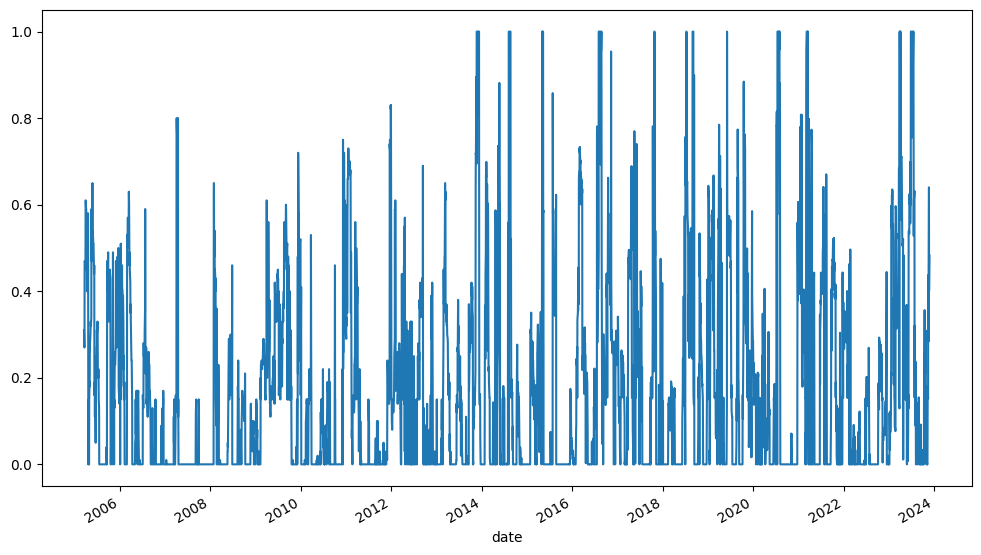

In [9]:
full_df.l_shrinkage.plot(figsize=(12, 7));

In [10]:
full_df.to_csv("linear_targets.csv", index=True, header=True)

```
Date: 2005-03-18 00:00:00, Volatility: 0.094063, Naive Volatility: 0.096129, Shrinkage: 0.31
Date: 2005-03-21 00:00:00, Volatility: 0.093796, Naive Volatility: 0.095455, Shrinkage: 0.27
Date: 2005-03-22 00:00:00, Volatility: 0.096337, Naive Volatility: 0.097999, Shrinkage: 0.27
Date: 2005-03-23 00:00:00, Volatility: 0.115191, Naive Volatility: 0.124503, Shrinkage: 0.46
Date: 2005-03-24 00:00:00, Volatility: 0.117283, Naive Volatility: 0.126993, Shrinkage: 0.47
Date: 2005-03-28 00:00:00, Volatility: 0.120227, Naive Volatility: 0.128558, Shrinkage: 0.46
Date: 2005-03-29 00:00:00, Volatility: 0.122062, Naive Volatility: 0.127735, Shrinkage: 0.45
Date: 2005-03-30 00:00:00, Volatility: 0.117621, Naive Volatility: 0.124989, Shrinkage: 0.48
Date: 2005-03-31 00:00:00, Volatility: 0.121372, Naive Volatility: 0.131892, Shrinkage: 0.61
Date: 2005-04-01 00:00:00, Volatility: 0.126614, Naive Volatility: 0.135888, Shrinkage: 0.61
Date: 2005-04-04 00:00:00, Volatility: 0.127050, Naive Volatility: 0.136708, Shrinkage: 0.59
Date: 2005-04-05 00:00:00, Volatility: 0.125774, Naive Volatility: 0.135966, Shrinkage: 0.59
Date: 2005-04-06 00:00:00, Volatility: 0.128947, Naive Volatility: 0.135848, Shrinkage: 0.57
Date: 2005-04-07 00:00:00, Volatility: 0.128328, Naive Volatility: 0.134508, Shrinkage: 0.55
Date: 2005-04-08 00:00:00, Volatility: 0.126774, Naive Volatility: 0.132643, Shrinkage: 0.56
Date: 2005-04-11 00:00:00, Volatility: 0.127036, Naive Volatility: 0.132271, Shrinkage: 0.40
Date: 2005-04-12 00:00:00, Volatility: 0.127727, Naive Volatility: 0.134097, Shrinkage: 0.42
Date: 2005-04-13 00:00:00, Volatility: 0.126189, Naive Volatility: 0.132609, Shrinkage: 0.43
Date: 2005-04-14 00:00:00, Volatility: 0.125040, Naive Volatility: 0.132017, Shrinkage: 0.51
Date: 2005-04-15 00:00:00, Volatility: 0.115110, Naive Volatility: 0.123907, Shrinkage: 0.57
Date: 2005-04-18 00:00:00, Volatility: 0.120185, Naive Volatility: 0.127829, Shrinkage: 0.57
Date: 2005-04-19 00:00:00, Volatility: 0.120503, Naive Volatility: 0.127322, Shrinkage: 0.58
Date: 2005-04-20 00:00:00, Volatility: 0.114105, Naive Volatility: 0.122341, Shrinkage: 0.58
Date: 2005-04-21 00:00:00, Volatility: 0.099718, Naive Volatility: 0.100450, Shrinkage: 0.22
Date: 2005-04-22 00:00:00, Volatility: 0.095729, Naive Volatility: 0.096200, Shrinkage: 0.00
Date: 2005-04-25 00:00:00, Volatility: 0.092925, Naive Volatility: 0.093154, Shrinkage: 0.15
Date: 2005-04-26 00:00:00, Volatility: 0.090034, Naive Volatility: 0.090695, Shrinkage: 0.00
Date: 2005-04-27 00:00:00, Volatility: 0.089138, Naive Volatility: 0.089603, Shrinkage: 0.00
Date: 2005-04-28 00:00:00, Volatility: 0.077982, Naive Volatility: 0.078636, Shrinkage: 0.00
Date: 2005-04-29 00:00:00, Volatility: 0.072926, Naive Volatility: 0.072825, Shrinkage: 0.15
Date: 2005-05-02 00:00:00, Volatility: 0.074247, Naive Volatility: 0.075023, Shrinkage: 0.19
Date: 2005-05-03 00:00:00, Volatility: 0.077004, Naive Volatility: 0.077631, Shrinkage: 0.18
Date: 2005-05-04 00:00:00, Volatility: 0.073408, Naive Volatility: 0.075215, Shrinkage: 0.26
Date: 2005-05-05 00:00:00, Volatility: 0.073802, Naive Volatility: 0.075284, Shrinkage: 0.26
Date: 2005-05-06 00:00:00, Volatility: 0.073076, Naive Volatility: 0.074916, Shrinkage: 0.28
Date: 2005-05-09 00:00:00, Volatility: 0.071227, Naive Volatility: 0.073589, Shrinkage: 0.30
Date: 2005-05-10 00:00:00, Volatility: 0.068054, Naive Volatility: 0.070544, Shrinkage: 0.31
Date: 2005-05-11 00:00:00, Volatility: 0.067832, Naive Volatility: 0.070658, Shrinkage: 0.33
Date: 2005-05-12 00:00:00, Volatility: 0.063739, Naive Volatility: 0.065426, Shrinkage: 0.33
Date: 2005-05-13 00:00:00, Volatility: 0.054792, Naive Volatility: 0.056448, Shrinkage: 0.32
Date: 2005-05-16 00:00:00, Volatility: 0.051171, Naive Volatility: 0.054265, Shrinkage: 0.34
Date: 2005-05-17 00:00:00, Volatility: 0.049739, Naive Volatility: 0.055163, Shrinkage: 0.59
Date: 2005-05-18 00:00:00, Volatility: 0.046601, Naive Volatility: 0.053033, Shrinkage: 0.56
Date: 2005-05-19 00:00:00, Volatility: 0.048839, Naive Volatility: 0.053693, Shrinkage: 0.47
Date: 2005-05-20 00:00:00, Volatility: 0.047949, Naive Volatility: 0.052623, Shrinkage: 0.47
Date: 2005-05-23 00:00:00, Volatility: 0.048030, Naive Volatility: 0.054143, Shrinkage: 0.53
Date: 2005-05-24 00:00:00, Volatility: 0.047755, Naive Volatility: 0.053951, Shrinkage: 0.55
Date: 2005-05-25 00:00:00, Volatility: 0.051409, Naive Volatility: 0.058678, Shrinkage: 0.65
Date: 2005-05-26 00:00:00, Volatility: 0.056196, Naive Volatility: 0.061510, Shrinkage: 0.53
Date: 2005-05-27 00:00:00, Volatility: 0.054697, Naive Volatility: 0.059467, Shrinkage: 0.54
Date: 2005-05-31 00:00:00, Volatility: 0.062180, Naive Volatility: 0.066283, Shrinkage: 0.52
Date: 2005-06-01 00:00:00, Volatility: 0.058731, Naive Volatility: 0.063669, Shrinkage: 0.51
Date: 2005-06-02 00:00:00, Volatility: 0.059350, Naive Volatility: 0.063784, Shrinkage: 0.51
Date: 2005-06-03 00:00:00, Volatility: 0.057699, Naive Volatility: 0.061386, Shrinkage: 0.51
Date: 2005-06-06 00:00:00, Volatility: 0.058609, Naive Volatility: 0.062073, Shrinkage: 0.45
Date: 2005-06-07 00:00:00, Volatility: 0.066511, Naive Volatility: 0.069438, Shrinkage: 0.44
Date: 2005-06-08 00:00:00, Volatility: 0.065943, Naive Volatility: 0.068489, Shrinkage: 0.44
Date: 2005-06-09 00:00:00, Volatility: 0.072714, Naive Volatility: 0.075014, Shrinkage: 0.46
Date: 2005-06-10 00:00:00, Volatility: 0.075391, Naive Volatility: 0.075621, Shrinkage: 0.16
Date: 2005-06-13 00:00:00, Volatility: 0.074482, Naive Volatility: 0.074729, Shrinkage: 0.19
Date: 2005-06-14 00:00:00, Volatility: 0.073456, Naive Volatility: 0.073480, Shrinkage: 0.11
Date: 2005-06-15 00:00:00, Volatility: 0.072896, Naive Volatility: 0.072948, Shrinkage: 0.15
Date: 2005-06-16 00:00:00, Volatility: 0.071708, Naive Volatility: 0.071790, Shrinkage: 0.15
Date: 2005-06-17 00:00:00, Volatility: 0.073477, Naive Volatility: 0.073621, Shrinkage: 0.15
Date: 2005-06-20 00:00:00, Volatility: 0.075090, Naive Volatility: 0.075159, Shrinkage: 0.05
Date: 2005-06-21 00:00:00, Volatility: 0.074796, Naive Volatility: 0.074891, Shrinkage: 0.15
Date: 2005-06-22 00:00:00, Volatility: 0.076031, Naive Volatility: 0.076125, Shrinkage: 0.15
Date: 2005-06-23 00:00:00, Volatility: 0.074594, Naive Volatility: 0.074963, Shrinkage: 0.18
Date: 2005-06-24 00:00:00, Volatility: 0.069581, Naive Volatility: 0.070229, Shrinkage: 0.25
Date: 2005-06-27 00:00:00, Volatility: 0.069104, Naive Volatility: 0.069691, Shrinkage: 0.24
Date: 2005-06-28 00:00:00, Volatility: 0.062834, Naive Volatility: 0.063465, Shrinkage: 0.27
Date: 2005-06-29 00:00:00, Volatility: 0.065877, Naive Volatility: 0.066948, Shrinkage: 0.27
Date: 2005-06-30 00:00:00, Volatility: 0.069878, Naive Volatility: 0.071357, Shrinkage: 0.31
Date: 2005-07-01 00:00:00, Volatility: 0.070446, Naive Volatility: 0.071544, Shrinkage: 0.30
Date: 2005-07-05 00:00:00, Volatility: 0.072286, Naive Volatility: 0.073031, Shrinkage: 0.33
Date: 2005-07-06 00:00:00, Volatility: 0.064423, Naive Volatility: 0.065798, Shrinkage: 0.32
Date: 2005-07-07 00:00:00, Volatility: 0.066359, Naive Volatility: 0.067240, Shrinkage: 0.27
Date: 2005-07-08 00:00:00, Volatility: 0.063890, Naive Volatility: 0.064252, Shrinkage: 0.21
Date: 2005-07-11 00:00:00, Volatility: 0.063523, Naive Volatility: 0.063858, Shrinkage: 0.20
Date: 2005-07-12 00:00:00, Volatility: 0.067920, Naive Volatility: 0.068392, Shrinkage: 0.22
Date: 2005-07-13 00:00:00, Volatility: 0.068043, Naive Volatility: 0.068405, Shrinkage: 0.22
Date: 2005-07-14 00:00:00, Volatility: 0.072327, Naive Volatility: 0.072678, Shrinkage: 0.19
Date: 2005-07-15 00:00:00, Volatility: 0.072978, Naive Volatility: 0.073180, Shrinkage: 0.15
Date: 2005-07-18 00:00:00, Volatility: 0.071142, Naive Volatility: 0.071204, Shrinkage: 0.13
Date: 2005-07-19 00:00:00, Volatility: 0.076721, Naive Volatility: 0.077002, Shrinkage: 0.00
Date: 2005-07-20 00:00:00, Volatility: 0.076431, Naive Volatility: 0.076941, Shrinkage: 0.00
Date: 2005-07-21 00:00:00, Volatility: 0.074861, Naive Volatility: 0.075434, Shrinkage: 0.00
Date: 2005-07-22 00:00:00, Volatility: 0.073059, Naive Volatility: 0.073625, Shrinkage: 0.00
Date: 2005-07-25 00:00:00, Volatility: 0.073191, Naive Volatility: 0.074451, Shrinkage: 0.00
Date: 2005-07-26 00:00:00, Volatility: 0.073210, Naive Volatility: 0.074722, Shrinkage: 0.00
Date: 2005-07-27 00:00:00, Volatility: 0.073737, Naive Volatility: 0.075590, Shrinkage: 0.00
Date: 2005-07-28 00:00:00, Volatility: 0.068342, Naive Volatility: 0.069656, Shrinkage: 0.00
Date: 2005-07-29 00:00:00, Volatility: 0.064185, Naive Volatility: 0.066741, Shrinkage: 0.00
Date: 2005-08-01 00:00:00, Volatility: 0.067182, Naive Volatility: 0.069254, Shrinkage: 0.00
Date: 2005-08-02 00:00:00, Volatility: 0.065260, Naive Volatility: 0.067181, Shrinkage: 0.00
Date: 2005-08-03 00:00:00, Volatility: 0.064530, Naive Volatility: 0.067469, Shrinkage: 0.00
Date: 2005-08-04 00:00:00, Volatility: 0.064751, Naive Volatility: 0.067465, Shrinkage: 0.00
Date: 2005-08-05 00:00:00, Volatility: 0.063563, Naive Volatility: 0.065062, Shrinkage: 0.00
Date: 2005-08-08 00:00:00, Volatility: 0.068389, Naive Volatility: 0.069842, Shrinkage: 0.00
Date: 2005-08-09 00:00:00, Volatility: 0.067089, Naive Volatility: 0.069052, Shrinkage: 0.00
Date: 2005-08-10 00:00:00, Volatility: 0.067918, Naive Volatility: 0.070336, Shrinkage: 0.00
Date: 2005-08-11 00:00:00, Volatility: 0.068060, Naive Volatility: 0.071083, Shrinkage: 0.00
Date: 2005-08-12 00:00:00, Volatility: 0.067895, Naive Volatility: 0.070060, Shrinkage: 0.00
Date: 2005-08-15 00:00:00, Volatility: 0.073010, Naive Volatility: 0.075099, Shrinkage: 0.00
Date: 2005-08-16 00:00:00, Volatility: 0.064478, Naive Volatility: 0.066137, Shrinkage: 0.00
Date: 2005-08-17 00:00:00, Volatility: 0.064350, Naive Volatility: 0.065902, Shrinkage: 0.00
Date: 2005-08-18 00:00:00, Volatility: 0.065225, Naive Volatility: 0.066421, Shrinkage: 0.00
Date: 2005-08-19 00:00:00, Volatility: 0.067108, Naive Volatility: 0.068381, Shrinkage: 0.00
Date: 2005-08-22 00:00:00, Volatility: 0.070068, Naive Volatility: 0.072342, Shrinkage: 0.00
Date: 2005-08-23 00:00:00, Volatility: 0.072097, Naive Volatility: 0.075005, Shrinkage: 0.00
Date: 2005-08-24 00:00:00, Volatility: 0.071384, Naive Volatility: 0.074096, Shrinkage: 0.00
Date: 2005-08-25 00:00:00, Volatility: 0.070764, Naive Volatility: 0.073376, Shrinkage: 0.00
Date: 2005-08-26 00:00:00, Volatility: 0.069537, Naive Volatility: 0.072088, Shrinkage: 0.00
Date: 2005-08-29 00:00:00, Volatility: 0.068325, Naive Volatility: 0.070707, Shrinkage: 0.00
Date: 2005-08-30 00:00:00, Volatility: 0.070173, Naive Volatility: 0.072528, Shrinkage: 0.00
Date: 2005-08-31 00:00:00, Volatility: 0.070359, Naive Volatility: 0.072131, Shrinkage: 0.00
Date: 2005-09-01 00:00:00, Volatility: 0.070263, Naive Volatility: 0.072329, Shrinkage: 0.00
Date: 2005-09-02 00:00:00, Volatility: 0.070301, Naive Volatility: 0.072614, Shrinkage: 0.00
Date: 2005-09-06 00:00:00, Volatility: 0.065952, Naive Volatility: 0.068043, Shrinkage: 0.00
Date: 2005-09-07 00:00:00, Volatility: 0.076916, Naive Volatility: 0.078167, Shrinkage: 0.00
Date: 2005-09-08 00:00:00, Volatility: 0.076848, Naive Volatility: 0.077791, Shrinkage: 0.00
Date: 2005-09-09 00:00:00, Volatility: 0.073305, Naive Volatility: 0.074129, Shrinkage: 0.00
Date: 2005-09-12 00:00:00, Volatility: 0.074733, Naive Volatility: 0.075074, Shrinkage: 0.00
Date: 2005-09-13 00:00:00, Volatility: 0.073336, Naive Volatility: 0.073812, Shrinkage: 0.00
Date: 2005-09-14 00:00:00, Volatility: 0.073098, Naive Volatility: 0.073613, Shrinkage: 0.00
Date: 2005-09-15 00:00:00, Volatility: 0.071564, Naive Volatility: 0.072127, Shrinkage: 0.00
Date: 2005-09-16 00:00:00, Volatility: 0.070809, Naive Volatility: 0.071165, Shrinkage: 0.04
Date: 2005-09-19 00:00:00, Volatility: 0.072690, Naive Volatility: 0.073285, Shrinkage: 0.00
Date: 2005-09-20 00:00:00, Volatility: 0.084803, Naive Volatility: 0.089612, Shrinkage: 0.37
Date: 2005-09-21 00:00:00, Volatility: 0.084920, Naive Volatility: 0.091749, Shrinkage: 0.47
Date: 2005-09-22 00:00:00, Volatility: 0.093080, Naive Volatility: 0.097098, Shrinkage: 0.40
Date: 2005-09-23 00:00:00, Volatility: 0.093973, Naive Volatility: 0.099663, Shrinkage: 0.42
Date: 2005-09-26 00:00:00, Volatility: 0.107664, Naive Volatility: 0.112137, Shrinkage: 0.42
Date: 2005-09-27 00:00:00, Volatility: 0.107287, Naive Volatility: 0.112614, Shrinkage: 0.44
Date: 2005-09-28 00:00:00, Volatility: 0.105926, Naive Volatility: 0.111604, Shrinkage: 0.45
Date: 2005-09-29 00:00:00, Volatility: 0.105432, Naive Volatility: 0.112610, Shrinkage: 0.49
Date: 2005-09-30 00:00:00, Volatility: 0.113734, Naive Volatility: 0.118031, Shrinkage: 0.40
Date: 2005-10-03 00:00:00, Volatility: 0.114655, Naive Volatility: 0.118291, Shrinkage: 0.33
Date: 2005-10-04 00:00:00, Volatility: 0.115962, Naive Volatility: 0.120905, Shrinkage: 0.34
Date: 2005-10-05 00:00:00, Volatility: 0.110021, Naive Volatility: 0.115076, Shrinkage: 0.38
Date: 2005-10-06 00:00:00, Volatility: 0.106040, Naive Volatility: 0.112317, Shrinkage: 0.39
Date: 2005-10-07 00:00:00, Volatility: 0.105931, Naive Volatility: 0.112677, Shrinkage: 0.38
Date: 2005-10-10 00:00:00, Volatility: 0.105086, Naive Volatility: 0.112653, Shrinkage: 0.40
Date: 2005-10-11 00:00:00, Volatility: 0.102287, Naive Volatility: 0.109462, Shrinkage: 0.39
Date: 2005-10-12 00:00:00, Volatility: 0.103368, Naive Volatility: 0.110786, Shrinkage: 0.44
Date: 2005-10-13 00:00:00, Volatility: 0.105995, Naive Volatility: 0.114677, Shrinkage: 0.45
Date: 2005-10-14 00:00:00, Volatility: 0.105407, Naive Volatility: 0.114396, Shrinkage: 0.44
Date: 2005-10-17 00:00:00, Volatility: 0.104890, Naive Volatility: 0.113090, Shrinkage: 0.43
Date: 2005-10-18 00:00:00, Volatility: 0.089286, Naive Volatility: 0.089997, Shrinkage: 0.17
Date: 2005-10-19 00:00:00, Volatility: 0.081448, Naive Volatility: 0.082996, Shrinkage: 0.00
Date: 2005-10-20 00:00:00, Volatility: 0.074317, Naive Volatility: 0.075125, Shrinkage: 0.00
Date: 2005-10-21 00:00:00, Volatility: 0.074096, Naive Volatility: 0.074958, Shrinkage: 0.00
Date: 2005-10-24 00:00:00, Volatility: 0.063738, Naive Volatility: 0.063893, Shrinkage: 0.09
Date: 2005-10-25 00:00:00, Volatility: 0.064868, Naive Volatility: 0.064914, Shrinkage: 0.13
Date: 2005-10-26 00:00:00, Volatility: 0.059385, Naive Volatility: 0.059410, Shrinkage: 0.11
Date: 2005-10-27 00:00:00, Volatility: 0.054641, Naive Volatility: 0.054809, Shrinkage: 0.15
Date: 2005-10-28 00:00:00, Volatility: 0.057236, Naive Volatility: 0.057304, Shrinkage: 0.14
Date: 2005-10-31 00:00:00, Volatility: 0.057412, Naive Volatility: 0.057599, Shrinkage: 0.15
Date: 2005-11-01 00:00:00, Volatility: 0.061373, Naive Volatility: 0.061562, Shrinkage: 0.00
Date: 2005-11-02 00:00:00, Volatility: 0.062926, Naive Volatility: 0.063395, Shrinkage: 0.00
Date: 2005-11-03 00:00:00, Volatility: 0.065296, Naive Volatility: 0.065315, Shrinkage: 0.14
Date: 2005-11-04 00:00:00, Volatility: 0.065881, Naive Volatility: 0.066879, Shrinkage: 0.25
Date: 2005-11-07 00:00:00, Volatility: 0.063305, Naive Volatility: 0.066799, Shrinkage: 0.49
Date: 2005-11-08 00:00:00, Volatility: 0.065439, Naive Volatility: 0.065741, Shrinkage: 0.19
Date: 2005-11-09 00:00:00, Volatility: 0.065567, Naive Volatility: 0.066026, Shrinkage: 0.20
Date: 2005-11-10 00:00:00, Volatility: 0.060650, Naive Volatility: 0.060702, Shrinkage: 0.13
Date: 2005-11-11 00:00:00, Volatility: 0.060570, Naive Volatility: 0.060475, Shrinkage: 0.14
Date: 2005-11-14 00:00:00, Volatility: 0.058687, Naive Volatility: 0.058913, Shrinkage: 0.19
Date: 2005-11-15 00:00:00, Volatility: 0.058600, Naive Volatility: 0.058662, Shrinkage: 0.04
Date: 2005-11-16 00:00:00, Volatility: 0.059180, Naive Volatility: 0.059425, Shrinkage: 0.00
Date: 2005-11-17 00:00:00, Volatility: 0.053330, Naive Volatility: 0.053393, Shrinkage: 0.15
Date: 2005-11-18 00:00:00, Volatility: 0.054827, Naive Volatility: 0.054845, Shrinkage: 0.13
Date: 2005-11-21 00:00:00, Volatility: 0.056897, Naive Volatility: 0.057400, Shrinkage: 0.22
Date: 2005-11-22 00:00:00, Volatility: 0.055905, Naive Volatility: 0.056468, Shrinkage: 0.26
Date: 2005-11-23 00:00:00, Volatility: 0.056178, Naive Volatility: 0.056500, Shrinkage: 0.23
Date: 2005-11-25 00:00:00, Volatility: 0.056013, Naive Volatility: 0.056519, Shrinkage: 0.23
Date: 2005-11-28 00:00:00, Volatility: 0.059129, Naive Volatility: 0.059818, Shrinkage: 0.27
Date: 2005-11-29 00:00:00, Volatility: 0.059619, Naive Volatility: 0.060637, Shrinkage: 0.28
Date: 2005-11-30 00:00:00, Volatility: 0.056375, Naive Volatility: 0.058410, Shrinkage: 0.33
Date: 2005-12-01 00:00:00, Volatility: 0.050177, Naive Volatility: 0.055331, Shrinkage: 0.47
Date: 2005-12-02 00:00:00, Volatility: 0.059550, Naive Volatility: 0.062832, Shrinkage: 0.44
Date: 2005-12-05 00:00:00, Volatility: 0.060620, Naive Volatility: 0.062060, Shrinkage: 0.27
Date: 2005-12-06 00:00:00, Volatility: 0.060354, Naive Volatility: 0.061913, Shrinkage: 0.29
Date: 2005-12-07 00:00:00, Volatility: 0.065581, Naive Volatility: 0.067858, Shrinkage: 0.31
Date: 2005-12-08 00:00:00, Volatility: 0.067030, Naive Volatility: 0.069370, Shrinkage: 0.31
Date: 2005-12-09 00:00:00, Volatility: 0.066298, Naive Volatility: 0.068738, Shrinkage: 0.38
Date: 2005-12-12 00:00:00, Volatility: 0.066002, Naive Volatility: 0.067535, Shrinkage: 0.28
Date: 2005-12-13 00:00:00, Volatility: 0.066019, Naive Volatility: 0.070035, Shrinkage: 0.45
Date: 2005-12-14 00:00:00, Volatility: 0.065791, Naive Volatility: 0.069500, Shrinkage: 0.48
Date: 2005-12-15 00:00:00, Volatility: 0.066397, Naive Volatility: 0.069757, Shrinkage: 0.45
Date: 2005-12-16 00:00:00, Volatility: 0.066328, Naive Volatility: 0.069017, Shrinkage: 0.44
Date: 2005-12-19 00:00:00, Volatility: 0.065006, Naive Volatility: 0.069452, Shrinkage: 0.48
Date: 2005-12-20 00:00:00, Volatility: 0.079583, Naive Volatility: 0.082929, Shrinkage: 0.50
Date: 2005-12-21 00:00:00, Volatility: 0.078927, Naive Volatility: 0.082203, Shrinkage: 0.49
Date: 2005-12-22 00:00:00, Volatility: 0.079666, Naive Volatility: 0.082493, Shrinkage: 0.44
Date: 2005-12-23 00:00:00, Volatility: 0.083424, Naive Volatility: 0.084397, Shrinkage: 0.18
Date: 2005-12-27 00:00:00, Volatility: 0.080836, Naive Volatility: 0.081308, Shrinkage: 0.15
Date: 2005-12-28 00:00:00, Volatility: 0.080937, Naive Volatility: 0.081523, Shrinkage: 0.17
Date: 2005-12-29 00:00:00, Volatility: 0.080033, Naive Volatility: 0.080174, Shrinkage: 0.14
Date: 2005-12-30 00:00:00, Volatility: 0.078027, Naive Volatility: 0.078697, Shrinkage: 0.20
Date: 2006-01-03 00:00:00, Volatility: 0.071114, Naive Volatility: 0.073284, Shrinkage: 0.43
Date: 2006-01-04 00:00:00, Volatility: 0.073197, Naive Volatility: 0.073584, Shrinkage: 0.00
Date: 2006-01-05 00:00:00, Volatility: 0.073196, Naive Volatility: 0.075702, Shrinkage: 0.49
Date: 2006-01-06 00:00:00, Volatility: 0.067208, Naive Volatility: 0.067503, Shrinkage: 0.15
Date: 2006-01-09 00:00:00, Volatility: 0.065573, Naive Volatility: 0.066552, Shrinkage: 0.51
Date: 2006-01-10 00:00:00, Volatility: 0.072273, Naive Volatility: 0.073061, Shrinkage: 0.20
Date: 2006-01-11 00:00:00, Volatility: 0.071379, Naive Volatility: 0.072960, Shrinkage: 0.39
Date: 2006-01-12 00:00:00, Volatility: 0.071572, Naive Volatility: 0.072052, Shrinkage: 0.18
Date: 2006-01-13 00:00:00, Volatility: 0.071471, Naive Volatility: 0.072025, Shrinkage: 0.19
Date: 2006-01-17 00:00:00, Volatility: 0.077055, Naive Volatility: 0.079728, Shrinkage: 0.42
Date: 2006-01-18 00:00:00, Volatility: 0.078299, Naive Volatility: 0.081383, Shrinkage: 0.43
Date: 2006-01-19 00:00:00, Volatility: 0.082829, Naive Volatility: 0.087347, Shrinkage: 0.46
Date: 2006-01-20 00:00:00, Volatility: 0.067844, Naive Volatility: 0.072578, Shrinkage: 0.41
Date: 2006-01-23 00:00:00, Volatility: 0.068983, Naive Volatility: 0.073072, Shrinkage: 0.40
Date: 2006-01-24 00:00:00, Volatility: 0.068603, Naive Volatility: 0.071705, Shrinkage: 0.37
Date: 2006-01-25 00:00:00, Volatility: 0.065792, Naive Volatility: 0.068630, Shrinkage: 0.35
Date: 2006-01-26 00:00:00, Volatility: 0.065159, Naive Volatility: 0.068908, Shrinkage: 0.38
Date: 2006-01-27 00:00:00, Volatility: 0.064436, Naive Volatility: 0.068595, Shrinkage: 0.39
Date: 2006-01-30 00:00:00, Volatility: 0.077904, Naive Volatility: 0.079265, Shrinkage: 0.33
Date: 2006-01-31 00:00:00, Volatility: 0.076916, Naive Volatility: 0.077714, Shrinkage: 0.24
Date: 2006-02-01 00:00:00, Volatility: 0.076761, Naive Volatility: 0.077266, Shrinkage: 0.22
Date: 2006-02-02 00:00:00, Volatility: 0.079739, Naive Volatility: 0.080040, Shrinkage: 0.25
Date: 2006-02-03 00:00:00, Volatility: 0.080259, Naive Volatility: 0.080357, Shrinkage: 0.15
Date: 2006-02-06 00:00:00, Volatility: 0.080335, Naive Volatility: 0.080362, Shrinkage: 0.15
Date: 2006-02-07 00:00:00, Volatility: 0.080016, Naive Volatility: 0.080145, Shrinkage: 0.19
Date: 2006-02-08 00:00:00, Volatility: 0.075015, Naive Volatility: 0.075250, Shrinkage: 0.07
Date: 2006-02-09 00:00:00, Volatility: 0.077572, Naive Volatility: 0.077962, Shrinkage: 0.00
Date: 2006-02-10 00:00:00, Volatility: 0.077364, Naive Volatility: 0.077860, Shrinkage: 0.00
Date: 2006-02-13 00:00:00, Volatility: 0.076117, Naive Volatility: 0.077527, Shrinkage: 0.00
Date: 2006-02-14 00:00:00, Volatility: 0.071642, Naive Volatility: 0.073116, Shrinkage: 0.00
Date: 2006-02-15 00:00:00, Volatility: 0.071080, Naive Volatility: 0.072636, Shrinkage: 0.00
Date: 2006-02-16 00:00:00, Volatility: 0.065853, Naive Volatility: 0.068161, Shrinkage: 0.00
Date: 2006-02-17 00:00:00, Volatility: 0.067497, Naive Volatility: 0.069396, Shrinkage: 0.00
Date: 2006-02-21 00:00:00, Volatility: 0.068982, Naive Volatility: 0.070343, Shrinkage: 0.00
Date: 2006-02-22 00:00:00, Volatility: 0.072052, Naive Volatility: 0.073647, Shrinkage: 0.00
Date: 2006-02-23 00:00:00, Volatility: 0.072133, Naive Volatility: 0.074114, Shrinkage: 0.00
Date: 2006-02-24 00:00:00, Volatility: 0.068499, Naive Volatility: 0.071193, Shrinkage: 0.00
Date: 2006-02-27 00:00:00, Volatility: 0.071723, Naive Volatility: 0.073630, Shrinkage: 0.00
Date: 2006-02-28 00:00:00, Volatility: 0.066289, Naive Volatility: 0.066432, Shrinkage: 0.13
Date: 2006-03-01 00:00:00, Volatility: 0.064876, Naive Volatility: 0.068312, Shrinkage: 0.51
Date: 2006-03-02 00:00:00, Volatility: 0.067621, Naive Volatility: 0.071775, Shrinkage: 0.53
Date: 2006-03-03 00:00:00, Volatility: 0.068131, Naive Volatility: 0.072324, Shrinkage: 0.50
Date: 2006-03-06 00:00:00, Volatility: 0.066588, Naive Volatility: 0.073169, Shrinkage: 0.56
Date: 2006-03-07 00:00:00, Volatility: 0.066936, Naive Volatility: 0.073301, Shrinkage: 0.57
Date: 2006-03-08 00:00:00, Volatility: 0.064439, Naive Volatility: 0.070748, Shrinkage: 0.55
Date: 2006-03-09 00:00:00, Volatility: 0.065293, Naive Volatility: 0.070864, Shrinkage: 0.54
Date: 2006-03-10 00:00:00, Volatility: 0.069094, Naive Volatility: 0.073830, Shrinkage: 0.53
Date: 2006-03-13 00:00:00, Volatility: 0.069560, Naive Volatility: 0.074157, Shrinkage: 0.53
Date: 2006-03-14 00:00:00, Volatility: 0.070712, Naive Volatility: 0.076980, Shrinkage: 0.61
Date: 2006-03-15 00:00:00, Volatility: 0.069975, Naive Volatility: 0.077554, Shrinkage: 0.63
Date: 2006-03-16 00:00:00, Volatility: 0.068177, Naive Volatility: 0.076195, Shrinkage: 0.62
Date: 2006-03-17 00:00:00, Volatility: 0.067674, Naive Volatility: 0.074982, Shrinkage: 0.60
Date: 2006-03-20 00:00:00, Volatility: 0.074211, Naive Volatility: 0.078758, Shrinkage: 0.46
Date: 2006-03-21 00:00:00, Volatility: 0.074941, Naive Volatility: 0.079716, Shrinkage: 0.49
Date: 2006-03-22 00:00:00, Volatility: 0.071677, Naive Volatility: 0.075961, Shrinkage: 0.46
Date: 2006-03-23 00:00:00, Volatility: 0.070666, Naive Volatility: 0.075272, Shrinkage: 0.45
Date: 2006-03-24 00:00:00, Volatility: 0.069424, Naive Volatility: 0.072879, Shrinkage: 0.44
Date: 2006-03-27 00:00:00, Volatility: 0.067137, Naive Volatility: 0.069799, Shrinkage: 0.42
Date: 2006-03-28 00:00:00, Volatility: 0.064329, Naive Volatility: 0.066225, Shrinkage: 0.35
Date: 2006-03-29 00:00:00, Volatility: 0.062473, Naive Volatility: 0.064081, Shrinkage: 0.37
Date: 2006-03-30 00:00:00, Volatility: 0.060311, Naive Volatility: 0.062542, Shrinkage: 0.35
Date: 2006-03-31 00:00:00, Volatility: 0.059209, Naive Volatility: 0.061270, Shrinkage: 0.34
Date: 2006-04-03 00:00:00, Volatility: 0.057692, Naive Volatility: 0.059246, Shrinkage: 0.27
Date: 2006-04-04 00:00:00, Volatility: 0.059441, Naive Volatility: 0.060516, Shrinkage: 0.24
Date: 2006-04-05 00:00:00, Volatility: 0.059878, Naive Volatility: 0.060942, Shrinkage: 0.24
Date: 2006-04-06 00:00:00, Volatility: 0.064474, Naive Volatility: 0.065353, Shrinkage: 0.24
Date: 2006-04-07 00:00:00, Volatility: 0.057397, Naive Volatility: 0.058404, Shrinkage: 0.24
Date: 2006-04-10 00:00:00, Volatility: 0.057230, Naive Volatility: 0.057534, Shrinkage: 0.15
Date: 2006-04-11 00:00:00, Volatility: 0.048468, Naive Volatility: 0.048611, Shrinkage: 0.14
Date: 2006-04-12 00:00:00, Volatility: 0.056541, Naive Volatility: 0.057801, Shrinkage: 0.00
Date: 2006-04-13 00:00:00, Volatility: 0.058057, Naive Volatility: 0.060133, Shrinkage: 0.00
Date: 2006-04-17 00:00:00, Volatility: 0.061417, Naive Volatility: 0.063127, Shrinkage: 0.00
Date: 2006-04-18 00:00:00, Volatility: 0.058240, Naive Volatility: 0.060033, Shrinkage: 0.00
Date: 2006-04-19 00:00:00, Volatility: 0.067738, Naive Volatility: 0.069556, Shrinkage: 0.00
Date: 2006-04-20 00:00:00, Volatility: 0.062189, Naive Volatility: 0.063487, Shrinkage: 0.00
Date: 2006-04-21 00:00:00, Volatility: 0.063850, Naive Volatility: 0.065671, Shrinkage: 0.00
Date: 2006-04-24 00:00:00, Volatility: 0.062158, Naive Volatility: 0.064380, Shrinkage: 0.00
Date: 2006-04-25 00:00:00, Volatility: 0.063193, Naive Volatility: 0.065454, Shrinkage: 0.00
Date: 2006-04-26 00:00:00, Volatility: 0.065594, Naive Volatility: 0.067200, Shrinkage: 0.00
Date: 2006-04-27 00:00:00, Volatility: 0.072902, Naive Volatility: 0.074021, Shrinkage: 0.00
Date: 2006-04-28 00:00:00, Volatility: 0.072436, Naive Volatility: 0.074106, Shrinkage: 0.00
Date: 2006-05-01 00:00:00, Volatility: 0.075324, Naive Volatility: 0.077829, Shrinkage: 0.00
Date: 2006-05-02 00:00:00, Volatility: 0.079711, Naive Volatility: 0.081010, Shrinkage: 0.00
Date: 2006-05-03 00:00:00, Volatility: 0.085384, Naive Volatility: 0.085907, Shrinkage: 0.00
Date: 2006-05-04 00:00:00, Volatility: 0.084765, Naive Volatility: 0.085260, Shrinkage: 0.01
Date: 2006-05-05 00:00:00, Volatility: 0.090881, Naive Volatility: 0.091062, Shrinkage: 0.05
Date: 2006-05-08 00:00:00, Volatility: 0.089688, Naive Volatility: 0.089784, Shrinkage: 0.06
Date: 2006-05-09 00:00:00, Volatility: 0.089902, Naive Volatility: 0.089985, Shrinkage: 0.15
Date: 2006-05-10 00:00:00, Volatility: 0.089969, Naive Volatility: 0.090008, Shrinkage: 0.13
Date: 2006-05-11 00:00:00, Volatility: 0.085269, Naive Volatility: 0.085297, Shrinkage: 0.07
Date: 2006-05-12 00:00:00, Volatility: 0.088183, Naive Volatility: 0.088413, Shrinkage: 0.15
Date: 2006-05-15 00:00:00, Volatility: 0.088756, Naive Volatility: 0.089586, Shrinkage: 0.17
Date: 2006-05-16 00:00:00, Volatility: 0.088864, Naive Volatility: 0.089563, Shrinkage: 0.16
Date: 2006-05-17 00:00:00, Volatility: 0.093945, Naive Volatility: 0.094301, Shrinkage: 0.15
Date: 2006-05-18 00:00:00, Volatility: 0.093238, Naive Volatility: 0.093488, Shrinkage: 0.15
Date: 2006-05-19 00:00:00, Volatility: 0.096027, Naive Volatility: 0.096501, Shrinkage: 0.15
Date: 2006-05-22 00:00:00, Volatility: 0.096363, Naive Volatility: 0.096712, Shrinkage: 0.17
Date: 2006-05-23 00:00:00, Volatility: 0.097869, Naive Volatility: 0.097974, Shrinkage: 0.15
Date: 2006-05-24 00:00:00, Volatility: 0.097234, Naive Volatility: 0.097423, Shrinkage: 0.00
Date: 2006-05-25 00:00:00, Volatility: 0.093459, Naive Volatility: 0.093466, Shrinkage: 0.09
Date: 2006-05-26 00:00:00, Volatility: 0.093653, Naive Volatility: 0.093795, Shrinkage: 0.15
Date: 2006-05-30 00:00:00, Volatility: 0.092853, Naive Volatility: 0.093519, Shrinkage: 0.17
Date: 2006-05-31 00:00:00, Volatility: 0.087359, Naive Volatility: 0.087728, Shrinkage: 0.15
Date: 2006-06-01 00:00:00, Volatility: 0.088195, Naive Volatility: 0.088268, Shrinkage: 0.07
Date: 2006-06-02 00:00:00, Volatility: 0.087792, Naive Volatility: 0.088502, Shrinkage: 0.06
Date: 2006-06-05 00:00:00, Volatility: 0.082005, Naive Volatility: 0.082978, Shrinkage: 0.00
Date: 2006-06-06 00:00:00, Volatility: 0.080683, Naive Volatility: 0.082683, Shrinkage: 0.00
Date: 2006-06-07 00:00:00, Volatility: 0.081941, Naive Volatility: 0.083779, Shrinkage: 0.00
Date: 2006-06-08 00:00:00, Volatility: 0.082606, Naive Volatility: 0.084009, Shrinkage: 0.00
Date: 2006-06-09 00:00:00, Volatility: 0.082944, Naive Volatility: 0.084074, Shrinkage: 0.00
Date: 2006-06-12 00:00:00, Volatility: 0.079734, Naive Volatility: 0.080615, Shrinkage: 0.01
Date: 2006-06-13 00:00:00, Volatility: 0.076648, Naive Volatility: 0.077501, Shrinkage: 0.00
Date: 2006-06-14 00:00:00, Volatility: 0.081419, Naive Volatility: 0.084118, Shrinkage: 0.00
Date: 2006-06-15 00:00:00, Volatility: 0.076661, Naive Volatility: 0.079017, Shrinkage: 0.00
Date: 2006-06-16 00:00:00, Volatility: 0.076831, Naive Volatility: 0.079476, Shrinkage: 0.00
Date: 2006-06-19 00:00:00, Volatility: 0.074254, Naive Volatility: 0.076647, Shrinkage: 0.00
Date: 2006-06-20 00:00:00, Volatility: 0.077981, Naive Volatility: 0.081510, Shrinkage: 0.00
Date: 2006-06-21 00:00:00, Volatility: 0.076615, Naive Volatility: 0.080107, Shrinkage: 0.00
Date: 2006-06-22 00:00:00, Volatility: 0.076853, Naive Volatility: 0.080578, Shrinkage: 0.00
Date: 2006-06-23 00:00:00, Volatility: 0.078968, Naive Volatility: 0.082962, Shrinkage: 0.00
Date: 2006-06-26 00:00:00, Volatility: 0.081503, Naive Volatility: 0.085563, Shrinkage: 0.00
Date: 2006-06-27 00:00:00, Volatility: 0.078362, Naive Volatility: 0.082470, Shrinkage: 0.00
Date: 2006-06-28 00:00:00, Volatility: 0.082823, Naive Volatility: 0.086240, Shrinkage: 0.00
Date: 2006-06-29 00:00:00, Volatility: 0.083753, Naive Volatility: 0.085621, Shrinkage: 0.00
Date: 2006-06-30 00:00:00, Volatility: 0.085235, Naive Volatility: 0.087555, Shrinkage: 0.00
Date: 2006-07-03 00:00:00, Volatility: 0.087334, Naive Volatility: 0.088740, Shrinkage: 0.00
Date: 2006-07-05 00:00:00, Volatility: 0.086300, Naive Volatility: 0.088697, Shrinkage: 0.00
Date: 2006-07-06 00:00:00, Volatility: 0.092908, Naive Volatility: 0.093494, Shrinkage: 0.16
Date: 2006-07-07 00:00:00, Volatility: 0.093295, Naive Volatility: 0.093915, Shrinkage: 0.15
Date: 2006-07-10 00:00:00, Volatility: 0.091579, Naive Volatility: 0.091681, Shrinkage: 0.13
Date: 2006-07-11 00:00:00, Volatility: 0.091100, Naive Volatility: 0.091770, Shrinkage: 0.15
Date: 2006-07-12 00:00:00, Volatility: 0.089654, Naive Volatility: 0.090361, Shrinkage: 0.28
Date: 2006-07-13 00:00:00, Volatility: 0.085709, Naive Volatility: 0.087803, Shrinkage: 0.27
Date: 2006-07-14 00:00:00, Volatility: 0.082949, Naive Volatility: 0.084991, Shrinkage: 0.25
Date: 2006-07-17 00:00:00, Volatility: 0.083377, Naive Volatility: 0.085303, Shrinkage: 0.26
Date: 2006-07-18 00:00:00, Volatility: 0.085753, Naive Volatility: 0.087292, Shrinkage: 0.22
Date: 2006-07-19 00:00:00, Volatility: 0.082877, Naive Volatility: 0.084477, Shrinkage: 0.24
Date: 2006-07-20 00:00:00, Volatility: 0.082152, Naive Volatility: 0.084663, Shrinkage: 0.28
Date: 2006-07-21 00:00:00, Volatility: 0.080155, Naive Volatility: 0.083298, Shrinkage: 0.31
Date: 2006-07-24 00:00:00, Volatility: 0.074782, Naive Volatility: 0.079727, Shrinkage: 0.36
Date: 2006-07-25 00:00:00, Volatility: 0.070587, Naive Volatility: 0.076374, Shrinkage: 0.59
Date: 2006-07-26 00:00:00, Volatility: 0.072245, Naive Volatility: 0.075143, Shrinkage: 0.33
Date: 2006-07-27 00:00:00, Volatility: 0.068033, Naive Volatility: 0.069430, Shrinkage: 0.28
Date: 2006-07-28 00:00:00, Volatility: 0.060481, Naive Volatility: 0.060971, Shrinkage: 0.21
Date: 2006-07-31 00:00:00, Volatility: 0.062714, Naive Volatility: 0.063397, Shrinkage: 0.22
Date: 2006-08-01 00:00:00, Volatility: 0.060619, Naive Volatility: 0.060930, Shrinkage: 0.21
Date: 2006-08-02 00:00:00, Volatility: 0.057805, Naive Volatility: 0.059014, Shrinkage: 0.27
Date: 2006-08-03 00:00:00, Volatility: 0.052075, Naive Volatility: 0.052346, Shrinkage: 0.14
Date: 2006-08-04 00:00:00, Volatility: 0.053524, Naive Volatility: 0.053817, Shrinkage: 0.15
Date: 2006-08-07 00:00:00, Volatility: 0.051010, Naive Volatility: 0.051076, Shrinkage: 0.15
Date: 2006-08-08 00:00:00, Volatility: 0.052041, Naive Volatility: 0.052171, Shrinkage: 0.15
Date: 2006-08-09 00:00:00, Volatility: 0.056117, Naive Volatility: 0.056200, Shrinkage: 0.15
Date: 2006-08-10 00:00:00, Volatility: 0.056778, Naive Volatility: 0.057123, Shrinkage: 0.15
Date: 2006-08-11 00:00:00, Volatility: 0.055320, Naive Volatility: 0.055511, Shrinkage: 0.15
Date: 2006-08-14 00:00:00, Volatility: 0.054124, Naive Volatility: 0.054159, Shrinkage: 0.11
Date: 2006-08-15 00:00:00, Volatility: 0.050490, Naive Volatility: 0.050728, Shrinkage: 0.15
Date: 2006-08-16 00:00:00, Volatility: 0.049179, Naive Volatility: 0.050510, Shrinkage: 0.25
Date: 2006-08-17 00:00:00, Volatility: 0.048066, Naive Volatility: 0.049258, Shrinkage: 0.24
Date: 2006-08-18 00:00:00, Volatility: 0.050512, Naive Volatility: 0.051675, Shrinkage: 0.23
Date: 2006-08-21 00:00:00, Volatility: 0.050744, Naive Volatility: 0.052190, Shrinkage: 0.26
Date: 2006-08-22 00:00:00, Volatility: 0.053009, Naive Volatility: 0.054158, Shrinkage: 0.23
Date: 2006-08-23 00:00:00, Volatility: 0.052761, Naive Volatility: 0.054212, Shrinkage: 0.25
Date: 2006-08-24 00:00:00, Volatility: 0.052202, Naive Volatility: 0.053633, Shrinkage: 0.24
Date: 2006-08-25 00:00:00, Volatility: 0.056208, Naive Volatility: 0.057431, Shrinkage: 0.23
Date: 2006-08-28 00:00:00, Volatility: 0.055868, Naive Volatility: 0.056966, Shrinkage: 0.23
Date: 2006-08-29 00:00:00, Volatility: 0.053823, Naive Volatility: 0.054116, Shrinkage: 0.17
Date: 2006-08-30 00:00:00, Volatility: 0.052915, Naive Volatility: 0.052987, Shrinkage: 0.15
Date: 2006-08-31 00:00:00, Volatility: 0.053538, Naive Volatility: 0.053687, Shrinkage: 0.15
Date: 2006-09-01 00:00:00, Volatility: 0.054425, Naive Volatility: 0.054812, Shrinkage: 0.17
Date: 2006-09-05 00:00:00, Volatility: 0.054093, Naive Volatility: 0.054120, Shrinkage: 0.12
Date: 2006-09-06 00:00:00, Volatility: 0.060501, Naive Volatility: 0.060501, Shrinkage: 0.10
Date: 2006-09-07 00:00:00, Volatility: 0.056495, Naive Volatility: 0.056586, Shrinkage: 0.06
Date: 2006-09-08 00:00:00, Volatility: 0.052954, Naive Volatility: 0.054099, Shrinkage: 0.00
Date: 2006-09-11 00:00:00, Volatility: 0.054225, Naive Volatility: 0.054522, Shrinkage: 0.00
Date: 2006-09-12 00:00:00, Volatility: 0.051810, Naive Volatility: 0.052278, Shrinkage: 0.00
Date: 2006-09-13 00:00:00, Volatility: 0.051626, Naive Volatility: 0.052267, Shrinkage: 0.00
Date: 2006-09-14 00:00:00, Volatility: 0.051178, Naive Volatility: 0.052321, Shrinkage: 0.00
Date: 2006-09-15 00:00:00, Volatility: 0.050709, Naive Volatility: 0.051865, Shrinkage: 0.00
Date: 2006-09-18 00:00:00, Volatility: 0.052540, Naive Volatility: 0.053476, Shrinkage: 0.00
Date: 2006-09-19 00:00:00, Volatility: 0.051717, Naive Volatility: 0.052368, Shrinkage: 0.00
Date: 2006-09-20 00:00:00, Volatility: 0.052743, Naive Volatility: 0.052736, Shrinkage: 0.10
Date: 2006-09-21 00:00:00, Volatility: 0.052486, Naive Volatility: 0.052538, Shrinkage: 0.13
Date: 2006-09-22 00:00:00, Volatility: 0.054235, Naive Volatility: 0.054385, Shrinkage: 0.06
Date: 2006-09-25 00:00:00, Volatility: 0.053312, Naive Volatility: 0.054590, Shrinkage: 0.00
Date: 2006-09-26 00:00:00, Volatility: 0.051798, Naive Volatility: 0.053081, Shrinkage: 0.00
Date: 2006-09-27 00:00:00, Volatility: 0.051074, Naive Volatility: 0.052540, Shrinkage: 0.00
Date: 2006-09-28 00:00:00, Volatility: 0.050658, Naive Volatility: 0.052027, Shrinkage: 0.00
Date: 2006-09-29 00:00:00, Volatility: 0.052845, Naive Volatility: 0.054380, Shrinkage: 0.00
Date: 2006-10-02 00:00:00, Volatility: 0.050275, Naive Volatility: 0.052208, Shrinkage: 0.00
Date: 2006-10-03 00:00:00, Volatility: 0.050669, Naive Volatility: 0.051564, Shrinkage: 0.00
Date: 2006-10-04 00:00:00, Volatility: 0.044504, Naive Volatility: 0.045182, Shrinkage: 0.00
Date: 2006-10-05 00:00:00, Volatility: 0.045722, Naive Volatility: 0.046413, Shrinkage: 0.00
Date: 2006-10-06 00:00:00, Volatility: 0.045989, Naive Volatility: 0.046785, Shrinkage: 0.00
Date: 2006-10-09 00:00:00, Volatility: 0.047725, Naive Volatility: 0.049227, Shrinkage: 0.00
Date: 2006-10-10 00:00:00, Volatility: 0.046997, Naive Volatility: 0.048162, Shrinkage: 0.00
Date: 2006-10-11 00:00:00, Volatility: 0.046853, Naive Volatility: 0.047991, Shrinkage: 0.00
Date: 2006-10-12 00:00:00, Volatility: 0.053272, Naive Volatility: 0.053940, Shrinkage: 0.00
Date: 2006-10-13 00:00:00, Volatility: 0.051816, Naive Volatility: 0.051928, Shrinkage: 0.00
Date: 2006-10-16 00:00:00, Volatility: 0.049949, Naive Volatility: 0.050182, Shrinkage: 0.15
Date: 2006-10-17 00:00:00, Volatility: 0.050067, Naive Volatility: 0.050084, Shrinkage: 0.14
Date: 2006-10-18 00:00:00, Volatility: 0.047118, Naive Volatility: 0.047456, Shrinkage: 0.00
Date: 2006-10-19 00:00:00, Volatility: 0.047323, Naive Volatility: 0.048110, Shrinkage: 0.00
Date: 2006-10-20 00:00:00, Volatility: 0.046334, Naive Volatility: 0.046951, Shrinkage: 0.00
Date: 2006-10-23 00:00:00, Volatility: 0.042629, Naive Volatility: 0.042806, Shrinkage: 0.00
Date: 2006-10-24 00:00:00, Volatility: 0.042757, Naive Volatility: 0.043968, Shrinkage: 0.00
Date: 2006-10-25 00:00:00, Volatility: 0.043179, Naive Volatility: 0.044706, Shrinkage: 0.00
Date: 2006-10-26 00:00:00, Volatility: 0.044327, Naive Volatility: 0.045720, Shrinkage: 0.00
Date: 2006-10-27 00:00:00, Volatility: 0.049954, Naive Volatility: 0.051866, Shrinkage: 0.00
Date: 2006-10-30 00:00:00, Volatility: 0.051121, Naive Volatility: 0.052573, Shrinkage: 0.00
Date: 2006-10-31 00:00:00, Volatility: 0.055886, Naive Volatility: 0.056494, Shrinkage: 0.00
Date: 2006-11-01 00:00:00, Volatility: 0.054882, Naive Volatility: 0.055430, Shrinkage: 0.00
Date: 2006-11-02 00:00:00, Volatility: 0.053993, Naive Volatility: 0.054676, Shrinkage: 0.00
Date: 2006-11-03 00:00:00, Volatility: 0.060433, Naive Volatility: 0.061338, Shrinkage: 0.00
Date: 2006-11-06 00:00:00, Volatility: 0.057894, Naive Volatility: 0.058369, Shrinkage: 0.00
Date: 2006-11-07 00:00:00, Volatility: 0.059360, Naive Volatility: 0.059336, Shrinkage: 0.00
Date: 2006-11-08 00:00:00, Volatility: 0.059542, Naive Volatility: 0.059678, Shrinkage: 0.00
Date: 2006-11-09 00:00:00, Volatility: 0.055122, Naive Volatility: 0.055578, Shrinkage: 0.00
Date: 2006-11-10 00:00:00, Volatility: 0.055781, Naive Volatility: 0.056435, Shrinkage: 0.00
Date: 2006-11-13 00:00:00, Volatility: 0.055899, Naive Volatility: 0.056706, Shrinkage: 0.00
Date: 2006-11-14 00:00:00, Volatility: 0.054888, Naive Volatility: 0.055925, Shrinkage: 0.00
Date: 2006-11-15 00:00:00, Volatility: 0.054744, Naive Volatility: 0.055906, Shrinkage: 0.00
Date: 2006-11-16 00:00:00, Volatility: 0.053881, Naive Volatility: 0.055155, Shrinkage: 0.00
Date: 2006-11-17 00:00:00, Volatility: 0.054631, Naive Volatility: 0.055982, Shrinkage: 0.00
Date: 2006-11-20 00:00:00, Volatility: 0.053016, Naive Volatility: 0.054500, Shrinkage: 0.00
Date: 2006-11-21 00:00:00, Volatility: 0.055568, Naive Volatility: 0.056803, Shrinkage: 0.00
Date: 2006-11-22 00:00:00, Volatility: 0.055304, Naive Volatility: 0.056322, Shrinkage: 0.00
Date: 2006-11-24 00:00:00, Volatility: 0.054532, Naive Volatility: 0.055508, Shrinkage: 0.00
Date: 2006-11-27 00:00:00, Volatility: 0.046378, Naive Volatility: 0.046845, Shrinkage: 0.00
Date: 2006-11-28 00:00:00, Volatility: 0.044593, Naive Volatility: 0.045182, Shrinkage: 0.00
Date: 2006-11-29 00:00:00, Volatility: 0.040506, Naive Volatility: 0.041708, Shrinkage: 0.00
Date: 2006-11-30 00:00:00, Volatility: 0.045485, Naive Volatility: 0.046095, Shrinkage: 0.00
Date: 2006-12-01 00:00:00, Volatility: 0.045530, Naive Volatility: 0.046227, Shrinkage: 0.00
Date: 2006-12-04 00:00:00, Volatility: 0.033699, Naive Volatility: 0.033699, Shrinkage: 0.09
Date: 2006-12-05 00:00:00, Volatility: 0.035417, Naive Volatility: 0.035606, Shrinkage: 0.03
Date: 2006-12-06 00:00:00, Volatility: 0.035191, Naive Volatility: 0.035254, Shrinkage: 0.00
Date: 2006-12-07 00:00:00, Volatility: 0.035014, Naive Volatility: 0.035140, Shrinkage: 0.00
Date: 2006-12-08 00:00:00, Volatility: 0.035586, Naive Volatility: 0.035660, Shrinkage: 0.07
Date: 2006-12-11 00:00:00, Volatility: 0.038397, Naive Volatility: 0.038408, Shrinkage: 0.07
Date: 2006-12-12 00:00:00, Volatility: 0.038963, Naive Volatility: 0.038966, Shrinkage: 0.13
Date: 2006-12-13 00:00:00, Volatility: 0.038797, Naive Volatility: 0.038987, Shrinkage: 0.03
Date: 2006-12-14 00:00:00, Volatility: 0.038444, Naive Volatility: 0.038443, Shrinkage: 0.08
Date: 2006-12-15 00:00:00, Volatility: 0.038936, Naive Volatility: 0.038985, Shrinkage: 0.12
Date: 2006-12-18 00:00:00, Volatility: 0.038594, Naive Volatility: 0.038778, Shrinkage: 0.17
Date: 2006-12-19 00:00:00, Volatility: 0.038498, Naive Volatility: 0.038784, Shrinkage: 0.15
Date: 2006-12-20 00:00:00, Volatility: 0.038781, Naive Volatility: 0.038912, Shrinkage: 0.15
Date: 2006-12-21 00:00:00, Volatility: 0.041097, Naive Volatility: 0.041497, Shrinkage: 0.00
Date: 2006-12-22 00:00:00, Volatility: 0.042687, Naive Volatility: 0.043841, Shrinkage: 0.00
Date: 2006-12-26 00:00:00, Volatility: 0.042334, Naive Volatility: 0.043262, Shrinkage: 0.00
Date: 2006-12-27 00:00:00, Volatility: 0.042567, Naive Volatility: 0.043342, Shrinkage: 0.00
Date: 2006-12-28 00:00:00, Volatility: 0.043615, Naive Volatility: 0.044498, Shrinkage: 0.00
Date: 2006-12-29 00:00:00, Volatility: 0.041617, Naive Volatility: 0.042423, Shrinkage: 0.00
Date: 2007-01-03 00:00:00, Volatility: 0.043602, Naive Volatility: 0.044734, Shrinkage: 0.00
Date: 2007-01-04 00:00:00, Volatility: 0.043217, Naive Volatility: 0.044227, Shrinkage: 0.00
Date: 2007-01-05 00:00:00, Volatility: 0.037647, Naive Volatility: 0.038187, Shrinkage: 0.00
Date: 2007-01-08 00:00:00, Volatility: 0.037427, Naive Volatility: 0.038117, Shrinkage: 0.00
Date: 2007-01-09 00:00:00, Volatility: 0.036768, Naive Volatility: 0.037615, Shrinkage: 0.00
Date: 2007-01-10 00:00:00, Volatility: 0.036776, Naive Volatility: 0.037573, Shrinkage: 0.00
Date: 2007-01-11 00:00:00, Volatility: 0.036316, Naive Volatility: 0.037049, Shrinkage: 0.01
Date: 2007-01-12 00:00:00, Volatility: 0.034201, Naive Volatility: 0.035782, Shrinkage: 0.00
Date: 2007-01-16 00:00:00, Volatility: 0.035443, Naive Volatility: 0.037356, Shrinkage: 0.00
Date: 2007-01-17 00:00:00, Volatility: 0.035187, Naive Volatility: 0.037353, Shrinkage: 0.00
Date: 2007-01-18 00:00:00, Volatility: 0.037523, Naive Volatility: 0.040648, Shrinkage: 0.00
Date: 2007-01-19 00:00:00, Volatility: 0.037830, Naive Volatility: 0.040641, Shrinkage: 0.00
Date: 2007-01-22 00:00:00, Volatility: 0.036562, Naive Volatility: 0.039424, Shrinkage: 0.00
Date: 2007-01-23 00:00:00, Volatility: 0.039391, Naive Volatility: 0.042176, Shrinkage: 0.00
Date: 2007-01-24 00:00:00, Volatility: 0.039278, Naive Volatility: 0.041996, Shrinkage: 0.00
Date: 2007-01-25 00:00:00, Volatility: 0.039226, Naive Volatility: 0.040727, Shrinkage: 0.00
Date: 2007-01-26 00:00:00, Volatility: 0.038516, Naive Volatility: 0.040378, Shrinkage: 0.00
Date: 2007-01-29 00:00:00, Volatility: 0.084135, Naive Volatility: 0.088907, Shrinkage: 0.00
Date: 2007-01-30 00:00:00, Volatility: 0.082886, Naive Volatility: 0.088048, Shrinkage: 0.00
Date: 2007-01-31 00:00:00, Volatility: 0.082585, Naive Volatility: 0.087962, Shrinkage: 0.00
Date: 2007-02-01 00:00:00, Volatility: 0.085039, Naive Volatility: 0.090982, Shrinkage: 0.00
Date: 2007-02-02 00:00:00, Volatility: 0.084889, Naive Volatility: 0.091025, Shrinkage: 0.00
Date: 2007-02-05 00:00:00, Volatility: 0.091286, Naive Volatility: 0.096979, Shrinkage: 0.00
Date: 2007-02-06 00:00:00, Volatility: 0.090206, Naive Volatility: 0.097086, Shrinkage: 0.00
Date: 2007-02-07 00:00:00, Volatility: 0.092170, Naive Volatility: 0.099136, Shrinkage: 0.00
Date: 2007-02-08 00:00:00, Volatility: 0.093593, Naive Volatility: 0.100571, Shrinkage: 0.00
Date: 2007-02-09 00:00:00, Volatility: 0.094916, Naive Volatility: 0.101116, Shrinkage: 0.00
Date: 2007-02-12 00:00:00, Volatility: 0.096684, Naive Volatility: 0.105037, Shrinkage: 0.00
Date: 2007-02-13 00:00:00, Volatility: 0.096241, Naive Volatility: 0.104445, Shrinkage: 0.00
Date: 2007-02-14 00:00:00, Volatility: 0.097080, Naive Volatility: 0.105173, Shrinkage: 0.00
Date: 2007-02-15 00:00:00, Volatility: 0.094715, Naive Volatility: 0.102345, Shrinkage: 0.00
Date: 2007-02-16 00:00:00, Volatility: 0.097046, Naive Volatility: 0.105310, Shrinkage: 0.00
Date: 2007-02-20 00:00:00, Volatility: 0.099668, Naive Volatility: 0.107538, Shrinkage: 0.00
Date: 2007-02-21 00:00:00, Volatility: 0.084734, Naive Volatility: 0.102575, Shrinkage: 0.00
Date: 2007-02-22 00:00:00, Volatility: 0.084986, Naive Volatility: 0.102670, Shrinkage: 0.00
Date: 2007-02-23 00:00:00, Volatility: 0.084611, Naive Volatility: 0.102670, Shrinkage: 0.00
Date: 2007-02-26 00:00:00, Volatility: 0.084031, Naive Volatility: 0.103067, Shrinkage: 0.00
Date: 2007-02-27 00:00:00, Volatility: 0.072343, Naive Volatility: 0.080660, Shrinkage: 0.00
Date: 2007-02-28 00:00:00, Volatility: 0.070847, Naive Volatility: 0.078299, Shrinkage: 0.00
Date: 2007-03-01 00:00:00, Volatility: 0.069348, Naive Volatility: 0.077079, Shrinkage: 0.00
Date: 2007-03-02 00:00:00, Volatility: 0.064752, Naive Volatility: 0.071012, Shrinkage: 0.00
Date: 2007-03-05 00:00:00, Volatility: 0.064369, Naive Volatility: 0.068704, Shrinkage: 0.00
Date: 2007-03-06 00:00:00, Volatility: 0.064688, Naive Volatility: 0.066711, Shrinkage: 0.00
Date: 2007-03-07 00:00:00, Volatility: 0.064115, Naive Volatility: 0.064537, Shrinkage: 0.00
Date: 2007-03-08 00:00:00, Volatility: 0.063629, Naive Volatility: 0.063622, Shrinkage: 0.00
Date: 2007-03-09 00:00:00, Volatility: 0.063554, Naive Volatility: 0.063107, Shrinkage: 0.00
Date: 2007-03-12 00:00:00, Volatility: 0.059943, Naive Volatility: 0.061907, Shrinkage: 0.00
Date: 2007-03-13 00:00:00, Volatility: 0.044839, Naive Volatility: 0.044609, Shrinkage: 0.11
Date: 2007-03-14 00:00:00, Volatility: 0.042075, Naive Volatility: 0.043185, Shrinkage: 0.05
Date: 2007-03-15 00:00:00, Volatility: 0.044316, Naive Volatility: 0.042467, Shrinkage: 0.15
Date: 2007-03-16 00:00:00, Volatility: 0.041395, Naive Volatility: 0.041158, Shrinkage: 0.00
Date: 2007-03-19 00:00:00, Volatility: 0.037534, Naive Volatility: 0.039109, Shrinkage: 0.00
Date: 2007-03-20 00:00:00, Volatility: 0.035126, Naive Volatility: 0.036651, Shrinkage: 0.00
Date: 2007-03-21 00:00:00, Volatility: 0.034895, Naive Volatility: 0.034006, Shrinkage: 0.14
Date: 2007-03-22 00:00:00, Volatility: 0.033177, Naive Volatility: 0.034078, Shrinkage: 0.07
Date: 2007-03-23 00:00:00, Volatility: 0.034932, Naive Volatility: 0.034146, Shrinkage: 0.00
Date: 2007-03-26 00:00:00, Volatility: 0.032524, Naive Volatility: 0.033851, Shrinkage: 0.06
Date: 2007-03-27 00:00:00, Volatility: 0.025842, Naive Volatility: 0.025764, Shrinkage: 0.10
Date: 2007-03-28 00:00:00, Volatility: 0.028732, Naive Volatility: 0.028017, Shrinkage: 0.15
Date: 2007-03-29 00:00:00, Volatility: 0.029587, Naive Volatility: 0.028790, Shrinkage: 0.16
Date: 2007-03-30 00:00:00, Volatility: 0.034087, Naive Volatility: 0.032887, Shrinkage: 0.14
Date: 2007-04-02 00:00:00, Volatility: 0.053782, Naive Volatility: 0.052695, Shrinkage: 0.15
Date: 2007-04-03 00:00:00, Volatility: 0.058789, Naive Volatility: 0.058158, Shrinkage: 0.14
Date: 2007-04-04 00:00:00, Volatility: 0.060003, Naive Volatility: 0.058679, Shrinkage: 0.78
Date: 2007-04-05 00:00:00, Volatility: 0.060044, Naive Volatility: 0.058968, Shrinkage: 0.80
Date: 2007-04-09 00:00:00, Volatility: 0.059960, Naive Volatility: 0.058812, Shrinkage: 0.75
Date: 2007-04-10 00:00:00, Volatility: 0.060938, Naive Volatility: 0.060483, Shrinkage: 0.15
Date: 2007-04-11 00:00:00, Volatility: 0.058107, Naive Volatility: 0.058027, Shrinkage: 0.76
Date: 2007-04-12 00:00:00, Volatility: 0.073373, Naive Volatility: 0.072777, Shrinkage: 0.12
Date: 2007-04-13 00:00:00, Volatility: 0.075370, Naive Volatility: 0.075249, Shrinkage: 0.71
Date: 2007-04-16 00:00:00, Volatility: 0.072128, Naive Volatility: 0.071882, Shrinkage: 0.80
Date: 2007-04-17 00:00:00, Volatility: 0.070340, Naive Volatility: 0.069950, Shrinkage: 0.11
Date: 2007-04-18 00:00:00, Volatility: 0.069600, Naive Volatility: 0.067856, Shrinkage: 0.15
Date: 2007-04-19 00:00:00, Volatility: 0.068027, Naive Volatility: 0.069022, Shrinkage: 0.07
Date: 2007-04-20 00:00:00, Volatility: 0.060937, Naive Volatility: 0.063752, Shrinkage: 0.00
Date: 2007-04-23 00:00:00, Volatility: 0.060262, Naive Volatility: 0.063486, Shrinkage: 0.00
Date: 2007-04-24 00:00:00, Volatility: 0.060336, Naive Volatility: 0.062748, Shrinkage: 0.00
Date: 2007-04-25 00:00:00, Volatility: 0.062367, Naive Volatility: 0.062844, Shrinkage: 0.00
Date: 2007-04-26 00:00:00, Volatility: 0.060307, Naive Volatility: 0.064405, Shrinkage: 0.00
Date: 2007-04-27 00:00:00, Volatility: 0.060142, Naive Volatility: 0.064457, Shrinkage: 0.00
Date: 2007-04-30 00:00:00, Volatility: 0.062731, Naive Volatility: 0.065957, Shrinkage: 0.00
Date: 2007-05-01 00:00:00, Volatility: 0.037894, Naive Volatility: 0.052994, Shrinkage: 0.00
Date: 2007-05-02 00:00:00, Volatility: 0.037257, Naive Volatility: 0.053387, Shrinkage: 0.00
Date: 2007-05-03 00:00:00, Volatility: 0.037857, Naive Volatility: 0.054855, Shrinkage: 0.00
Date: 2007-05-04 00:00:00, Volatility: 0.037656, Naive Volatility: 0.054114, Shrinkage: 0.00
Date: 2007-05-07 00:00:00, Volatility: 0.040881, Naive Volatility: 0.057256, Shrinkage: 0.00
Date: 2007-05-08 00:00:00, Volatility: 0.041918, Naive Volatility: 0.058403, Shrinkage: 0.00
Date: 2007-05-09 00:00:00, Volatility: 0.043170, Naive Volatility: 0.064859, Shrinkage: 0.00
Date: 2007-05-10 00:00:00, Volatility: 0.039604, Naive Volatility: 0.057137, Shrinkage: 0.00
Date: 2007-05-11 00:00:00, Volatility: 0.039287, Naive Volatility: 0.055586, Shrinkage: 0.00
Date: 2007-05-14 00:00:00, Volatility: 0.037453, Naive Volatility: 0.057573, Shrinkage: 0.00
Date: 2007-05-15 00:00:00, Volatility: 0.037916, Naive Volatility: 0.064205, Shrinkage: 0.00
Date: 2007-05-16 00:00:00, Volatility: 0.038012, Naive Volatility: 0.061639, Shrinkage: 0.00
Date: 2007-05-17 00:00:00, Volatility: 0.037605, Naive Volatility: 0.061130, Shrinkage: 0.00
Date: 2007-05-18 00:00:00, Volatility: 0.037850, Naive Volatility: 0.060015, Shrinkage: 0.00
Date: 2007-05-21 00:00:00, Volatility: 0.038159, Naive Volatility: 0.060442, Shrinkage: 0.00
Date: 2007-05-22 00:00:00, Volatility: 0.044461, Naive Volatility: 0.065454, Shrinkage: 0.00
Date: 2007-05-23 00:00:00, Volatility: 0.046142, Naive Volatility: 0.066615, Shrinkage: 0.00
Date: 2007-05-24 00:00:00, Volatility: 0.046080, Naive Volatility: 0.069133, Shrinkage: 0.00
Date: 2007-05-25 00:00:00, Volatility: 0.045690, Naive Volatility: 0.066894, Shrinkage: 0.00
Date: 2007-05-29 00:00:00, Volatility: 0.043151, Naive Volatility: 0.065643, Shrinkage: 0.00
Date: 2007-05-30 00:00:00, Volatility: 0.046617, Naive Volatility: 0.068928, Shrinkage: 0.00
Date: 2007-05-31 00:00:00, Volatility: 0.046295, Naive Volatility: 0.067892, Shrinkage: 0.00
Date: 2007-06-01 00:00:00, Volatility: 0.050728, Naive Volatility: 0.072185, Shrinkage: 0.00
Date: 2007-06-04 00:00:00, Volatility: 0.051182, Naive Volatility: 0.075480, Shrinkage: 0.00
Date: 2007-06-05 00:00:00, Volatility: 0.048267, Naive Volatility: 0.072095, Shrinkage: 0.00
Date: 2007-06-06 00:00:00, Volatility: 0.046517, Naive Volatility: 0.071490, Shrinkage: 0.00
Date: 2007-06-07 00:00:00, Volatility: 0.047596, Naive Volatility: 0.063591, Shrinkage: 0.00
Date: 2007-06-08 00:00:00, Volatility: 0.043782, Naive Volatility: 0.058342, Shrinkage: 0.00
Date: 2007-06-11 00:00:00, Volatility: 0.046854, Naive Volatility: 0.065906, Shrinkage: 0.00
Date: 2007-06-12 00:00:00, Volatility: 0.046363, Naive Volatility: 0.063847, Shrinkage: 0.00
Date: 2007-06-13 00:00:00, Volatility: 0.047302, Naive Volatility: 0.066016, Shrinkage: 0.00
Date: 2007-06-14 00:00:00, Volatility: 0.046965, Naive Volatility: 0.064884, Shrinkage: 0.00
Date: 2007-06-15 00:00:00, Volatility: 0.047879, Naive Volatility: 0.065175, Shrinkage: 0.00
Date: 2007-06-18 00:00:00, Volatility: 0.048402, Naive Volatility: 0.066137, Shrinkage: 0.00
Date: 2007-06-19 00:00:00, Volatility: 0.048589, Naive Volatility: 0.066476, Shrinkage: 0.00
Date: 2007-06-20 00:00:00, Volatility: 0.041956, Naive Volatility: 0.061770, Shrinkage: 0.00
Date: 2007-06-21 00:00:00, Volatility: 0.042588, Naive Volatility: 0.066242, Shrinkage: 0.00
Date: 2007-06-22 00:00:00, Volatility: 0.041425, Naive Volatility: 0.061339, Shrinkage: 0.00
Date: 2007-06-25 00:00:00, Volatility: 0.043711, Naive Volatility: 0.069418, Shrinkage: 0.00
Date: 2007-06-26 00:00:00, Volatility: 0.044965, Naive Volatility: 0.070777, Shrinkage: 0.00
Date: 2007-06-27 00:00:00, Volatility: 0.044202, Naive Volatility: 0.077032, Shrinkage: 0.00
Date: 2007-06-28 00:00:00, Volatility: 0.044679, Naive Volatility: 0.078947, Shrinkage: 0.00
Date: 2007-06-29 00:00:00, Volatility: 0.043730, Naive Volatility: 0.079297, Shrinkage: 0.00
Date: 2007-07-02 00:00:00, Volatility: 0.044982, Naive Volatility: 0.078781, Shrinkage: 0.00
Date: 2007-07-03 00:00:00, Volatility: 0.051248, Naive Volatility: 0.079874, Shrinkage: 0.00
Date: 2007-07-05 00:00:00, Volatility: 0.051682, Naive Volatility: 0.078654, Shrinkage: 0.00
Date: 2007-07-06 00:00:00, Volatility: 0.050981, Naive Volatility: 0.086404, Shrinkage: 0.00
Date: 2007-07-09 00:00:00, Volatility: 0.062952, Naive Volatility: 0.104138, Shrinkage: 0.00
Date: 2007-07-10 00:00:00, Volatility: 0.061397, Naive Volatility: 0.101407, Shrinkage: 0.00
Date: 2007-07-11 00:00:00, Volatility: 0.059282, Naive Volatility: 0.097714, Shrinkage: 0.00
Date: 2007-07-12 00:00:00, Volatility: 0.070684, Naive Volatility: 0.113630, Shrinkage: 0.00
Date: 2007-07-13 00:00:00, Volatility: 0.070037, Naive Volatility: 0.116389, Shrinkage: 0.00
Date: 2007-07-16 00:00:00, Volatility: 0.069544, Naive Volatility: 0.117142, Shrinkage: 0.00
Date: 2007-07-17 00:00:00, Volatility: 0.068871, Naive Volatility: 0.116839, Shrinkage: 0.00
Date: 2007-07-18 00:00:00, Volatility: 0.068204, Naive Volatility: 0.116318, Shrinkage: 0.00
Date: 2007-07-19 00:00:00, Volatility: 0.067325, Naive Volatility: 0.116716, Shrinkage: 0.00
Date: 2007-07-20 00:00:00, Volatility: 0.069639, Naive Volatility: 0.126408, Shrinkage: 0.00
Date: 2007-07-23 00:00:00, Volatility: 0.071062, Naive Volatility: 0.128912, Shrinkage: 0.00
Date: 2007-07-24 00:00:00, Volatility: 0.070348, Naive Volatility: 0.124040, Shrinkage: 0.00
Date: 2007-07-25 00:00:00, Volatility: 0.069164, Naive Volatility: 0.121885, Shrinkage: 0.00
Date: 2007-07-26 00:00:00, Volatility: 0.074614, Naive Volatility: 0.117264, Shrinkage: 0.00
Date: 2007-07-27 00:00:00, Volatility: 0.074609, Naive Volatility: 0.114189, Shrinkage: 0.00
Date: 2007-07-30 00:00:00, Volatility: 0.074251, Naive Volatility: 0.113518, Shrinkage: 0.00
Date: 2007-07-31 00:00:00, Volatility: 0.073928, Naive Volatility: 0.116928, Shrinkage: 0.00
Date: 2007-08-01 00:00:00, Volatility: 0.070959, Naive Volatility: 0.116158, Shrinkage: 0.00
Date: 2007-08-02 00:00:00, Volatility: 0.071914, Naive Volatility: 0.116789, Shrinkage: 0.00
Date: 2007-08-03 00:00:00, Volatility: 0.069458, Naive Volatility: 0.113600, Shrinkage: 0.00
Date: 2007-08-06 00:00:00, Volatility: 0.062217, Naive Volatility: 0.101616, Shrinkage: 0.00
Date: 2007-08-07 00:00:00, Volatility: 0.062103, Naive Volatility: 0.103021, Shrinkage: 0.00
Date: 2007-08-08 00:00:00, Volatility: 0.062134, Naive Volatility: 0.103563, Shrinkage: 0.00
Date: 2007-08-09 00:00:00, Volatility: 0.049374, Naive Volatility: 0.077232, Shrinkage: 0.00
Date: 2007-08-10 00:00:00, Volatility: 0.048100, Naive Volatility: 0.075235, Shrinkage: 0.00
Date: 2007-08-13 00:00:00, Volatility: 0.047882, Naive Volatility: 0.077775, Shrinkage: 0.00
Date: 2007-08-14 00:00:00, Volatility: 0.047854, Naive Volatility: 0.074153, Shrinkage: 0.00
Date: 2007-08-15 00:00:00, Volatility: 0.045692, Naive Volatility: 0.070601, Shrinkage: 0.00
Date: 2007-08-16 00:00:00, Volatility: 0.045296, Naive Volatility: 0.068874, Shrinkage: 0.00
Date: 2007-08-17 00:00:00, Volatility: 0.045869, Naive Volatility: 0.066841, Shrinkage: 0.00
Date: 2007-08-20 00:00:00, Volatility: 0.044435, Naive Volatility: 0.068465, Shrinkage: 0.00
Date: 2007-08-21 00:00:00, Volatility: 0.040894, Naive Volatility: 0.066109, Shrinkage: 0.00
Date: 2007-08-22 00:00:00, Volatility: 0.038567, Naive Volatility: 0.065822, Shrinkage: 0.00
Date: 2007-08-23 00:00:00, Volatility: 0.019743, Naive Volatility: 0.064702, Shrinkage: 0.00
Date: 2007-08-24 00:00:00, Volatility: 0.019162, Naive Volatility: 0.064401, Shrinkage: 0.00
Date: 2007-08-27 00:00:00, Volatility: 0.018179, Naive Volatility: 0.061548, Shrinkage: 0.00
Date: 2007-08-28 00:00:00, Volatility: 0.079182, Naive Volatility: 0.081097, Shrinkage: 0.00
Date: 2007-08-29 00:00:00, Volatility: 0.073102, Naive Volatility: 0.074958, Shrinkage: 0.00
Date: 2007-08-30 00:00:00, Volatility: 0.073255, Naive Volatility: 0.074668, Shrinkage: 0.00
Date: 2007-08-31 00:00:00, Volatility: 0.071222, Naive Volatility: 0.071874, Shrinkage: 0.00
Date: 2007-09-04 00:00:00, Volatility: 0.067969, Naive Volatility: 0.068677, Shrinkage: 0.00
Date: 2007-09-05 00:00:00, Volatility: 0.066989, Naive Volatility: 0.067332, Shrinkage: 0.00
Date: 2007-09-06 00:00:00, Volatility: 0.067194, Naive Volatility: 0.067134, Shrinkage: 0.08
Date: 2007-09-07 00:00:00, Volatility: 0.064932, Naive Volatility: 0.065024, Shrinkage: 0.12
Date: 2007-09-10 00:00:00, Volatility: 0.066176, Naive Volatility: 0.066305, Shrinkage: 0.15
Date: 2007-09-11 00:00:00, Volatility: 0.062900, Naive Volatility: 0.063617, Shrinkage: 0.00
Date: 2007-09-12 00:00:00, Volatility: 0.062483, Naive Volatility: 0.063521, Shrinkage: 0.00
Date: 2007-09-13 00:00:00, Volatility: 0.064494, Naive Volatility: 0.065536, Shrinkage: 0.00
Date: 2007-09-14 00:00:00, Volatility: 0.065039, Naive Volatility: 0.066351, Shrinkage: 0.00
Date: 2007-09-17 00:00:00, Volatility: 0.066635, Naive Volatility: 0.068315, Shrinkage: 0.00
Date: 2007-09-18 00:00:00, Volatility: 0.053597, Naive Volatility: 0.054678, Shrinkage: 0.00
Date: 2007-09-19 00:00:00, Volatility: 0.051748, Naive Volatility: 0.052376, Shrinkage: 0.00
Date: 2007-09-20 00:00:00, Volatility: 0.050457, Naive Volatility: 0.050758, Shrinkage: 0.03
Date: 2007-09-21 00:00:00, Volatility: 0.065065, Naive Volatility: 0.067228, Shrinkage: 0.00
Date: 2007-09-24 00:00:00, Volatility: 0.066042, Naive Volatility: 0.067829, Shrinkage: 0.00
Date: 2007-09-25 00:00:00, Volatility: 0.070155, Naive Volatility: 0.071517, Shrinkage: 0.00
Date: 2007-09-26 00:00:00, Volatility: 0.068830, Naive Volatility: 0.069659, Shrinkage: 0.00
Date: 2007-09-27 00:00:00, Volatility: 0.073363, Naive Volatility: 0.073886, Shrinkage: 0.00
Date: 2007-09-28 00:00:00, Volatility: 0.075156, Naive Volatility: 0.075488, Shrinkage: 0.00
Date: 2007-10-01 00:00:00, Volatility: 0.073925, Naive Volatility: 0.073997, Shrinkage: 0.15
Date: 2007-10-02 00:00:00, Volatility: 0.075060, Naive Volatility: 0.075352, Shrinkage: 0.00
Date: 2007-10-03 00:00:00, Volatility: 0.076070, Naive Volatility: 0.076605, Shrinkage: 0.00
Date: 2007-10-04 00:00:00, Volatility: 0.070262, Naive Volatility: 0.081596, Shrinkage: 0.00
Date: 2007-10-05 00:00:00, Volatility: 0.067035, Naive Volatility: 0.078944, Shrinkage: 0.00
Date: 2007-10-08 00:00:00, Volatility: 0.069035, Naive Volatility: 0.080712, Shrinkage: 0.00
Date: 2007-10-09 00:00:00, Volatility: 0.065633, Naive Volatility: 0.076421, Shrinkage: 0.00
Date: 2007-10-10 00:00:00, Volatility: 0.074241, Naive Volatility: 0.085086, Shrinkage: 0.00
Date: 2007-10-11 00:00:00, Volatility: 0.089044, Naive Volatility: 0.096891, Shrinkage: 0.00
Date: 2007-10-12 00:00:00, Volatility: 0.088237, Naive Volatility: 0.095760, Shrinkage: 0.00
Date: 2007-10-15 00:00:00, Volatility: 0.088369, Naive Volatility: 0.095454, Shrinkage: 0.00
Date: 2007-10-16 00:00:00, Volatility: 0.092756, Naive Volatility: 0.102389, Shrinkage: 0.00
Date: 2007-10-17 00:00:00, Volatility: 0.094017, Naive Volatility: 0.102795, Shrinkage: 0.00
Date: 2007-10-18 00:00:00, Volatility: 0.093791, Naive Volatility: 0.102904, Shrinkage: 0.00
Date: 2007-10-19 00:00:00, Volatility: 0.088605, Naive Volatility: 0.095907, Shrinkage: 0.00
Date: 2007-10-22 00:00:00, Volatility: 0.090428, Naive Volatility: 0.098258, Shrinkage: 0.00
Date: 2007-10-23 00:00:00, Volatility: 0.090605, Naive Volatility: 0.096331, Shrinkage: 0.00
Date: 2007-10-24 00:00:00, Volatility: 0.092886, Naive Volatility: 0.098882, Shrinkage: 0.00
Date: 2007-10-25 00:00:00, Volatility: 0.093873, Naive Volatility: 0.099173, Shrinkage: 0.00
Date: 2007-10-26 00:00:00, Volatility: 0.092963, Naive Volatility: 0.097045, Shrinkage: 0.00
Date: 2007-10-29 00:00:00, Volatility: 0.097484, Naive Volatility: 0.101955, Shrinkage: 0.00
Date: 2007-10-30 00:00:00, Volatility: 0.095008, Naive Volatility: 0.107596, Shrinkage: 0.00
Date: 2007-10-31 00:00:00, Volatility: 0.092872, Naive Volatility: 0.106208, Shrinkage: 0.00
Date: 2007-11-01 00:00:00, Volatility: 0.088341, Naive Volatility: 0.098374, Shrinkage: 0.00
Date: 2007-11-02 00:00:00, Volatility: 0.087893, Naive Volatility: 0.097363, Shrinkage: 0.00
Date: 2007-11-05 00:00:00, Volatility: 0.087683, Naive Volatility: 0.097757, Shrinkage: 0.00
Date: 2007-11-06 00:00:00, Volatility: 0.087920, Naive Volatility: 0.099050, Shrinkage: 0.00
Date: 2007-11-07 00:00:00, Volatility: 0.081710, Naive Volatility: 0.092516, Shrinkage: 0.00
Date: 2007-11-08 00:00:00, Volatility: 0.076492, Naive Volatility: 0.088349, Shrinkage: 0.00
Date: 2007-11-09 00:00:00, Volatility: 0.079609, Naive Volatility: 0.089259, Shrinkage: 0.00
Date: 2007-11-12 00:00:00, Volatility: 0.084395, Naive Volatility: 0.100503, Shrinkage: 0.00
Date: 2007-11-13 00:00:00, Volatility: 0.077174, Naive Volatility: 0.091396, Shrinkage: 0.00
Date: 2007-11-14 00:00:00, Volatility: 0.072521, Naive Volatility: 0.086418, Shrinkage: 0.00
Date: 2007-11-15 00:00:00, Volatility: 0.073896, Naive Volatility: 0.086955, Shrinkage: 0.00
Date: 2007-11-16 00:00:00, Volatility: 0.076458, Naive Volatility: 0.089187, Shrinkage: 0.00
Date: 2007-11-19 00:00:00, Volatility: 0.068939, Naive Volatility: 0.081665, Shrinkage: 0.00
Date: 2007-11-20 00:00:00, Volatility: 0.071952, Naive Volatility: 0.090435, Shrinkage: 0.00
Date: 2007-11-21 00:00:00, Volatility: 0.067285, Naive Volatility: 0.086063, Shrinkage: 0.00
Date: 2007-11-23 00:00:00, Volatility: 0.064991, Naive Volatility: 0.084203, Shrinkage: 0.00
Date: 2007-11-26 00:00:00, Volatility: 0.063119, Naive Volatility: 0.081532, Shrinkage: 0.00
Date: 2007-11-27 00:00:00, Volatility: 0.053616, Naive Volatility: 0.074916, Shrinkage: 0.00
Date: 2007-11-28 00:00:00, Volatility: 0.052259, Naive Volatility: 0.069979, Shrinkage: 0.00
Date: 2007-11-29 00:00:00, Volatility: 0.049960, Naive Volatility: 0.064351, Shrinkage: 0.00
Date: 2007-11-30 00:00:00, Volatility: 0.050637, Naive Volatility: 0.065255, Shrinkage: 0.00
Date: 2007-12-03 00:00:00, Volatility: 0.051365, Naive Volatility: 0.069401, Shrinkage: 0.00
Date: 2007-12-04 00:00:00, Volatility: 0.051103, Naive Volatility: 0.069014, Shrinkage: 0.00
Date: 2007-12-05 00:00:00, Volatility: 0.049848, Naive Volatility: 0.063826, Shrinkage: 0.00
Date: 2007-12-06 00:00:00, Volatility: 0.049361, Naive Volatility: 0.066160, Shrinkage: 0.00
Date: 2007-12-07 00:00:00, Volatility: 0.050970, Naive Volatility: 0.068554, Shrinkage: 0.00
Date: 2007-12-10 00:00:00, Volatility: 0.060287, Naive Volatility: 0.080186, Shrinkage: 0.00
Date: 2007-12-11 00:00:00, Volatility: 0.061494, Naive Volatility: 0.080834, Shrinkage: 0.00
Date: 2007-12-12 00:00:00, Volatility: 0.067379, Naive Volatility: 0.090296, Shrinkage: 0.00
Date: 2007-12-13 00:00:00, Volatility: 0.068929, Naive Volatility: 0.090512, Shrinkage: 0.00
Date: 2007-12-14 00:00:00, Volatility: 0.065998, Naive Volatility: 0.093218, Shrinkage: 0.00
Date: 2007-12-17 00:00:00, Volatility: 0.063092, Naive Volatility: 0.091125, Shrinkage: 0.00
Date: 2007-12-18 00:00:00, Volatility: 0.077523, Naive Volatility: 0.098938, Shrinkage: 0.00
Date: 2007-12-19 00:00:00, Volatility: 0.080262, Naive Volatility: 0.101714, Shrinkage: 0.00
Date: 2007-12-20 00:00:00, Volatility: 0.079972, Naive Volatility: 0.100942, Shrinkage: 0.00
Date: 2007-12-21 00:00:00, Volatility: 0.080206, Naive Volatility: 0.100655, Shrinkage: 0.00
Date: 2007-12-24 00:00:00, Volatility: 0.078613, Naive Volatility: 0.100297, Shrinkage: 0.00
Date: 2007-12-26 00:00:00, Volatility: 0.078410, Naive Volatility: 0.100710, Shrinkage: 0.00
Date: 2007-12-27 00:00:00, Volatility: 0.079006, Naive Volatility: 0.102763, Shrinkage: 0.00
Date: 2007-12-28 00:00:00, Volatility: 0.079156, Naive Volatility: 0.101949, Shrinkage: 0.00
Date: 2007-12-31 00:00:00, Volatility: 0.079285, Naive Volatility: 0.102144, Shrinkage: 0.00
Date: 2008-01-02 00:00:00, Volatility: 0.079538, Naive Volatility: 0.105408, Shrinkage: 0.00
Date: 2008-01-03 00:00:00, Volatility: 0.080365, Naive Volatility: 0.114179, Shrinkage: 0.00
Date: 2008-01-04 00:00:00, Volatility: 0.079674, Naive Volatility: 0.114501, Shrinkage: 0.00
Date: 2008-01-07 00:00:00, Volatility: 0.079817, Naive Volatility: 0.112150, Shrinkage: 0.00
Date: 2008-01-08 00:00:00, Volatility: 0.079362, Naive Volatility: 0.110159, Shrinkage: 0.00
Date: 2008-01-09 00:00:00, Volatility: 0.072208, Naive Volatility: 0.100387, Shrinkage: 0.00
Date: 2008-01-10 00:00:00, Volatility: 0.071032, Naive Volatility: 0.098017, Shrinkage: 0.00
Date: 2008-01-11 00:00:00, Volatility: 0.066199, Naive Volatility: 0.097833, Shrinkage: 0.00
Date: 2008-01-14 00:00:00, Volatility: 0.061021, Naive Volatility: 0.099564, Shrinkage: 0.00
Date: 2008-01-15 00:00:00, Volatility: 0.062965, Naive Volatility: 0.099034, Shrinkage: 0.00
Date: 2008-01-16 00:00:00, Volatility: 0.062774, Naive Volatility: 0.097587, Shrinkage: 0.00
Date: 2008-01-17 00:00:00, Volatility: 0.044906, Naive Volatility: 0.090894, Shrinkage: 0.00
Date: 2008-01-18 00:00:00, Volatility: 0.038991, Naive Volatility: 0.086722, Shrinkage: 0.00
Date: 2008-01-22 00:00:00, Volatility: 0.033145, Naive Volatility: 0.081422, Shrinkage: 0.00
Date: 2008-01-23 00:00:00, Volatility: 0.034236, Naive Volatility: 0.086199, Shrinkage: 0.00
Date: 2008-01-24 00:00:00, Volatility: 0.034346, Naive Volatility: 0.088215, Shrinkage: 0.00
Date: 2008-01-25 00:00:00, Volatility: 0.034760, Naive Volatility: 0.090005, Shrinkage: 0.00
Date: 2008-01-28 00:00:00, Volatility: 0.032948, Naive Volatility: 0.091381, Shrinkage: 0.00
Date: 2008-01-29 00:00:00, Volatility: 0.140694, Naive Volatility: 0.157165, Shrinkage: 0.56
Date: 2008-01-30 00:00:00, Volatility: 0.143736, Naive Volatility: 0.161412, Shrinkage: 0.63
Date: 2008-01-31 00:00:00, Volatility: 0.153030, Naive Volatility: 0.164792, Shrinkage: 0.65
Date: 2008-02-01 00:00:00, Volatility: 0.137876, Naive Volatility: 0.147779, Shrinkage: 0.54
Date: 2008-02-04 00:00:00, Volatility: 0.134776, Naive Volatility: 0.141811, Shrinkage: 0.48
Date: 2008-02-05 00:00:00, Volatility: 0.122111, Naive Volatility: 0.133742, Shrinkage: 0.54
Date: 2008-02-06 00:00:00, Volatility: 0.133230, Naive Volatility: 0.137509, Shrinkage: 0.45
Date: 2008-02-07 00:00:00, Volatility: 0.133138, Naive Volatility: 0.139436, Shrinkage: 0.42
Date: 2008-02-08 00:00:00, Volatility: 0.133777, Naive Volatility: 0.138935, Shrinkage: 0.45
Date: 2008-02-11 00:00:00, Volatility: 0.134572, Naive Volatility: 0.141987, Shrinkage: 0.43
Date: 2008-02-12 00:00:00, Volatility: 0.130197, Naive Volatility: 0.135833, Shrinkage: 0.40
Date: 2008-02-13 00:00:00, Volatility: 0.128390, Naive Volatility: 0.134872, Shrinkage: 0.43
Date: 2008-02-14 00:00:00, Volatility: 0.131679, Naive Volatility: 0.136410, Shrinkage: 0.34
Date: 2008-02-15 00:00:00, Volatility: 0.130946, Naive Volatility: 0.131373, Shrinkage: 0.15
Date: 2008-02-19 00:00:00, Volatility: 0.167362, Naive Volatility: 0.167431, Shrinkage: 0.09
Date: 2008-02-20 00:00:00, Volatility: 0.174284, Naive Volatility: 0.175417, Shrinkage: 0.15
Date: 2008-02-21 00:00:00, Volatility: 0.169334, Naive Volatility: 0.172708, Shrinkage: 0.36
Date: 2008-02-22 00:00:00, Volatility: 0.165990, Naive Volatility: 0.168277, Shrinkage: 0.00
Date: 2008-02-25 00:00:00, Volatility: 0.158853, Naive Volatility: 0.161652, Shrinkage: 0.00
Date: 2008-02-26 00:00:00, Volatility: 0.163801, Naive Volatility: 0.166619, Shrinkage: 0.00
Date: 2008-02-27 00:00:00, Volatility: 0.161580, Naive Volatility: 0.164987, Shrinkage: 0.00
Date: 2008-02-28 00:00:00, Volatility: 0.160829, Naive Volatility: 0.163538, Shrinkage: 0.00
Date: 2008-02-29 00:00:00, Volatility: 0.146705, Naive Volatility: 0.148320, Shrinkage: 0.03
Date: 2008-03-03 00:00:00, Volatility: 0.162897, Naive Volatility: 0.163904, Shrinkage: 0.04
Date: 2008-03-04 00:00:00, Volatility: 0.164329, Naive Volatility: 0.164329, Shrinkage: 0.10
Date: 2008-03-05 00:00:00, Volatility: 0.162166, Naive Volatility: 0.162165, Shrinkage: 0.10
Date: 2008-03-06 00:00:00, Volatility: 0.154678, Naive Volatility: 0.154780, Shrinkage: 0.14
Date: 2008-03-07 00:00:00, Volatility: 0.153790, Naive Volatility: 0.154603, Shrinkage: 0.23
Date: 2008-03-10 00:00:00, Volatility: 0.155436, Naive Volatility: 0.156410, Shrinkage: 0.16
Date: 2008-03-11 00:00:00, Volatility: 0.144876, Naive Volatility: 0.149830, Shrinkage: 0.00
Date: 2008-03-12 00:00:00, Volatility: 0.142842, Naive Volatility: 0.148142, Shrinkage: 0.00
Date: 2008-03-13 00:00:00, Volatility: 0.146825, Naive Volatility: 0.152223, Shrinkage: 0.00
Date: 2008-03-14 00:00:00, Volatility: 0.142567, Naive Volatility: 0.147472, Shrinkage: 0.00
Date: 2008-03-17 00:00:00, Volatility: 0.144872, Naive Volatility: 0.148110, Shrinkage: 0.00
Date: 2008-03-18 00:00:00, Volatility: 0.116532, Naive Volatility: 0.117826, Shrinkage: 0.00
Date: 2008-03-19 00:00:00, Volatility: 0.093844, Naive Volatility: 0.097656, Shrinkage: 0.00
Date: 2008-03-20 00:00:00, Volatility: 0.096570, Naive Volatility: 0.098182, Shrinkage: 0.01
Date: 2008-03-24 00:00:00, Volatility: 0.095166, Naive Volatility: 0.097560, Shrinkage: 0.00
Date: 2008-03-25 00:00:00, Volatility: 0.096255, Naive Volatility: 0.098605, Shrinkage: 0.00
Date: 2008-03-26 00:00:00, Volatility: 0.098543, Naive Volatility: 0.099490, Shrinkage: 0.00
Date: 2008-03-27 00:00:00, Volatility: 0.097736, Naive Volatility: 0.101307, Shrinkage: 0.00
Date: 2008-03-28 00:00:00, Volatility: 0.096132, Naive Volatility: 0.100116, Shrinkage: 0.00
Date: 2008-03-31 00:00:00, Volatility: 0.095727, Naive Volatility: 0.099497, Shrinkage: 0.00
Date: 2008-04-01 00:00:00, Volatility: 0.065946, Naive Volatility: 0.068712, Shrinkage: 0.00
Date: 2008-04-02 00:00:00, Volatility: 0.060460, Naive Volatility: 0.065066, Shrinkage: 0.00
Date: 2008-04-03 00:00:00, Volatility: 0.078469, Naive Volatility: 0.088163, Shrinkage: 0.00
Date: 2008-04-04 00:00:00, Volatility: 0.079369, Naive Volatility: 0.088325, Shrinkage: 0.00
Date: 2008-04-07 00:00:00, Volatility: 0.078790, Naive Volatility: 0.087675, Shrinkage: 0.00
Date: 2008-04-08 00:00:00, Volatility: 0.078511, Naive Volatility: 0.087292, Shrinkage: 0.00
Date: 2008-04-09 00:00:00, Volatility: 0.085952, Naive Volatility: 0.094770, Shrinkage: 0.00
Date: 2008-04-10 00:00:00, Volatility: 0.085320, Naive Volatility: 0.094485, Shrinkage: 0.00
Date: 2008-04-11 00:00:00, Volatility: 0.082916, Naive Volatility: 0.091929, Shrinkage: 0.00
Date: 2008-04-14 00:00:00, Volatility: 0.084987, Naive Volatility: 0.093727, Shrinkage: 0.00
Date: 2008-04-15 00:00:00, Volatility: 0.084592, Naive Volatility: 0.093243, Shrinkage: 0.00
Date: 2008-04-16 00:00:00, Volatility: 0.084804, Naive Volatility: 0.092799, Shrinkage: 0.00
Date: 2008-04-17 00:00:00, Volatility: 0.083079, Naive Volatility: 0.091106, Shrinkage: 0.00
Date: 2008-04-18 00:00:00, Volatility: 0.082931, Naive Volatility: 0.090558, Shrinkage: 0.00
Date: 2008-04-21 00:00:00, Volatility: 0.080378, Naive Volatility: 0.089348, Shrinkage: 0.00
Date: 2008-04-22 00:00:00, Volatility: 0.080130, Naive Volatility: 0.086430, Shrinkage: 0.00
Date: 2008-04-23 00:00:00, Volatility: 0.078196, Naive Volatility: 0.084592, Shrinkage: 0.00
Date: 2008-04-24 00:00:00, Volatility: 0.080337, Naive Volatility: 0.087680, Shrinkage: 0.00
Date: 2008-04-25 00:00:00, Volatility: 0.087489, Naive Volatility: 0.094969, Shrinkage: 0.00
Date: 2008-04-28 00:00:00, Volatility: 0.088541, Naive Volatility: 0.097925, Shrinkage: 0.00
Date: 2008-04-29 00:00:00, Volatility: 0.087126, Naive Volatility: 0.097534, Shrinkage: 0.00
Date: 2008-04-30 00:00:00, Volatility: 0.094743, Naive Volatility: 0.100768, Shrinkage: 0.00
Date: 2008-05-01 00:00:00, Volatility: 0.085979, Naive Volatility: 0.087542, Shrinkage: 0.00
Date: 2008-05-02 00:00:00, Volatility: 0.087513, Naive Volatility: 0.089696, Shrinkage: 0.00
Date: 2008-05-05 00:00:00, Volatility: 0.087492, Naive Volatility: 0.090005, Shrinkage: 0.00
Date: 2008-05-06 00:00:00, Volatility: 0.087909, Naive Volatility: 0.091294, Shrinkage: 0.00
Date: 2008-05-07 00:00:00, Volatility: 0.082335, Naive Volatility: 0.084807, Shrinkage: 0.00
Date: 2008-05-08 00:00:00, Volatility: 0.107713, Naive Volatility: 0.110677, Shrinkage: 0.00
Date: 2008-05-09 00:00:00, Volatility: 0.106120, Naive Volatility: 0.109395, Shrinkage: 0.00
Date: 2008-05-12 00:00:00, Volatility: 0.102477, Naive Volatility: 0.105646, Shrinkage: 0.00
Date: 2008-05-13 00:00:00, Volatility: 0.105810, Naive Volatility: 0.110579, Shrinkage: 0.00
Date: 2008-05-14 00:00:00, Volatility: 0.106974, Naive Volatility: 0.111413, Shrinkage: 0.00
Date: 2008-05-15 00:00:00, Volatility: 0.109986, Naive Volatility: 0.113399, Shrinkage: 0.00
Date: 2008-05-16 00:00:00, Volatility: 0.111000, Naive Volatility: 0.114501, Shrinkage: 0.00
Date: 2008-05-19 00:00:00, Volatility: 0.114321, Naive Volatility: 0.117421, Shrinkage: 0.00
Date: 2008-05-20 00:00:00, Volatility: 0.122849, Naive Volatility: 0.123382, Shrinkage: 0.03
Date: 2008-05-21 00:00:00, Volatility: 0.121981, Naive Volatility: 0.122505, Shrinkage: 0.03
Date: 2008-05-22 00:00:00, Volatility: 0.124543, Naive Volatility: 0.124828, Shrinkage: 0.05
Date: 2008-05-23 00:00:00, Volatility: 0.121682, Naive Volatility: 0.121756, Shrinkage: 0.04
Date: 2008-05-27 00:00:00, Volatility: 0.116568, Naive Volatility: 0.116887, Shrinkage: 0.17
Date: 2008-05-28 00:00:00, Volatility: 0.122497, Naive Volatility: 0.122794, Shrinkage: 0.18
Date: 2008-05-29 00:00:00, Volatility: 0.124065, Naive Volatility: 0.124867, Shrinkage: 0.26
Date: 2008-05-30 00:00:00, Volatility: 0.123482, Naive Volatility: 0.124829, Shrinkage: 0.29
Date: 2008-06-02 00:00:00, Volatility: 0.124682, Naive Volatility: 0.126438, Shrinkage: 0.29
Date: 2008-06-03 00:00:00, Volatility: 0.124848, Naive Volatility: 0.125266, Shrinkage: 0.15
Date: 2008-06-04 00:00:00, Volatility: 0.122501, Naive Volatility: 0.123434, Shrinkage: 0.17
Date: 2008-06-05 00:00:00, Volatility: 0.117322, Naive Volatility: 0.119863, Shrinkage: 0.28
Date: 2008-06-06 00:00:00, Volatility: 0.100201, Naive Volatility: 0.104033, Shrinkage: 0.28
Date: 2008-06-09 00:00:00, Volatility: 0.110686, Naive Volatility: 0.111674, Shrinkage: 0.19
Date: 2008-06-10 00:00:00, Volatility: 0.109219, Naive Volatility: 0.110323, Shrinkage: 0.19
Date: 2008-06-11 00:00:00, Volatility: 0.107357, Naive Volatility: 0.110456, Shrinkage: 0.27
Date: 2008-06-12 00:00:00, Volatility: 0.105406, Naive Volatility: 0.109301, Shrinkage: 0.28
Date: 2008-06-13 00:00:00, Volatility: 0.100815, Naive Volatility: 0.106348, Shrinkage: 0.30
Date: 2008-06-16 00:00:00, Volatility: 0.099383, Naive Volatility: 0.104793, Shrinkage: 0.28
Date: 2008-06-17 00:00:00, Volatility: 0.101274, Naive Volatility: 0.105794, Shrinkage: 0.27
Date: 2008-06-18 00:00:00, Volatility: 0.101243, Naive Volatility: 0.102261, Shrinkage: 0.17
Date: 2008-06-19 00:00:00, Volatility: 0.102927, Naive Volatility: 0.103886, Shrinkage: 0.16
Date: 2008-06-20 00:00:00, Volatility: 0.093859, Naive Volatility: 0.095135, Shrinkage: 0.18
Date: 2008-06-23 00:00:00, Volatility: 0.103560, Naive Volatility: 0.104992, Shrinkage: 0.16
Date: 2008-06-24 00:00:00, Volatility: 0.106337, Naive Volatility: 0.107554, Shrinkage: 0.23
Date: 2008-06-25 00:00:00, Volatility: 0.111157, Naive Volatility: 0.112657, Shrinkage: 0.25
Date: 2008-06-26 00:00:00, Volatility: 0.095422, Naive Volatility: 0.098482, Shrinkage: 0.46
Date: 2008-06-27 00:00:00, Volatility: 0.093294, Naive Volatility: 0.094948, Shrinkage: 0.00
Date: 2008-06-30 00:00:00, Volatility: 0.091943, Naive Volatility: 0.097236, Shrinkage: 0.00
Date: 2008-07-01 00:00:00, Volatility: 0.092511, Naive Volatility: 0.099341, Shrinkage: 0.00
Date: 2008-07-02 00:00:00, Volatility: 0.089932, Naive Volatility: 0.096768, Shrinkage: 0.00
Date: 2008-07-03 00:00:00, Volatility: 0.095339, Naive Volatility: 0.100134, Shrinkage: 0.00
Date: 2008-07-07 00:00:00, Volatility: 0.095419, Naive Volatility: 0.099437, Shrinkage: 0.00
Date: 2008-07-08 00:00:00, Volatility: 0.102552, Naive Volatility: 0.105726, Shrinkage: 0.00
Date: 2008-07-09 00:00:00, Volatility: 0.099760, Naive Volatility: 0.101841, Shrinkage: 0.00
Date: 2008-07-10 00:00:00, Volatility: 0.099779, Naive Volatility: 0.107359, Shrinkage: 0.00
Date: 2008-07-11 00:00:00, Volatility: 0.107676, Naive Volatility: 0.121147, Shrinkage: 0.00
Date: 2008-07-14 00:00:00, Volatility: 0.106920, Naive Volatility: 0.121083, Shrinkage: 0.00
Date: 2008-07-15 00:00:00, Volatility: 0.106803, Naive Volatility: 0.121287, Shrinkage: 0.00
Date: 2008-07-16 00:00:00, Volatility: 0.109009, Naive Volatility: 0.122139, Shrinkage: 0.00
Date: 2008-07-17 00:00:00, Volatility: 0.107919, Naive Volatility: 0.120393, Shrinkage: 0.00
Date: 2008-07-18 00:00:00, Volatility: 0.108011, Naive Volatility: 0.120997, Shrinkage: 0.00
Date: 2008-07-21 00:00:00, Volatility: 0.108546, Naive Volatility: 0.123398, Shrinkage: 0.00
Date: 2008-07-22 00:00:00, Volatility: 0.099182, Naive Volatility: 0.115205, Shrinkage: 0.00
Date: 2008-07-23 00:00:00, Volatility: 0.096857, Naive Volatility: 0.111596, Shrinkage: 0.00
Date: 2008-07-24 00:00:00, Volatility: 0.093923, Naive Volatility: 0.105131, Shrinkage: 0.00
Date: 2008-07-25 00:00:00, Volatility: 0.094001, Naive Volatility: 0.104724, Shrinkage: 0.00
Date: 2008-07-28 00:00:00, Volatility: 0.102111, Naive Volatility: 0.113819, Shrinkage: 0.00
Date: 2008-07-29 00:00:00, Volatility: 0.098148, Naive Volatility: 0.109875, Shrinkage: 0.00
Date: 2008-07-30 00:00:00, Volatility: 0.097666, Naive Volatility: 0.106573, Shrinkage: 0.00
Date: 2008-07-31 00:00:00, Volatility: 0.098587, Naive Volatility: 0.108467, Shrinkage: 0.00
Date: 2008-08-01 00:00:00, Volatility: 0.108495, Naive Volatility: 0.118838, Shrinkage: 0.00
Date: 2008-08-04 00:00:00, Volatility: 0.107467, Naive Volatility: 0.117297, Shrinkage: 0.00
Date: 2008-08-05 00:00:00, Volatility: 0.093679, Naive Volatility: 0.103499, Shrinkage: 0.00
Date: 2008-08-06 00:00:00, Volatility: 0.105436, Naive Volatility: 0.113993, Shrinkage: 0.00
Date: 2008-08-07 00:00:00, Volatility: 0.109228, Naive Volatility: 0.117942, Shrinkage: 0.00
Date: 2008-08-08 00:00:00, Volatility: 0.114797, Naive Volatility: 0.115400, Shrinkage: 0.00
Date: 2008-08-11 00:00:00, Volatility: 0.121537, Naive Volatility: 0.122063, Shrinkage: 0.18
Date: 2008-08-12 00:00:00, Volatility: 0.126088, Naive Volatility: 0.127835, Shrinkage: 0.17
Date: 2008-08-13 00:00:00, Volatility: 0.127891, Naive Volatility: 0.128882, Shrinkage: 0.15
Date: 2008-08-14 00:00:00, Volatility: 0.128881, Naive Volatility: 0.129763, Shrinkage: 0.24
Date: 2008-08-15 00:00:00, Volatility: 0.142386, Naive Volatility: 0.142903, Shrinkage: 0.15
Date: 2008-08-18 00:00:00, Volatility: 0.142034, Naive Volatility: 0.142508, Shrinkage: 0.15
Date: 2008-08-19 00:00:00, Volatility: 0.146988, Naive Volatility: 0.150399, Shrinkage: 0.00
Date: 2008-08-20 00:00:00, Volatility: 0.156654, Naive Volatility: 0.160173, Shrinkage: 0.00
Date: 2008-08-21 00:00:00, Volatility: 0.156042, Naive Volatility: 0.160118, Shrinkage: 0.00
Date: 2008-08-22 00:00:00, Volatility: 0.166941, Naive Volatility: 0.169895, Shrinkage: 0.00
Date: 2008-08-25 00:00:00, Volatility: 0.167701, Naive Volatility: 0.169467, Shrinkage: 0.00
Date: 2008-08-26 00:00:00, Volatility: 0.167584, Naive Volatility: 0.169858, Shrinkage: 0.00
Date: 2008-08-27 00:00:00, Volatility: 0.172128, Naive Volatility: 0.173908, Shrinkage: 0.00
Date: 2008-08-28 00:00:00, Volatility: 0.170252, Naive Volatility: 0.172332, Shrinkage: 0.00
Date: 2008-08-29 00:00:00, Volatility: 0.214855, Naive Volatility: 0.216651, Shrinkage: 0.00
Date: 2008-09-02 00:00:00, Volatility: 0.233663, Naive Volatility: 0.234632, Shrinkage: 0.06
Date: 2008-09-03 00:00:00, Volatility: 0.234227, Naive Volatility: 0.234568, Shrinkage: 0.08
Date: 2008-09-04 00:00:00, Volatility: 0.238176, Naive Volatility: 0.240331, Shrinkage: 0.04
Date: 2008-09-05 00:00:00, Volatility: 0.228763, Naive Volatility: 0.231157, Shrinkage: 0.05
Date: 2008-09-08 00:00:00, Volatility: 0.246947, Naive Volatility: 0.252323, Shrinkage: 0.00
Date: 2008-09-09 00:00:00, Volatility: 0.267647, Naive Volatility: 0.269878, Shrinkage: 0.00
Date: 2008-09-10 00:00:00, Volatility: 0.255720, Naive Volatility: 0.257028, Shrinkage: 0.06
Date: 2008-09-11 00:00:00, Volatility: 0.319641, Naive Volatility: 0.319608, Shrinkage: 0.10
Date: 2008-09-12 00:00:00, Volatility: 0.327200, Naive Volatility: 0.327209, Shrinkage: 0.11
Date: 2008-09-15 00:00:00, Volatility: 0.498208, Naive Volatility: 0.499985, Shrinkage: 0.16
Date: 2008-09-16 00:00:00, Volatility: 0.486699, Naive Volatility: 0.488281, Shrinkage: 0.17
Date: 2008-09-17 00:00:00, Volatility: 0.516694, Naive Volatility: 0.517327, Shrinkage: 0.15
Date: 2008-09-18 00:00:00, Volatility: 0.518332, Naive Volatility: 0.518926, Shrinkage: 0.15
Date: 2008-09-19 00:00:00, Volatility: 0.512304, Naive Volatility: 0.513258, Shrinkage: 0.15
Date: 2008-09-22 00:00:00, Volatility: 0.535696, Naive Volatility: 0.536341, Shrinkage: 0.14
Date: 2008-09-23 00:00:00, Volatility: 0.534704, Naive Volatility: 0.535005, Shrinkage: 0.14
Date: 2008-09-24 00:00:00, Volatility: 0.544731, Naive Volatility: 0.545057, Shrinkage: 0.13
Date: 2008-09-25 00:00:00, Volatility: 0.543522, Naive Volatility: 0.543788, Shrinkage: 0.12
Date: 2008-09-26 00:00:00, Volatility: 0.544196, Naive Volatility: 0.543217, Shrinkage: 0.15
Date: 2008-09-29 00:00:00, Volatility: 0.539778, Naive Volatility: 0.538353, Shrinkage: 0.15
Date: 2008-09-30 00:00:00, Volatility: 0.576923, Naive Volatility: 0.577392, Shrinkage: 0.10
Date: 2008-10-01 00:00:00, Volatility: 0.576773, Naive Volatility: 0.578053, Shrinkage: 0.15
Date: 2008-10-02 00:00:00, Volatility: 0.589391, Naive Volatility: 0.590278, Shrinkage: 0.11
Date: 2008-10-03 00:00:00, Volatility: 0.583423, Naive Volatility: 0.583552, Shrinkage: 0.15
Date: 2008-10-06 00:00:00, Volatility: 0.577366, Naive Volatility: 0.577685, Shrinkage: 0.16
Date: 2008-10-07 00:00:00, Volatility: 0.573216, Naive Volatility: 0.574247, Shrinkage: 0.13
Date: 2008-10-08 00:00:00, Volatility: 0.606575, Naive Volatility: 0.608673, Shrinkage: 0.21
Date: 2008-10-09 00:00:00, Volatility: 0.567779, Naive Volatility: 0.570116, Shrinkage: 0.16
Date: 2008-10-10 00:00:00, Volatility: 0.536902, Naive Volatility: 0.542492, Shrinkage: 0.00
Date: 2008-10-13 00:00:00, Volatility: 0.413097, Naive Volatility: 0.437594, Shrinkage: 0.00
Date: 2008-10-14 00:00:00, Volatility: 0.429821, Naive Volatility: 0.451237, Shrinkage: 0.00
Date: 2008-10-15 00:00:00, Volatility: 0.394021, Naive Volatility: 0.419091, Shrinkage: 0.00
Date: 2008-10-16 00:00:00, Volatility: 0.389324, Naive Volatility: 0.415740, Shrinkage: 0.00
Date: 2008-10-17 00:00:00, Volatility: 0.401407, Naive Volatility: 0.425187, Shrinkage: 0.00
Date: 2008-10-20 00:00:00, Volatility: 0.384305, Naive Volatility: 0.404520, Shrinkage: 0.00
Date: 2008-10-21 00:00:00, Volatility: 0.368277, Naive Volatility: 0.390344, Shrinkage: 0.00
Date: 2008-10-22 00:00:00, Volatility: 0.355238, Naive Volatility: 0.384065, Shrinkage: 0.00
Date: 2008-10-23 00:00:00, Volatility: 0.361449, Naive Volatility: 0.392310, Shrinkage: 0.00
Date: 2008-10-24 00:00:00, Volatility: 0.374858, Naive Volatility: 0.412961, Shrinkage: 0.00
Date: 2008-10-27 00:00:00, Volatility: 0.375485, Naive Volatility: 0.418055, Shrinkage: 0.00
Date: 2008-10-28 00:00:00, Volatility: 0.312887, Naive Volatility: 0.342486, Shrinkage: 0.00
Date: 2008-10-29 00:00:00, Volatility: 0.299312, Naive Volatility: 0.334421, Shrinkage: 0.00
Date: 2008-10-30 00:00:00, Volatility: 0.293102, Naive Volatility: 0.328256, Shrinkage: 0.00
Date: 2008-10-31 00:00:00, Volatility: 0.305113, Naive Volatility: 0.344708, Shrinkage: 0.00
Date: 2008-11-03 00:00:00, Volatility: 0.310132, Naive Volatility: 0.350106, Shrinkage: 0.00
Date: 2008-11-04 00:00:00, Volatility: 0.302868, Naive Volatility: 0.341973, Shrinkage: 0.00
Date: 2008-11-05 00:00:00, Volatility: 0.294532, Naive Volatility: 0.335899, Shrinkage: 0.00
Date: 2008-11-06 00:00:00, Volatility: 0.294246, Naive Volatility: 0.335292, Shrinkage: 0.00
Date: 2008-11-07 00:00:00, Volatility: 0.275967, Naive Volatility: 0.315789, Shrinkage: 0.00
Date: 2008-11-10 00:00:00, Volatility: 0.278690, Naive Volatility: 0.318863, Shrinkage: 0.00
Date: 2008-11-11 00:00:00, Volatility: 0.280834, Naive Volatility: 0.319814, Shrinkage: 0.00
Date: 2008-11-12 00:00:00, Volatility: 0.271009, Naive Volatility: 0.312519, Shrinkage: 0.00
Date: 2008-11-13 00:00:00, Volatility: 0.239989, Naive Volatility: 0.274270, Shrinkage: 0.00
Date: 2008-11-14 00:00:00, Volatility: 0.236556, Naive Volatility: 0.266364, Shrinkage: 0.00
Date: 2008-11-17 00:00:00, Volatility: 0.249876, Naive Volatility: 0.278276, Shrinkage: 0.00
Date: 2008-11-18 00:00:00, Volatility: 0.249795, Naive Volatility: 0.276189, Shrinkage: 0.00
Date: 2008-11-19 00:00:00, Volatility: 0.307363, Naive Volatility: 0.320715, Shrinkage: 0.00
Date: 2008-11-20 00:00:00, Volatility: 0.277465, Naive Volatility: 0.286312, Shrinkage: 0.00
Date: 2008-11-21 00:00:00, Volatility: 0.245264, Naive Volatility: 0.245864, Shrinkage: 0.07
Date: 2008-11-24 00:00:00, Volatility: 0.238908, Naive Volatility: 0.239832, Shrinkage: 0.14
Date: 2008-11-25 00:00:00, Volatility: 0.231500, Naive Volatility: 0.232321, Shrinkage: 0.07
Date: 2008-11-26 00:00:00, Volatility: 0.227735, Naive Volatility: 0.229342, Shrinkage: 0.06
Date: 2008-11-28 00:00:00, Volatility: 0.225142, Naive Volatility: 0.226642, Shrinkage: 0.06
Date: 2008-12-01 00:00:00, Volatility: 0.180666, Naive Volatility: 0.182328, Shrinkage: 0.06
Date: 2008-12-02 00:00:00, Volatility: 0.177056, Naive Volatility: 0.178100, Shrinkage: 0.07
Date: 2008-12-03 00:00:00, Volatility: 0.176079, Naive Volatility: 0.177109, Shrinkage: 0.05
Date: 2008-12-04 00:00:00, Volatility: 0.165560, Naive Volatility: 0.165471, Shrinkage: 0.10
Date: 2008-12-05 00:00:00, Volatility: 0.156901, Naive Volatility: 0.157183, Shrinkage: 0.09
Date: 2008-12-08 00:00:00, Volatility: 0.157664, Naive Volatility: 0.159601, Shrinkage: 0.03
Date: 2008-12-09 00:00:00, Volatility: 0.142154, Naive Volatility: 0.143007, Shrinkage: 0.06
Date: 2008-12-10 00:00:00, Volatility: 0.141391, Naive Volatility: 0.141990, Shrinkage: 0.08
Date: 2008-12-11 00:00:00, Volatility: 0.140075, Naive Volatility: 0.140457, Shrinkage: 0.08
Date: 2008-12-12 00:00:00, Volatility: 0.140650, Naive Volatility: 0.140850, Shrinkage: 0.09
Date: 2008-12-15 00:00:00, Volatility: 0.146782, Naive Volatility: 0.147460, Shrinkage: 0.07
Date: 2008-12-16 00:00:00, Volatility: 0.111717, Naive Volatility: 0.111729, Shrinkage: 0.10
Date: 2008-12-17 00:00:00, Volatility: 0.116404, Naive Volatility: 0.117595, Shrinkage: 0.05
Date: 2008-12-18 00:00:00, Volatility: 0.128048, Naive Volatility: 0.129397, Shrinkage: 0.06
Date: 2008-12-19 00:00:00, Volatility: 0.128632, Naive Volatility: 0.133333, Shrinkage: 0.00
Date: 2008-12-22 00:00:00, Volatility: 0.127943, Naive Volatility: 0.132583, Shrinkage: 0.00
Date: 2008-12-23 00:00:00, Volatility: 0.127822, Naive Volatility: 0.131428, Shrinkage: 0.00
Date: 2008-12-24 00:00:00, Volatility: 0.136592, Naive Volatility: 0.139534, Shrinkage: 0.00
Date: 2008-12-26 00:00:00, Volatility: 0.136590, Naive Volatility: 0.140003, Shrinkage: 0.00
Date: 2008-12-29 00:00:00, Volatility: 0.136608, Naive Volatility: 0.139801, Shrinkage: 0.00
Date: 2008-12-30 00:00:00, Volatility: 0.129157, Naive Volatility: 0.130584, Shrinkage: 0.05
Date: 2008-12-31 00:00:00, Volatility: 0.131902, Naive Volatility: 0.133834, Shrinkage: 0.03
Date: 2009-01-02 00:00:00, Volatility: 0.131434, Naive Volatility: 0.132477, Shrinkage: 0.05
Date: 2009-01-05 00:00:00, Volatility: 0.141350, Naive Volatility: 0.142501, Shrinkage: 0.05
Date: 2009-01-06 00:00:00, Volatility: 0.136285, Naive Volatility: 0.137200, Shrinkage: 0.07
Date: 2009-01-07 00:00:00, Volatility: 0.160541, Naive Volatility: 0.160442, Shrinkage: 0.15
Date: 2009-01-08 00:00:00, Volatility: 0.167384, Naive Volatility: 0.167016, Shrinkage: 0.14
Date: 2009-01-09 00:00:00, Volatility: 0.169036, Naive Volatility: 0.168529, Shrinkage: 0.14
Date: 2009-01-12 00:00:00, Volatility: 0.196061, Naive Volatility: 0.196407, Shrinkage: 0.08
Date: 2009-01-13 00:00:00, Volatility: 0.196853, Naive Volatility: 0.197031, Shrinkage: 0.06
Date: 2009-01-14 00:00:00, Volatility: 0.191593, Naive Volatility: 0.191974, Shrinkage: 0.07
Date: 2009-01-15 00:00:00, Volatility: 0.192017, Naive Volatility: 0.192117, Shrinkage: 0.08
Date: 2009-01-16 00:00:00, Volatility: 0.190137, Naive Volatility: 0.191349, Shrinkage: 0.00
Date: 2009-01-20 00:00:00, Volatility: 0.176829, Naive Volatility: 0.180780, Shrinkage: 0.00
Date: 2009-01-21 00:00:00, Volatility: 0.168038, Naive Volatility: 0.172345, Shrinkage: 0.00
Date: 2009-01-22 00:00:00, Volatility: 0.174265, Naive Volatility: 0.178054, Shrinkage: 0.00
Date: 2009-01-23 00:00:00, Volatility: 0.183989, Naive Volatility: 0.189533, Shrinkage: 0.00
Date: 2009-01-26 00:00:00, Volatility: 0.191409, Naive Volatility: 0.196106, Shrinkage: 0.00
Date: 2009-01-27 00:00:00, Volatility: 0.194035, Naive Volatility: 0.197589, Shrinkage: 0.03
Date: 2009-01-28 00:00:00, Volatility: 0.213489, Naive Volatility: 0.215938, Shrinkage: 0.00
Date: 2009-01-29 00:00:00, Volatility: 0.213571, Naive Volatility: 0.216764, Shrinkage: 0.00
Date: 2009-01-30 00:00:00, Volatility: 0.214217, Naive Volatility: 0.216791, Shrinkage: 0.00
Date: 2009-02-02 00:00:00, Volatility: 0.207037, Naive Volatility: 0.211182, Shrinkage: 0.00
Date: 2009-02-03 00:00:00, Volatility: 0.194755, Naive Volatility: 0.202326, Shrinkage: 0.00
Date: 2009-02-04 00:00:00, Volatility: 0.213714, Naive Volatility: 0.217380, Shrinkage: 0.00
Date: 2009-02-05 00:00:00, Volatility: 0.216299, Naive Volatility: 0.221923, Shrinkage: 0.00
Date: 2009-02-06 00:00:00, Volatility: 0.209112, Naive Volatility: 0.211601, Shrinkage: 0.00
Date: 2009-02-09 00:00:00, Volatility: 0.228954, Naive Volatility: 0.234826, Shrinkage: 0.00
Date: 2009-02-10 00:00:00, Volatility: 0.221778, Naive Volatility: 0.225214, Shrinkage: 0.03
Date: 2009-02-11 00:00:00, Volatility: 0.256012, Naive Volatility: 0.258013, Shrinkage: 0.20
Date: 2009-02-12 00:00:00, Volatility: 0.268693, Naive Volatility: 0.270643, Shrinkage: 0.15
Date: 2009-02-13 00:00:00, Volatility: 0.268260, Naive Volatility: 0.271480, Shrinkage: 0.23
Date: 2009-02-17 00:00:00, Volatility: 0.273173, Naive Volatility: 0.277667, Shrinkage: 0.23
Date: 2009-02-18 00:00:00, Volatility: 0.273119, Naive Volatility: 0.279774, Shrinkage: 0.23
Date: 2009-02-19 00:00:00, Volatility: 0.274349, Naive Volatility: 0.281138, Shrinkage: 0.24
Date: 2009-02-20 00:00:00, Volatility: 0.271146, Naive Volatility: 0.278446, Shrinkage: 0.23
Date: 2009-02-23 00:00:00, Volatility: 0.287132, Naive Volatility: 0.295059, Shrinkage: 0.22
Date: 2009-02-24 00:00:00, Volatility: 0.286429, Naive Volatility: 0.294694, Shrinkage: 0.23
Date: 2009-02-25 00:00:00, Volatility: 0.284538, Naive Volatility: 0.292542, Shrinkage: 0.23
Date: 2009-02-26 00:00:00, Volatility: 0.270836, Naive Volatility: 0.279427, Shrinkage: 0.23
Date: 2009-02-27 00:00:00, Volatility: 0.265931, Naive Volatility: 0.274573, Shrinkage: 0.23
Date: 2009-03-02 00:00:00, Volatility: 0.257737, Naive Volatility: 0.269737, Shrinkage: 0.27
Date: 2009-03-03 00:00:00, Volatility: 0.255662, Naive Volatility: 0.269705, Shrinkage: 0.28
Date: 2009-03-04 00:00:00, Volatility: 0.253924, Naive Volatility: 0.268488, Shrinkage: 0.28
Date: 2009-03-05 00:00:00, Volatility: 0.227781, Naive Volatility: 0.242520, Shrinkage: 0.28
Date: 2009-03-06 00:00:00, Volatility: 0.229473, Naive Volatility: 0.244193, Shrinkage: 0.29
Date: 2009-03-09 00:00:00, Volatility: 0.219828, Naive Volatility: 0.232140, Shrinkage: 0.27
Date: 2009-03-10 00:00:00, Volatility: 0.213418, Naive Volatility: 0.227871, Shrinkage: 0.28
Date: 2009-03-11 00:00:00, Volatility: 0.204071, Naive Volatility: 0.216776, Shrinkage: 0.28
Date: 2009-03-12 00:00:00, Volatility: 0.183849, Naive Volatility: 0.193173, Shrinkage: 0.26
Date: 2009-03-13 00:00:00, Volatility: 0.175568, Naive Volatility: 0.182709, Shrinkage: 0.24
Date: 2009-03-16 00:00:00, Volatility: 0.177159, Naive Volatility: 0.183644, Shrinkage: 0.23
Date: 2009-03-17 00:00:00, Volatility: 0.171234, Naive Volatility: 0.177585, Shrinkage: 0.24
Date: 2009-03-18 00:00:00, Volatility: 0.174087, Naive Volatility: 0.178744, Shrinkage: 0.24
Date: 2009-03-19 00:00:00, Volatility: 0.170517, Naive Volatility: 0.172133, Shrinkage: 0.15
Date: 2009-03-20 00:00:00, Volatility: 0.178420, Naive Volatility: 0.180135, Shrinkage: 0.16
Date: 2009-03-23 00:00:00, Volatility: 0.137757, Naive Volatility: 0.138752, Shrinkage: 0.15
Date: 2009-03-24 00:00:00, Volatility: 0.127737, Naive Volatility: 0.129652, Shrinkage: 0.20
Date: 2009-03-25 00:00:00, Volatility: 0.128961, Naive Volatility: 0.137367, Shrinkage: 0.25
Date: 2009-03-26 00:00:00, Volatility: 0.118007, Naive Volatility: 0.123144, Shrinkage: 0.23
Date: 2009-03-27 00:00:00, Volatility: 0.118376, Naive Volatility: 0.122708, Shrinkage: 0.22
Date: 2009-03-30 00:00:00, Volatility: 0.111562, Naive Volatility: 0.116494, Shrinkage: 0.23
Date: 2009-03-31 00:00:00, Volatility: 0.112713, Naive Volatility: 0.117534, Shrinkage: 0.23
Date: 2009-04-01 00:00:00, Volatility: 0.119950, Naive Volatility: 0.118017, Shrinkage: 0.61
Date: 2009-04-02 00:00:00, Volatility: 0.107050, Naive Volatility: 0.111780, Shrinkage: 0.24
Date: 2009-04-03 00:00:00, Volatility: 0.113940, Naive Volatility: 0.116303, Shrinkage: 0.20
Date: 2009-04-06 00:00:00, Volatility: 0.113979, Naive Volatility: 0.116273, Shrinkage: 0.20
Date: 2009-04-07 00:00:00, Volatility: 0.110848, Naive Volatility: 0.115831, Shrinkage: 0.24
Date: 2009-04-08 00:00:00, Volatility: 0.105103, Naive Volatility: 0.113321, Shrinkage: 0.50
Date: 2009-04-09 00:00:00, Volatility: 0.108545, Naive Volatility: 0.115740, Shrinkage: 0.26
Date: 2009-04-13 00:00:00, Volatility: 0.108828, Naive Volatility: 0.115881, Shrinkage: 0.26
Date: 2009-04-14 00:00:00, Volatility: 0.104814, Naive Volatility: 0.120030, Shrinkage: 0.56
Date: 2009-04-15 00:00:00, Volatility: 0.114380, Naive Volatility: 0.127111, Shrinkage: 0.50
Date: 2009-04-16 00:00:00, Volatility: 0.110853, Naive Volatility: 0.117972, Shrinkage: 0.26
Date: 2009-04-17 00:00:00, Volatility: 0.110941, Naive Volatility: 0.115947, Shrinkage: 0.23
Date: 2009-04-20 00:00:00, Volatility: 0.110216, Naive Volatility: 0.117214, Shrinkage: 0.26
Date: 2009-04-21 00:00:00, Volatility: 0.108867, Naive Volatility: 0.115961, Shrinkage: 0.26
Date: 2009-04-22 00:00:00, Volatility: 0.101980, Naive Volatility: 0.111733, Shrinkage: 0.28
Date: 2009-04-23 00:00:00, Volatility: 0.100910, Naive Volatility: 0.105730, Shrinkage: 0.38
Date: 2009-04-24 00:00:00, Volatility: 0.102848, Naive Volatility: 0.104491, Shrinkage: 0.18
Date: 2009-04-27 00:00:00, Volatility: 0.114082, Naive Volatility: 0.114404, Shrinkage: 0.14
Date: 2009-04-28 00:00:00, Volatility: 0.129318, Naive Volatility: 0.129402, Shrinkage: 0.14
Date: 2009-04-29 00:00:00, Volatility: 0.125938, Naive Volatility: 0.125862, Shrinkage: 0.12
Date: 2009-04-30 00:00:00, Volatility: 0.127037, Naive Volatility: 0.126850, Shrinkage: 0.12
Date: 2009-05-01 00:00:00, Volatility: 0.129625, Naive Volatility: 0.129568, Shrinkage: 0.11
Date: 2009-05-04 00:00:00, Volatility: 0.134132, Naive Volatility: 0.134690, Shrinkage: 0.15
Date: 2009-05-05 00:00:00, Volatility: 0.134598, Naive Volatility: 0.135179, Shrinkage: 0.16
Date: 2009-05-06 00:00:00, Volatility: 0.133619, Naive Volatility: 0.134184, Shrinkage: 0.18
Date: 2009-05-07 00:00:00, Volatility: 0.133731, Naive Volatility: 0.134268, Shrinkage: 0.15
Date: 2009-05-08 00:00:00, Volatility: 0.132324, Naive Volatility: 0.133012, Shrinkage: 0.15
Date: 2009-05-11 00:00:00, Volatility: 0.131046, Naive Volatility: 0.131315, Shrinkage: 0.15
Date: 2009-05-12 00:00:00, Volatility: 0.129546, Naive Volatility: 0.129646, Shrinkage: 0.15
Date: 2009-05-13 00:00:00, Volatility: 0.124275, Naive Volatility: 0.124142, Shrinkage: 0.15
Date: 2009-05-14 00:00:00, Volatility: 0.124721, Naive Volatility: 0.124329, Shrinkage: 0.15
Date: 2009-05-15 00:00:00, Volatility: 0.147196, Naive Volatility: 0.148390, Shrinkage: 0.15
Date: 2009-05-18 00:00:00, Volatility: 0.145169, Naive Volatility: 0.146423, Shrinkage: 0.16
Date: 2009-05-19 00:00:00, Volatility: 0.149502, Naive Volatility: 0.151470, Shrinkage: 0.19
Date: 2009-05-20 00:00:00, Volatility: 0.157474, Naive Volatility: 0.158991, Shrinkage: 0.19
Date: 2009-05-21 00:00:00, Volatility: 0.155314, Naive Volatility: 0.156472, Shrinkage: 0.20
Date: 2009-05-22 00:00:00, Volatility: 0.155594, Naive Volatility: 0.156625, Shrinkage: 0.16
Date: 2009-05-26 00:00:00, Volatility: 0.146891, Naive Volatility: 0.149567, Shrinkage: 0.25
Date: 2009-05-27 00:00:00, Volatility: 0.132214, Naive Volatility: 0.134782, Shrinkage: 0.23
Date: 2009-05-28 00:00:00, Volatility: 0.135779, Naive Volatility: 0.137109, Shrinkage: 0.19
Date: 2009-05-29 00:00:00, Volatility: 0.134432, Naive Volatility: 0.136470, Shrinkage: 0.19
Date: 2009-06-01 00:00:00, Volatility: 0.131119, Naive Volatility: 0.134169, Shrinkage: 0.24
Date: 2009-06-02 00:00:00, Volatility: 0.127289, Naive Volatility: 0.128120, Shrinkage: 0.15
Date: 2009-06-03 00:00:00, Volatility: 0.133637, Naive Volatility: 0.134401, Shrinkage: 0.14
Date: 2009-06-04 00:00:00, Volatility: 0.152812, Naive Volatility: 0.155426, Shrinkage: 0.27
Date: 2009-06-05 00:00:00, Volatility: 0.161522, Naive Volatility: 0.170142, Shrinkage: 0.42
Date: 2009-06-08 00:00:00, Volatility: 0.166280, Naive Volatility: 0.174682, Shrinkage: 0.39
Date: 2009-06-09 00:00:00, Volatility: 0.165574, Naive Volatility: 0.174496, Shrinkage: 0.37
Date: 2009-06-10 00:00:00, Volatility: 0.165819, Naive Volatility: 0.174031, Shrinkage: 0.36
Date: 2009-06-11 00:00:00, Volatility: 0.165057, Naive Volatility: 0.173318, Shrinkage: 0.39
Date: 2009-06-12 00:00:00, Volatility: 0.168989, Naive Volatility: 0.176662, Shrinkage: 0.33
Date: 2009-06-15 00:00:00, Volatility: 0.148608, Naive Volatility: 0.155479, Shrinkage: 0.33
Date: 2009-06-16 00:00:00, Volatility: 0.148002, Naive Volatility: 0.155684, Shrinkage: 0.33
Date: 2009-06-17 00:00:00, Volatility: 0.145416, Naive Volatility: 0.152223, Shrinkage: 0.33
Date: 2009-06-18 00:00:00, Volatility: 0.139790, Naive Volatility: 0.148521, Shrinkage: 0.37
Date: 2009-06-19 00:00:00, Volatility: 0.138989, Naive Volatility: 0.147737, Shrinkage: 0.33
Date: 2009-06-22 00:00:00, Volatility: 0.138517, Naive Volatility: 0.149200, Shrinkage: 0.39
Date: 2009-06-23 00:00:00, Volatility: 0.138535, Naive Volatility: 0.149558, Shrinkage: 0.39
Date: 2009-06-24 00:00:00, Volatility: 0.142438, Naive Volatility: 0.151668, Shrinkage: 0.38
Date: 2009-06-25 00:00:00, Volatility: 0.135088, Naive Volatility: 0.149005, Shrinkage: 0.43
Date: 2009-06-26 00:00:00, Volatility: 0.135135, Naive Volatility: 0.148850, Shrinkage: 0.44
Date: 2009-06-29 00:00:00, Volatility: 0.134525, Naive Volatility: 0.147236, Shrinkage: 0.43
Date: 2009-06-30 00:00:00, Volatility: 0.134041, Naive Volatility: 0.148911, Shrinkage: 0.45
Date: 2009-07-01 00:00:00, Volatility: 0.127151, Naive Volatility: 0.142886, Shrinkage: 0.42
Date: 2009-07-02 00:00:00, Volatility: 0.104384, Naive Volatility: 0.120015, Shrinkage: 0.43
Date: 2009-07-06 00:00:00, Volatility: 0.093879, Naive Volatility: 0.097436, Shrinkage: 0.34
Date: 2009-07-07 00:00:00, Volatility: 0.082970, Naive Volatility: 0.089459, Shrinkage: 0.40
Date: 2009-07-08 00:00:00, Volatility: 0.091124, Naive Volatility: 0.092561, Shrinkage: 0.16
Date: 2009-07-09 00:00:00, Volatility: 0.091039, Naive Volatility: 0.092897, Shrinkage: 0.18
Date: 2009-07-10 00:00:00, Volatility: 0.088608, Naive Volatility: 0.090172, Shrinkage: 0.16
Date: 2009-07-13 00:00:00, Volatility: 0.080310, Naive Volatility: 0.082334, Shrinkage: 0.17
Date: 2009-07-14 00:00:00, Volatility: 0.079353, Naive Volatility: 0.081427, Shrinkage: 0.17
Date: 2009-07-15 00:00:00, Volatility: 0.071518, Naive Volatility: 0.076542, Shrinkage: 0.37
Date: 2009-07-16 00:00:00, Volatility: 0.070361, Naive Volatility: 0.076213, Shrinkage: 0.36
Date: 2009-07-17 00:00:00, Volatility: 0.070050, Naive Volatility: 0.071736, Shrinkage: 0.17
Date: 2009-07-20 00:00:00, Volatility: 0.073496, Naive Volatility: 0.074953, Shrinkage: 0.15
Date: 2009-07-21 00:00:00, Volatility: 0.071184, Naive Volatility: 0.073190, Shrinkage: 0.17
Date: 2009-07-22 00:00:00, Volatility: 0.074775, Naive Volatility: 0.076545, Shrinkage: 0.17
Date: 2009-07-23 00:00:00, Volatility: 0.069470, Naive Volatility: 0.076067, Shrinkage: 0.33
Date: 2009-07-24 00:00:00, Volatility: 0.079486, Naive Volatility: 0.084904, Shrinkage: 0.30
Date: 2009-07-27 00:00:00, Volatility: 0.079292, Naive Volatility: 0.084795, Shrinkage: 0.30
Date: 2009-07-28 00:00:00, Volatility: 0.079203, Naive Volatility: 0.085280, Shrinkage: 0.31
Date: 2009-07-29 00:00:00, Volatility: 0.076298, Naive Volatility: 0.080561, Shrinkage: 0.28
Date: 2009-07-30 00:00:00, Volatility: 0.076017, Naive Volatility: 0.079229, Shrinkage: 0.27
Date: 2009-07-31 00:00:00, Volatility: 0.072421, Naive Volatility: 0.073912, Shrinkage: 0.18
Date: 2009-08-03 00:00:00, Volatility: 0.072603, Naive Volatility: 0.074082, Shrinkage: 0.18
Date: 2009-08-04 00:00:00, Volatility: 0.083896, Naive Volatility: 0.087029, Shrinkage: 0.25
Date: 2009-08-05 00:00:00, Volatility: 0.079367, Naive Volatility: 0.083641, Shrinkage: 0.29
Date: 2009-08-06 00:00:00, Volatility: 0.077028, Naive Volatility: 0.080625, Shrinkage: 0.28
Date: 2009-08-07 00:00:00, Volatility: 0.082269, Naive Volatility: 0.086222, Shrinkage: 0.32
Date: 2009-08-10 00:00:00, Volatility: 0.084997, Naive Volatility: 0.091414, Shrinkage: 0.36
Date: 2009-08-11 00:00:00, Volatility: 0.085717, Naive Volatility: 0.092415, Shrinkage: 0.34
Date: 2009-08-12 00:00:00, Volatility: 0.085593, Naive Volatility: 0.092085, Shrinkage: 0.33
Date: 2009-08-13 00:00:00, Volatility: 0.085390, Naive Volatility: 0.091169, Shrinkage: 0.37
Date: 2009-08-14 00:00:00, Volatility: 0.084159, Naive Volatility: 0.090015, Shrinkage: 0.36
Date: 2009-08-17 00:00:00, Volatility: 0.082020, Naive Volatility: 0.089029, Shrinkage: 0.40
Date: 2009-08-18 00:00:00, Volatility: 0.081758, Naive Volatility: 0.088673, Shrinkage: 0.37
Date: 2009-08-19 00:00:00, Volatility: 0.079901, Naive Volatility: 0.092071, Shrinkage: 0.55
Date: 2009-08-20 00:00:00, Volatility: 0.079318, Naive Volatility: 0.090998, Shrinkage: 0.55
Date: 2009-08-21 00:00:00, Volatility: 0.068685, Naive Volatility: 0.083148, Shrinkage: 0.56
Date: 2009-08-24 00:00:00, Volatility: 0.069224, Naive Volatility: 0.083117, Shrinkage: 0.56
Date: 2009-08-25 00:00:00, Volatility: 0.069983, Naive Volatility: 0.082590, Shrinkage: 0.54
Date: 2009-08-26 00:00:00, Volatility: 0.071471, Naive Volatility: 0.084087, Shrinkage: 0.53
Date: 2009-08-27 00:00:00, Volatility: 0.072503, Naive Volatility: 0.086725, Shrinkage: 0.54
Date: 2009-08-28 00:00:00, Volatility: 0.083059, Naive Volatility: 0.098223, Shrinkage: 0.47
Date: 2009-08-31 00:00:00, Volatility: 0.083251, Naive Volatility: 0.099465, Shrinkage: 0.48
Date: 2009-09-01 00:00:00, Volatility: 0.070892, Naive Volatility: 0.091242, Shrinkage: 0.53
Date: 2009-09-02 00:00:00, Volatility: 0.084347, Naive Volatility: 0.102416, Shrinkage: 0.59
Date: 2009-09-03 00:00:00, Volatility: 0.084249, Naive Volatility: 0.102456, Shrinkage: 0.60
Date: 2009-09-04 00:00:00, Volatility: 0.080120, Naive Volatility: 0.095903, Shrinkage: 0.60
Date: 2009-09-08 00:00:00, Volatility: 0.083311, Naive Volatility: 0.090851, Shrinkage: 0.50
Date: 2009-09-09 00:00:00, Volatility: 0.081736, Naive Volatility: 0.088057, Shrinkage: 0.45
Date: 2009-09-10 00:00:00, Volatility: 0.082084, Naive Volatility: 0.090405, Shrinkage: 0.47
Date: 2009-09-11 00:00:00, Volatility: 0.083369, Naive Volatility: 0.091417, Shrinkage: 0.50
Date: 2009-09-14 00:00:00, Volatility: 0.083052, Naive Volatility: 0.091167, Shrinkage: 0.51
Date: 2009-09-15 00:00:00, Volatility: 0.087724, Naive Volatility: 0.089541, Shrinkage: 0.15
Date: 2009-09-16 00:00:00, Volatility: 0.081752, Naive Volatility: 0.089372, Shrinkage: 0.46
Date: 2009-09-17 00:00:00, Volatility: 0.082550, Naive Volatility: 0.090077, Shrinkage: 0.42
Date: 2009-09-18 00:00:00, Volatility: 0.086008, Naive Volatility: 0.087945, Shrinkage: 0.15
Date: 2009-09-21 00:00:00, Volatility: 0.085983, Naive Volatility: 0.093471, Shrinkage: 0.48
Date: 2009-09-22 00:00:00, Volatility: 0.085398, Naive Volatility: 0.093289, Shrinkage: 0.43
Date: 2009-09-23 00:00:00, Volatility: 0.095632, Naive Volatility: 0.098094, Shrinkage: 0.16
Date: 2009-09-24 00:00:00, Volatility: 0.090721, Naive Volatility: 0.100107, Shrinkage: 0.46
Date: 2009-09-25 00:00:00, Volatility: 0.100847, Naive Volatility: 0.105253, Shrinkage: 0.42
Date: 2009-09-28 00:00:00, Volatility: 0.099253, Naive Volatility: 0.100017, Shrinkage: 0.15
Date: 2009-09-29 00:00:00, Volatility: 0.098880, Naive Volatility: 0.099777, Shrinkage: 0.15
Date: 2009-09-30 00:00:00, Volatility: 0.102819, Naive Volatility: 0.103980, Shrinkage: 0.28
Date: 2009-10-01 00:00:00, Volatility: 0.102016, Naive Volatility: 0.102777, Shrinkage: 0.15
Date: 2009-10-02 00:00:00, Volatility: 0.113931, Naive Volatility: 0.116098, Shrinkage: 0.39
Date: 2009-10-05 00:00:00, Volatility: 0.113867, Naive Volatility: 0.115937, Shrinkage: 0.40
Date: 2009-10-06 00:00:00, Volatility: 0.112198, Naive Volatility: 0.113355, Shrinkage: 0.15
Date: 2009-10-07 00:00:00, Volatility: 0.112406, Naive Volatility: 0.113739, Shrinkage: 0.16
Date: 2009-10-08 00:00:00, Volatility: 0.121693, Naive Volatility: 0.123060, Shrinkage: 0.16
Date: 2009-10-09 00:00:00, Volatility: 0.121178, Naive Volatility: 0.123359, Shrinkage: 0.18
Date: 2009-10-12 00:00:00, Volatility: 0.127584, Naive Volatility: 0.131515, Shrinkage: 0.31
Date: 2009-10-13 00:00:00, Volatility: 0.125785, Naive Volatility: 0.130285, Shrinkage: 0.26
Date: 2009-10-14 00:00:00, Volatility: 0.125537, Naive Volatility: 0.130331, Shrinkage: 0.27
Date: 2009-10-15 00:00:00, Volatility: 0.126534, Naive Volatility: 0.126790, Shrinkage: 0.15
Date: 2009-10-16 00:00:00, Volatility: 0.126898, Naive Volatility: 0.127046, Shrinkage: 0.18
Date: 2009-10-19 00:00:00, Volatility: 0.125484, Naive Volatility: 0.127667, Shrinkage: 0.00
Date: 2009-10-20 00:00:00, Volatility: 0.122971, Naive Volatility: 0.127458, Shrinkage: 0.00
Date: 2009-10-21 00:00:00, Volatility: 0.115098, Naive Volatility: 0.121493, Shrinkage: 0.00
Date: 2009-10-22 00:00:00, Volatility: 0.113402, Naive Volatility: 0.120508, Shrinkage: 0.00
Date: 2009-10-23 00:00:00, Volatility: 0.106841, Naive Volatility: 0.113283, Shrinkage: 0.00
Date: 2009-10-26 00:00:00, Volatility: 0.108285, Naive Volatility: 0.113169, Shrinkage: 0.00
Date: 2009-10-27 00:00:00, Volatility: 0.105146, Naive Volatility: 0.110851, Shrinkage: 0.00
Date: 2009-10-28 00:00:00, Volatility: 0.099522, Naive Volatility: 0.101196, Shrinkage: 0.00
Date: 2009-10-29 00:00:00, Volatility: 0.106400, Naive Volatility: 0.107618, Shrinkage: 0.01
Date: 2009-10-30 00:00:00, Volatility: 0.092353, Naive Volatility: 0.094623, Shrinkage: 0.00
Date: 2009-11-02 00:00:00, Volatility: 0.095646, Naive Volatility: 0.096940, Shrinkage: 0.00
Date: 2009-11-03 00:00:00, Volatility: 0.094397, Naive Volatility: 0.095208, Shrinkage: 0.00
Date: 2009-11-04 00:00:00, Volatility: 0.094064, Naive Volatility: 0.097293, Shrinkage: 0.00
Date: 2009-11-05 00:00:00, Volatility: 0.090276, Naive Volatility: 0.092003, Shrinkage: 0.00
Date: 2009-11-06 00:00:00, Volatility: 0.091222, Naive Volatility: 0.092812, Shrinkage: 0.00
Date: 2009-11-09 00:00:00, Volatility: 0.081841, Naive Volatility: 0.086695, Shrinkage: 0.00
Date: 2009-11-10 00:00:00, Volatility: 0.081015, Naive Volatility: 0.086656, Shrinkage: 0.00
Date: 2009-11-11 00:00:00, Volatility: 0.083265, Naive Volatility: 0.088203, Shrinkage: 0.00
Date: 2009-11-12 00:00:00, Volatility: 0.081557, Naive Volatility: 0.086339, Shrinkage: 0.00
Date: 2009-11-13 00:00:00, Volatility: 0.081695, Naive Volatility: 0.086787, Shrinkage: 0.00
Date: 2009-11-16 00:00:00, Volatility: 0.077131, Naive Volatility: 0.081697, Shrinkage: 0.00
Date: 2009-11-17 00:00:00, Volatility: 0.076012, Naive Volatility: 0.079464, Shrinkage: 0.00
Date: 2009-11-18 00:00:00, Volatility: 0.084564, Naive Volatility: 0.087235, Shrinkage: 0.00
Date: 2009-11-19 00:00:00, Volatility: 0.084865, Naive Volatility: 0.086822, Shrinkage: 0.00
Date: 2009-11-20 00:00:00, Volatility: 0.087312, Naive Volatility: 0.089123, Shrinkage: 0.00
Date: 2009-11-23 00:00:00, Volatility: 0.085875, Naive Volatility: 0.087521, Shrinkage: 0.00
Date: 2009-11-24 00:00:00, Volatility: 0.087645, Naive Volatility: 0.087979, Shrinkage: 0.00
Date: 2009-11-25 00:00:00, Volatility: 0.088361, Naive Volatility: 0.089503, Shrinkage: 0.04
Date: 2009-11-27 00:00:00, Volatility: 0.082170, Naive Volatility: 0.082119, Shrinkage: 0.00
Date: 2009-11-30 00:00:00, Volatility: 0.081038, Naive Volatility: 0.081834, Shrinkage: 0.03
Date: 2009-12-01 00:00:00, Volatility: 0.073372, Naive Volatility: 0.073115, Shrinkage: 0.14
Date: 2009-12-02 00:00:00, Volatility: 0.082875, Naive Volatility: 0.082461, Shrinkage: 0.15
Date: 2009-12-03 00:00:00, Volatility: 0.083293, Naive Volatility: 0.083754, Shrinkage: 0.00
Date: 2009-12-04 00:00:00, Volatility: 0.086413, Naive Volatility: 0.087439, Shrinkage: 0.00
Date: 2009-12-07 00:00:00, Volatility: 0.089543, Naive Volatility: 0.090024, Shrinkage: 0.15
Date: 2009-12-08 00:00:00, Volatility: 0.081466, Naive Volatility: 0.084733, Shrinkage: 0.48
Date: 2009-12-09 00:00:00, Volatility: 0.083752, Naive Volatility: 0.084733, Shrinkage: 0.21
Date: 2009-12-10 00:00:00, Volatility: 0.080361, Naive Volatility: 0.085200, Shrinkage: 0.60
Date: 2009-12-11 00:00:00, Volatility: 0.078177, Naive Volatility: 0.085212, Shrinkage: 0.72
Date: 2009-12-14 00:00:00, Volatility: 0.078908, Naive Volatility: 0.085595, Shrinkage: 0.61
Date: 2009-12-15 00:00:00, Volatility: 0.077962, Naive Volatility: 0.084767, Shrinkage: 0.58
Date: 2009-12-16 00:00:00, Volatility: 0.080204, Naive Volatility: 0.085228, Shrinkage: 0.58
Date: 2009-12-17 00:00:00, Volatility: 0.076263, Naive Volatility: 0.079455, Shrinkage: 0.38
Date: 2009-12-18 00:00:00, Volatility: 0.085585, Naive Volatility: 0.087291, Shrinkage: 0.24
Date: 2009-12-21 00:00:00, Volatility: 0.091822, Naive Volatility: 0.096460, Shrinkage: 0.36
Date: 2009-12-22 00:00:00, Volatility: 0.097870, Naive Volatility: 0.104120, Shrinkage: 0.51
Date: 2009-12-23 00:00:00, Volatility: 0.097449, Naive Volatility: 0.103923, Shrinkage: 0.50
Date: 2009-12-24 00:00:00, Volatility: 0.096161, Naive Volatility: 0.102294, Shrinkage: 0.51
Date: 2009-12-28 00:00:00, Volatility: 0.095751, Naive Volatility: 0.102030, Shrinkage: 0.52
Date: 2009-12-29 00:00:00, Volatility: 0.097393, Naive Volatility: 0.103487, Shrinkage: 0.52
Date: 2009-12-30 00:00:00, Volatility: 0.098609, Naive Volatility: 0.104484, Shrinkage: 0.52
Date: 2009-12-31 00:00:00, Volatility: 0.100164, Naive Volatility: 0.101590, Shrinkage: 0.16
Date: 2010-01-04 00:00:00, Volatility: 0.100748, Naive Volatility: 0.102948, Shrinkage: 0.41
Date: 2010-01-05 00:00:00, Volatility: 0.099974, Naive Volatility: 0.100908, Shrinkage: 0.00
Date: 2010-01-06 00:00:00, Volatility: 0.114140, Naive Volatility: 0.119976, Shrinkage: 0.00
Date: 2010-01-07 00:00:00, Volatility: 0.115722, Naive Volatility: 0.121026, Shrinkage: 0.00
Date: 2010-01-08 00:00:00, Volatility: 0.116333, Naive Volatility: 0.121870, Shrinkage: 0.00
Date: 2010-01-11 00:00:00, Volatility: 0.115992, Naive Volatility: 0.123136, Shrinkage: 0.00
Date: 2010-01-12 00:00:00, Volatility: 0.116557, Naive Volatility: 0.123886, Shrinkage: 0.00
Date: 2010-01-13 00:00:00, Volatility: 0.115660, Naive Volatility: 0.123810, Shrinkage: 0.00
Date: 2010-01-14 00:00:00, Volatility: 0.115544, Naive Volatility: 0.123479, Shrinkage: 0.00
Date: 2010-01-15 00:00:00, Volatility: 0.127807, Naive Volatility: 0.134170, Shrinkage: 0.00
Date: 2010-01-19 00:00:00, Volatility: 0.125408, Naive Volatility: 0.131695, Shrinkage: 0.00
Date: 2010-01-20 00:00:00, Volatility: 0.127462, Naive Volatility: 0.130935, Shrinkage: 0.00
Date: 2010-01-21 00:00:00, Volatility: 0.121301, Naive Volatility: 0.126280, Shrinkage: 0.00
Date: 2010-01-22 00:00:00, Volatility: 0.115549, Naive Volatility: 0.119652, Shrinkage: 0.00
Date: 2010-01-25 00:00:00, Volatility: 0.119048, Naive Volatility: 0.122476, Shrinkage: 0.00
Date: 2010-01-26 00:00:00, Volatility: 0.119358, Naive Volatility: 0.122736, Shrinkage: 0.00
Date: 2010-01-27 00:00:00, Volatility: 0.119546, Naive Volatility: 0.122787, Shrinkage: 0.00
Date: 2010-01-28 00:00:00, Volatility: 0.117759, Naive Volatility: 0.120992, Shrinkage: 0.00
Date: 2010-01-29 00:00:00, Volatility: 0.116924, Naive Volatility: 0.120022, Shrinkage: 0.00
Date: 2010-02-01 00:00:00, Volatility: 0.116522, Naive Volatility: 0.118916, Shrinkage: 0.00
Date: 2010-02-02 00:00:00, Volatility: 0.115895, Naive Volatility: 0.117072, Shrinkage: 0.01
Date: 2010-02-03 00:00:00, Volatility: 0.115954, Naive Volatility: 0.117046, Shrinkage: 0.01
Date: 2010-02-04 00:00:00, Volatility: 0.079867, Naive Volatility: 0.080265, Shrinkage: 0.00
Date: 2010-02-05 00:00:00, Volatility: 0.079239, Naive Volatility: 0.080389, Shrinkage: 0.00
Date: 2010-02-08 00:00:00, Volatility: 0.072921, Naive Volatility: 0.074858, Shrinkage: 0.00
Date: 2010-02-09 00:00:00, Volatility: 0.071343, Naive Volatility: 0.073402, Shrinkage: 0.00
Date: 2010-02-10 00:00:00, Volatility: 0.068452, Naive Volatility: 0.069035, Shrinkage: 0.01
Date: 2010-02-11 00:00:00, Volatility: 0.069682, Naive Volatility: 0.069685, Shrinkage: 0.10
Date: 2010-02-12 00:00:00, Volatility: 0.071281, Naive Volatility: 0.071288, Shrinkage: 0.10
Date: 2010-02-16 00:00:00, Volatility: 0.059846, Naive Volatility: 0.059638, Shrinkage: 0.14
Date: 2010-02-17 00:00:00, Volatility: 0.058308, Naive Volatility: 0.057942, Shrinkage: 0.15
Date: 2010-02-18 00:00:00, Volatility: 0.056573, Naive Volatility: 0.056235, Shrinkage: 0.15
Date: 2010-02-19 00:00:00, Volatility: 0.056665, Naive Volatility: 0.056716, Shrinkage: 0.14
Date: 2010-02-22 00:00:00, Volatility: 0.056575, Naive Volatility: 0.056760, Shrinkage: 0.15
Date: 2010-02-23 00:00:00, Volatility: 0.049395, Naive Volatility: 0.049634, Shrinkage: 0.15
Date: 2010-02-24 00:00:00, Volatility: 0.060696, Naive Volatility: 0.061048, Shrinkage: 0.02
Date: 2010-02-25 00:00:00, Volatility: 0.063194, Naive Volatility: 0.064163, Shrinkage: 0.00
Date: 2010-02-26 00:00:00, Volatility: 0.059244, Naive Volatility: 0.061546, Shrinkage: 0.00
Date: 2010-03-01 00:00:00, Volatility: 0.058876, Naive Volatility: 0.060840, Shrinkage: 0.00
Date: 2010-03-02 00:00:00, Volatility: 0.059452, Naive Volatility: 0.060564, Shrinkage: 0.00
Date: 2010-03-03 00:00:00, Volatility: 0.063011, Naive Volatility: 0.063368, Shrinkage: 0.03
Date: 2010-03-04 00:00:00, Volatility: 0.065964, Naive Volatility: 0.065964, Shrinkage: 0.10
Date: 2010-03-05 00:00:00, Volatility: 0.061722, Naive Volatility: 0.061498, Shrinkage: 0.15
Date: 2010-03-08 00:00:00, Volatility: 0.061516, Naive Volatility: 0.061490, Shrinkage: 0.14
Date: 2010-03-09 00:00:00, Volatility: 0.061622, Naive Volatility: 0.061601, Shrinkage: 0.15
Date: 2010-03-10 00:00:00, Volatility: 0.062388, Naive Volatility: 0.062449, Shrinkage: 0.15
Date: 2010-03-11 00:00:00, Volatility: 0.064943, Naive Volatility: 0.065399, Shrinkage: 0.22
Date: 2010-03-12 00:00:00, Volatility: 0.062573, Naive Volatility: 0.062810, Shrinkage: 0.16
Date: 2010-03-15 00:00:00, Volatility: 0.060353, Naive Volatility: 0.060300, Shrinkage: 0.15
Date: 2010-03-16 00:00:00, Volatility: 0.060395, Naive Volatility: 0.060444, Shrinkage: 0.16
Date: 2010-03-17 00:00:00, Volatility: 0.058994, Naive Volatility: 0.059195, Shrinkage: 0.21
Date: 2010-03-18 00:00:00, Volatility: 0.060260, Naive Volatility: 0.060284, Shrinkage: 0.15
Date: 2010-03-19 00:00:00, Volatility: 0.061357, Naive Volatility: 0.061539, Shrinkage: 0.15
Date: 2010-03-22 00:00:00, Volatility: 0.061537, Naive Volatility: 0.061939, Shrinkage: 0.16
Date: 2010-03-23 00:00:00, Volatility: 0.061436, Naive Volatility: 0.061260, Shrinkage: 0.15
Date: 2010-03-24 00:00:00, Volatility: 0.057032, Naive Volatility: 0.062051, Shrinkage: 0.53
Date: 2010-03-25 00:00:00, Volatility: 0.056258, Naive Volatility: 0.060998, Shrinkage: 0.33
Date: 2010-03-26 00:00:00, Volatility: 0.061119, Naive Volatility: 0.063046, Shrinkage: 0.26
Date: 2010-03-29 00:00:00, Volatility: 0.072086, Naive Volatility: 0.072460, Shrinkage: 0.00
Date: 2010-03-30 00:00:00, Volatility: 0.073164, Naive Volatility: 0.073757, Shrinkage: 0.00
Date: 2010-03-31 00:00:00, Volatility: 0.077873, Naive Volatility: 0.078225, Shrinkage: 0.00
Date: 2010-04-01 00:00:00, Volatility: 0.075868, Naive Volatility: 0.078145, Shrinkage: 0.00
Date: 2010-04-05 00:00:00, Volatility: 0.076985, Naive Volatility: 0.079923, Shrinkage: 0.00
Date: 2010-04-06 00:00:00, Volatility: 0.085840, Naive Volatility: 0.090259, Shrinkage: 0.00
Date: 2010-04-07 00:00:00, Volatility: 0.085137, Naive Volatility: 0.090534, Shrinkage: 0.00
Date: 2010-04-08 00:00:00, Volatility: 0.112488, Naive Volatility: 0.116815, Shrinkage: 0.00
Date: 2010-04-09 00:00:00, Volatility: 0.110265, Naive Volatility: 0.115067, Shrinkage: 0.00
Date: 2010-04-12 00:00:00, Volatility: 0.144450, Naive Volatility: 0.148571, Shrinkage: 0.00
Date: 2010-04-13 00:00:00, Volatility: 0.143259, Naive Volatility: 0.147648, Shrinkage: 0.00
Date: 2010-04-14 00:00:00, Volatility: 0.144966, Naive Volatility: 0.148996, Shrinkage: 0.00
Date: 2010-04-15 00:00:00, Volatility: 0.145335, Naive Volatility: 0.149067, Shrinkage: 0.00
Date: 2010-04-16 00:00:00, Volatility: 0.148278, Naive Volatility: 0.152334, Shrinkage: 0.00
Date: 2010-04-19 00:00:00, Volatility: 0.152413, Naive Volatility: 0.155368, Shrinkage: 0.00
Date: 2010-04-20 00:00:00, Volatility: 0.154630, Naive Volatility: 0.156101, Shrinkage: 0.00
Date: 2010-04-21 00:00:00, Volatility: 0.155610, Naive Volatility: 0.156389, Shrinkage: 0.00
Date: 2010-04-22 00:00:00, Volatility: 0.174274, Naive Volatility: 0.177989, Shrinkage: 0.00
Date: 2010-04-23 00:00:00, Volatility: 0.177053, Naive Volatility: 0.180529, Shrinkage: 0.00
Date: 2010-04-26 00:00:00, Volatility: 0.175043, Naive Volatility: 0.179076, Shrinkage: 0.00
Date: 2010-04-27 00:00:00, Volatility: 0.174532, Naive Volatility: 0.176700, Shrinkage: 0.00
Date: 2010-04-28 00:00:00, Volatility: 0.174149, Naive Volatility: 0.176487, Shrinkage: 0.00
Date: 2010-04-29 00:00:00, Volatility: 0.178370, Naive Volatility: 0.182368, Shrinkage: 0.00
Date: 2010-04-30 00:00:00, Volatility: 0.179642, Naive Volatility: 0.182971, Shrinkage: 0.00
Date: 2010-05-03 00:00:00, Volatility: 0.175600, Naive Volatility: 0.179527, Shrinkage: 0.00
Date: 2010-05-04 00:00:00, Volatility: 0.182751, Naive Volatility: 0.186732, Shrinkage: 0.00
Date: 2010-05-05 00:00:00, Volatility: 0.182534, Naive Volatility: 0.186929, Shrinkage: 0.00
Date: 2010-05-06 00:00:00, Volatility: 0.182648, Naive Volatility: 0.187278, Shrinkage: 0.00
Date: 2010-05-07 00:00:00, Volatility: 0.185138, Naive Volatility: 0.187213, Shrinkage: 0.00
Date: 2010-05-10 00:00:00, Volatility: 0.166142, Naive Volatility: 0.167483, Shrinkage: 0.01
Date: 2010-05-11 00:00:00, Volatility: 0.169904, Naive Volatility: 0.170859, Shrinkage: 0.00
Date: 2010-05-12 00:00:00, Volatility: 0.174027, Naive Volatility: 0.176343, Shrinkage: 0.00
Date: 2010-05-13 00:00:00, Volatility: 0.173869, Naive Volatility: 0.175573, Shrinkage: 0.00
Date: 2010-05-14 00:00:00, Volatility: 0.172780, Naive Volatility: 0.174359, Shrinkage: 0.00
Date: 2010-05-17 00:00:00, Volatility: 0.176822, Naive Volatility: 0.177702, Shrinkage: 0.02
Date: 2010-05-18 00:00:00, Volatility: 0.177089, Naive Volatility: 0.178039, Shrinkage: 0.00
Date: 2010-05-19 00:00:00, Volatility: 0.176523, Naive Volatility: 0.178064, Shrinkage: 0.00
Date: 2010-05-20 00:00:00, Volatility: 0.147841, Naive Volatility: 0.149515, Shrinkage: 0.00
Date: 2010-05-21 00:00:00, Volatility: 0.145599, Naive Volatility: 0.147901, Shrinkage: 0.00
Date: 2010-05-24 00:00:00, Volatility: 0.146990, Naive Volatility: 0.150610, Shrinkage: 0.00
Date: 2010-05-25 00:00:00, Volatility: 0.144652, Naive Volatility: 0.148123, Shrinkage: 0.00
Date: 2010-05-26 00:00:00, Volatility: 0.144684, Naive Volatility: 0.148332, Shrinkage: 0.00
Date: 2010-05-27 00:00:00, Volatility: 0.139184, Naive Volatility: 0.140721, Shrinkage: 0.00
Date: 2010-05-28 00:00:00, Volatility: 0.137367, Naive Volatility: 0.138895, Shrinkage: 0.00
Date: 2010-06-01 00:00:00, Volatility: 0.142932, Naive Volatility: 0.147017, Shrinkage: 0.00
Date: 2010-06-02 00:00:00, Volatility: 0.134998, Naive Volatility: 0.138420, Shrinkage: 0.00
Date: 2010-06-03 00:00:00, Volatility: 0.135617, Naive Volatility: 0.139245, Shrinkage: 0.00
Date: 2010-06-04 00:00:00, Volatility: 0.113739, Naive Volatility: 0.118142, Shrinkage: 0.00
Date: 2010-06-07 00:00:00, Volatility: 0.115971, Naive Volatility: 0.118493, Shrinkage: 0.00
Date: 2010-06-08 00:00:00, Volatility: 0.121531, Naive Volatility: 0.122548, Shrinkage: 0.03
Date: 2010-06-09 00:00:00, Volatility: 0.125091, Naive Volatility: 0.126814, Shrinkage: 0.00
Date: 2010-06-10 00:00:00, Volatility: 0.118063, Naive Volatility: 0.118148, Shrinkage: 0.06
Date: 2010-06-11 00:00:00, Volatility: 0.118479, Naive Volatility: 0.118541, Shrinkage: 0.12
Date: 2010-06-14 00:00:00, Volatility: 0.121435, Naive Volatility: 0.121479, Shrinkage: 0.08
Date: 2010-06-15 00:00:00, Volatility: 0.112343, Naive Volatility: 0.112595, Shrinkage: 0.14
Date: 2010-06-16 00:00:00, Volatility: 0.112910, Naive Volatility: 0.113060, Shrinkage: 0.15
Date: 2010-06-17 00:00:00, Volatility: 0.118956, Naive Volatility: 0.119052, Shrinkage: 0.13
Date: 2010-06-18 00:00:00, Volatility: 0.120146, Naive Volatility: 0.120253, Shrinkage: 0.12
Date: 2010-06-21 00:00:00, Volatility: 0.124165, Naive Volatility: 0.124164, Shrinkage: 0.11
Date: 2010-06-22 00:00:00, Volatility: 0.126262, Naive Volatility: 0.126732, Shrinkage: 0.15
Date: 2010-06-23 00:00:00, Volatility: 0.128118, Naive Volatility: 0.128595, Shrinkage: 0.15
Date: 2010-06-24 00:00:00, Volatility: 0.130797, Naive Volatility: 0.131009, Shrinkage: 0.15
Date: 2010-06-25 00:00:00, Volatility: 0.126114, Naive Volatility: 0.126345, Shrinkage: 0.09
Date: 2010-06-28 00:00:00, Volatility: 0.126211, Naive Volatility: 0.126401, Shrinkage: 0.07
Date: 2010-06-29 00:00:00, Volatility: 0.116161, Naive Volatility: 0.116814, Shrinkage: 0.22
Date: 2010-06-30 00:00:00, Volatility: 0.117358, Naive Volatility: 0.118162, Shrinkage: 0.04
Date: 2010-07-01 00:00:00, Volatility: 0.117851, Naive Volatility: 0.118336, Shrinkage: 0.06
Date: 2010-07-02 00:00:00, Volatility: 0.117645, Naive Volatility: 0.118464, Shrinkage: 0.04
Date: 2010-07-06 00:00:00, Volatility: 0.123284, Naive Volatility: 0.124217, Shrinkage: 0.00
Date: 2010-07-07 00:00:00, Volatility: 0.110993, Naive Volatility: 0.113642, Shrinkage: 0.00
Date: 2010-07-08 00:00:00, Volatility: 0.110944, Naive Volatility: 0.112188, Shrinkage: 0.00
Date: 2010-07-09 00:00:00, Volatility: 0.111332, Naive Volatility: 0.112078, Shrinkage: 0.05
Date: 2010-07-12 00:00:00, Volatility: 0.110328, Naive Volatility: 0.112270, Shrinkage: 0.00
Date: 2010-07-13 00:00:00, Volatility: 0.106910, Naive Volatility: 0.109241, Shrinkage: 0.00
Date: 2010-07-14 00:00:00, Volatility: 0.122270, Naive Volatility: 0.123848, Shrinkage: 0.03
Date: 2010-07-15 00:00:00, Volatility: 0.122894, Naive Volatility: 0.124466, Shrinkage: 0.00
Date: 2010-07-16 00:00:00, Volatility: 0.118184, Naive Volatility: 0.119144, Shrinkage: 0.02
Date: 2010-07-19 00:00:00, Volatility: 0.118781, Naive Volatility: 0.119085, Shrinkage: 0.08
Date: 2010-07-20 00:00:00, Volatility: 0.118836, Naive Volatility: 0.118920, Shrinkage: 0.09
Date: 2010-07-21 00:00:00, Volatility: 0.110295, Naive Volatility: 0.111087, Shrinkage: 0.02
Date: 2010-07-22 00:00:00, Volatility: 0.112280, Naive Volatility: 0.113013, Shrinkage: 0.07
Date: 2010-07-23 00:00:00, Volatility: 0.106796, Naive Volatility: 0.107518, Shrinkage: 0.03
Date: 2010-07-26 00:00:00, Volatility: 0.105719, Naive Volatility: 0.106190, Shrinkage: 0.06
Date: 2010-07-27 00:00:00, Volatility: 0.102906, Naive Volatility: 0.103730, Shrinkage: 0.01
Date: 2010-07-28 00:00:00, Volatility: 0.102392, Naive Volatility: 0.102682, Shrinkage: 0.00
Date: 2010-07-29 00:00:00, Volatility: 0.094629, Naive Volatility: 0.094809, Shrinkage: 0.04
Date: 2010-07-30 00:00:00, Volatility: 0.101052, Naive Volatility: 0.101217, Shrinkage: 0.07
Date: 2010-08-02 00:00:00, Volatility: 0.102142, Naive Volatility: 0.102153, Shrinkage: 0.13
Date: 2010-08-03 00:00:00, Volatility: 0.100501, Naive Volatility: 0.100799, Shrinkage: 0.19
Date: 2010-08-04 00:00:00, Volatility: 0.115331, Naive Volatility: 0.115270, Shrinkage: 0.17
Date: 2010-08-05 00:00:00, Volatility: 0.117451, Naive Volatility: 0.117626, Shrinkage: 0.17
Date: 2010-08-06 00:00:00, Volatility: 0.118178, Naive Volatility: 0.118401, Shrinkage: 0.17
Date: 2010-08-09 00:00:00, Volatility: 0.117978, Naive Volatility: 0.118618, Shrinkage: 0.17
Date: 2010-08-10 00:00:00, Volatility: 0.118765, Naive Volatility: 0.119603, Shrinkage: 0.16
Date: 2010-08-11 00:00:00, Volatility: 0.103187, Naive Volatility: 0.103735, Shrinkage: 0.16
Date: 2010-08-12 00:00:00, Volatility: 0.102384, Naive Volatility: 0.102730, Shrinkage: 0.16
Date: 2010-08-13 00:00:00, Volatility: 0.102105, Naive Volatility: 0.102440, Shrinkage: 0.15
Date: 2010-08-16 00:00:00, Volatility: 0.102026, Naive Volatility: 0.102384, Shrinkage: 0.15
Date: 2010-08-17 00:00:00, Volatility: 0.097641, Naive Volatility: 0.098135, Shrinkage: 0.22
Date: 2010-08-18 00:00:00, Volatility: 0.097661, Naive Volatility: 0.097725, Shrinkage: 0.15
Date: 2010-08-19 00:00:00, Volatility: 0.085475, Naive Volatility: 0.086215, Shrinkage: 0.00
Date: 2010-08-20 00:00:00, Volatility: 0.088821, Naive Volatility: 0.089730, Shrinkage: 0.00
Date: 2010-08-23 00:00:00, Volatility: 0.092499, Naive Volatility: 0.093330, Shrinkage: 0.00
Date: 2010-08-24 00:00:00, Volatility: 0.090581, Naive Volatility: 0.090600, Shrinkage: 0.19
Date: 2010-08-25 00:00:00, Volatility: 0.093248, Naive Volatility: 0.093356, Shrinkage: 0.05
Date: 2010-08-26 00:00:00, Volatility: 0.094297, Naive Volatility: 0.095436, Shrinkage: 0.01
Date: 2010-08-27 00:00:00, Volatility: 0.092402, Naive Volatility: 0.094138, Shrinkage: 0.00
Date: 2010-08-30 00:00:00, Volatility: 0.083118, Naive Volatility: 0.084237, Shrinkage: 0.00
Date: 2010-08-31 00:00:00, Volatility: 0.084030, Naive Volatility: 0.085190, Shrinkage: 0.00
Date: 2010-09-01 00:00:00, Volatility: 0.068931, Naive Volatility: 0.070838, Shrinkage: 0.00
Date: 2010-09-02 00:00:00, Volatility: 0.066265, Naive Volatility: 0.068427, Shrinkage: 0.00
Date: 2010-09-03 00:00:00, Volatility: 0.065536, Naive Volatility: 0.067884, Shrinkage: 0.00
Date: 2010-09-07 00:00:00, Volatility: 0.068572, Naive Volatility: 0.071139, Shrinkage: 0.00
Date: 2010-09-08 00:00:00, Volatility: 0.068641, Naive Volatility: 0.070836, Shrinkage: 0.00
Date: 2010-09-09 00:00:00, Volatility: 0.069192, Naive Volatility: 0.071583, Shrinkage: 0.00
Date: 2010-09-10 00:00:00, Volatility: 0.069075, Naive Volatility: 0.071287, Shrinkage: 0.00
Date: 2010-09-13 00:00:00, Volatility: 0.069113, Naive Volatility: 0.071239, Shrinkage: 0.00
Date: 2010-09-14 00:00:00, Volatility: 0.070378, Naive Volatility: 0.071693, Shrinkage: 0.00
Date: 2010-09-15 00:00:00, Volatility: 0.070300, Naive Volatility: 0.071328, Shrinkage: 0.00
Date: 2010-09-16 00:00:00, Volatility: 0.070911, Naive Volatility: 0.072024, Shrinkage: 0.00
Date: 2010-09-17 00:00:00, Volatility: 0.071001, Naive Volatility: 0.072437, Shrinkage: 0.00
Date: 2010-09-20 00:00:00, Volatility: 0.065723, Naive Volatility: 0.067206, Shrinkage: 0.00
Date: 2010-09-21 00:00:00, Volatility: 0.070614, Naive Volatility: 0.073688, Shrinkage: 0.00
Date: 2010-09-22 00:00:00, Volatility: 0.071341, Naive Volatility: 0.075051, Shrinkage: 0.00
Date: 2010-09-23 00:00:00, Volatility: 0.067845, Naive Volatility: 0.071535, Shrinkage: 0.00
Date: 2010-09-24 00:00:00, Volatility: 0.061928, Naive Volatility: 0.064019, Shrinkage: 0.00
Date: 2010-09-27 00:00:00, Volatility: 0.059632, Naive Volatility: 0.061084, Shrinkage: 0.00
Date: 2010-09-28 00:00:00, Volatility: 0.059801, Naive Volatility: 0.061720, Shrinkage: 0.00
Date: 2010-09-29 00:00:00, Volatility: 0.064761, Naive Volatility: 0.065766, Shrinkage: 0.00
Date: 2010-09-30 00:00:00, Volatility: 0.064527, Naive Volatility: 0.065322, Shrinkage: 0.00
Date: 2010-10-01 00:00:00, Volatility: 0.065499, Naive Volatility: 0.066763, Shrinkage: 0.00
Date: 2010-10-04 00:00:00, Volatility: 0.067605, Naive Volatility: 0.069325, Shrinkage: 0.46
Date: 2010-10-05 00:00:00, Volatility: 0.059963, Naive Volatility: 0.060236, Shrinkage: 0.15
Date: 2010-10-06 00:00:00, Volatility: 0.059581, Naive Volatility: 0.059845, Shrinkage: 0.15
Date: 2010-10-07 00:00:00, Volatility: 0.060982, Naive Volatility: 0.061972, Shrinkage: 0.01
Date: 2010-10-08 00:00:00, Volatility: 0.059565, Naive Volatility: 0.061700, Shrinkage: 0.00
Date: 2010-10-11 00:00:00, Volatility: 0.059368, Naive Volatility: 0.061944, Shrinkage: 0.00
Date: 2010-10-12 00:00:00, Volatility: 0.064633, Naive Volatility: 0.068868, Shrinkage: 0.00
Date: 2010-10-13 00:00:00, Volatility: 0.062768, Naive Volatility: 0.067027, Shrinkage: 0.00
Date: 2010-10-14 00:00:00, Volatility: 0.063395, Naive Volatility: 0.066934, Shrinkage: 0.00
Date: 2010-10-15 00:00:00, Volatility: 0.064436, Naive Volatility: 0.068828, Shrinkage: 0.00
Date: 2010-10-18 00:00:00, Volatility: 0.061715, Naive Volatility: 0.066777, Shrinkage: 0.00
Date: 2010-10-19 00:00:00, Volatility: 0.059823, Naive Volatility: 0.066788, Shrinkage: 0.00
Date: 2010-10-20 00:00:00, Volatility: 0.056150, Naive Volatility: 0.062775, Shrinkage: 0.00
Date: 2010-10-21 00:00:00, Volatility: 0.061155, Naive Volatility: 0.068610, Shrinkage: 0.00
Date: 2010-10-22 00:00:00, Volatility: 0.061148, Naive Volatility: 0.068863, Shrinkage: 0.00
Date: 2010-10-25 00:00:00, Volatility: 0.061369, Naive Volatility: 0.068801, Shrinkage: 0.00
Date: 2010-10-26 00:00:00, Volatility: 0.066378, Naive Volatility: 0.071960, Shrinkage: 0.00
Date: 2010-10-27 00:00:00, Volatility: 0.064377, Naive Volatility: 0.071689, Shrinkage: 0.00
Date: 2010-10-28 00:00:00, Volatility: 0.063654, Naive Volatility: 0.070891, Shrinkage: 0.00
Date: 2010-10-29 00:00:00, Volatility: 0.063774, Naive Volatility: 0.069988, Shrinkage: 0.00
Date: 2010-11-01 00:00:00, Volatility: 0.062826, Naive Volatility: 0.068851, Shrinkage: 0.00
Date: 2010-11-02 00:00:00, Volatility: 0.074111, Naive Volatility: 0.080269, Shrinkage: 0.00
Date: 2010-11-03 00:00:00, Volatility: 0.074799, Naive Volatility: 0.080251, Shrinkage: 0.00
Date: 2010-11-04 00:00:00, Volatility: 0.072753, Naive Volatility: 0.077447, Shrinkage: 0.00
Date: 2010-11-05 00:00:00, Volatility: 0.074307, Naive Volatility: 0.078453, Shrinkage: 0.00
Date: 2010-11-08 00:00:00, Volatility: 0.074587, Naive Volatility: 0.078409, Shrinkage: 0.00
Date: 2010-11-09 00:00:00, Volatility: 0.071815, Naive Volatility: 0.075723, Shrinkage: 0.00
Date: 2010-11-10 00:00:00, Volatility: 0.071492, Naive Volatility: 0.076059, Shrinkage: 0.00
Date: 2010-11-11 00:00:00, Volatility: 0.071232, Naive Volatility: 0.076630, Shrinkage: 0.00
Date: 2010-11-12 00:00:00, Volatility: 0.069544, Naive Volatility: 0.073996, Shrinkage: 0.00
Date: 2010-11-15 00:00:00, Volatility: 0.070422, Naive Volatility: 0.074711, Shrinkage: 0.00
Date: 2010-11-16 00:00:00, Volatility: 0.063222, Naive Volatility: 0.065834, Shrinkage: 0.00
Date: 2010-11-17 00:00:00, Volatility: 0.065179, Naive Volatility: 0.067410, Shrinkage: 0.00
Date: 2010-11-18 00:00:00, Volatility: 0.062940, Naive Volatility: 0.064851, Shrinkage: 0.00
Date: 2010-11-19 00:00:00, Volatility: 0.063150, Naive Volatility: 0.065106, Shrinkage: 0.00
Date: 2010-11-22 00:00:00, Volatility: 0.064411, Naive Volatility: 0.066158, Shrinkage: 0.00
Date: 2010-11-23 00:00:00, Volatility: 0.057071, Naive Volatility: 0.058037, Shrinkage: 0.00
Date: 2010-11-24 00:00:00, Volatility: 0.054335, Naive Volatility: 0.055402, Shrinkage: 0.00
Date: 2010-11-26 00:00:00, Volatility: 0.054274, Naive Volatility: 0.055535, Shrinkage: 0.00
Date: 2010-11-29 00:00:00, Volatility: 0.049851, Naive Volatility: 0.051408, Shrinkage: 0.00
Date: 2010-11-30 00:00:00, Volatility: 0.049916, Naive Volatility: 0.051222, Shrinkage: 0.00
Date: 2010-12-01 00:00:00, Volatility: 0.036184, Naive Volatility: 0.036452, Shrinkage: 0.15
Date: 2010-12-02 00:00:00, Volatility: 0.036527, Naive Volatility: 0.037105, Shrinkage: 0.16
Date: 2010-12-03 00:00:00, Volatility: 0.037355, Naive Volatility: 0.037986, Shrinkage: 0.22
Date: 2010-12-06 00:00:00, Volatility: 0.035820, Naive Volatility: 0.036435, Shrinkage: 0.00
Date: 2010-12-07 00:00:00, Volatility: 0.044910, Naive Volatility: 0.046043, Shrinkage: 0.20
Date: 2010-12-08 00:00:00, Volatility: 0.043702, Naive Volatility: 0.047223, Shrinkage: 0.75
Date: 2010-12-09 00:00:00, Volatility: 0.045533, Naive Volatility: 0.046836, Shrinkage: 0.22
Date: 2010-12-10 00:00:00, Volatility: 0.043693, Naive Volatility: 0.045321, Shrinkage: 0.26
Date: 2010-12-13 00:00:00, Volatility: 0.043842, Naive Volatility: 0.045513, Shrinkage: 0.26
Date: 2010-12-14 00:00:00, Volatility: 0.044396, Naive Volatility: 0.050816, Shrinkage: 0.53
Date: 2010-12-15 00:00:00, Volatility: 0.044536, Naive Volatility: 0.051412, Shrinkage: 0.55
Date: 2010-12-16 00:00:00, Volatility: 0.036221, Naive Volatility: 0.046871, Shrinkage: 0.72
Date: 2010-12-17 00:00:00, Volatility: 0.036512, Naive Volatility: 0.046972, Shrinkage: 0.71
Date: 2010-12-20 00:00:00, Volatility: 0.041248, Naive Volatility: 0.046980, Shrinkage: 0.46
Date: 2010-12-21 00:00:00, Volatility: 0.042710, Naive Volatility: 0.052060, Shrinkage: 0.61
Date: 2010-12-22 00:00:00, Volatility: 0.042204, Naive Volatility: 0.052140, Shrinkage: 0.61
Date: 2010-12-23 00:00:00, Volatility: 0.042118, Naive Volatility: 0.051271, Shrinkage: 0.60
Date: 2010-12-27 00:00:00, Volatility: 0.042385, Naive Volatility: 0.051690, Shrinkage: 0.59
Date: 2010-12-28 00:00:00, Volatility: 0.042285, Naive Volatility: 0.051595, Shrinkage: 0.60
Date: 2010-12-29 00:00:00, Volatility: 0.044501, Naive Volatility: 0.051084, Shrinkage: 0.39
Date: 2010-12-30 00:00:00, Volatility: 0.060910, Naive Volatility: 0.064445, Shrinkage: 0.30
Date: 2010-12-31 00:00:00, Volatility: 0.061099, Naive Volatility: 0.065277, Shrinkage: 0.31
Date: 2011-01-03 00:00:00, Volatility: 0.065595, Naive Volatility: 0.068963, Shrinkage: 0.29
Date: 2011-01-04 00:00:00, Volatility: 0.063907, Naive Volatility: 0.069205, Shrinkage: 0.34
Date: 2011-01-05 00:00:00, Volatility: 0.068817, Naive Volatility: 0.071511, Shrinkage: 0.32
Date: 2011-01-06 00:00:00, Volatility: 0.068484, Naive Volatility: 0.073247, Shrinkage: 0.55
Date: 2011-01-07 00:00:00, Volatility: 0.068220, Naive Volatility: 0.073166, Shrinkage: 0.55
Date: 2011-01-10 00:00:00, Volatility: 0.073491, Naive Volatility: 0.078764, Shrinkage: 0.35
Date: 2011-01-11 00:00:00, Volatility: 0.073887, Naive Volatility: 0.079334, Shrinkage: 0.35
Date: 2011-01-12 00:00:00, Volatility: 0.071443, Naive Volatility: 0.078118, Shrinkage: 0.37
Date: 2011-01-13 00:00:00, Volatility: 0.071275, Naive Volatility: 0.088141, Shrinkage: 0.63
Date: 2011-01-14 00:00:00, Volatility: 0.073329, Naive Volatility: 0.095802, Shrinkage: 0.66
Date: 2011-01-18 00:00:00, Volatility: 0.073200, Naive Volatility: 0.095628, Shrinkage: 0.66
Date: 2011-01-19 00:00:00, Volatility: 0.076780, Naive Volatility: 0.109710, Shrinkage: 0.73
Date: 2011-01-20 00:00:00, Volatility: 0.076112, Naive Volatility: 0.107681, Shrinkage: 0.73
Date: 2011-01-21 00:00:00, Volatility: 0.075917, Naive Volatility: 0.104990, Shrinkage: 0.73
Date: 2011-01-24 00:00:00, Volatility: 0.082411, Naive Volatility: 0.109975, Shrinkage: 0.67
Date: 2011-01-25 00:00:00, Volatility: 0.084886, Naive Volatility: 0.113664, Shrinkage: 0.68
Date: 2011-01-26 00:00:00, Volatility: 0.084934, Naive Volatility: 0.113402, Shrinkage: 0.69
Date: 2011-01-27 00:00:00, Volatility: 0.087594, Naive Volatility: 0.114515, Shrinkage: 0.68
Date: 2011-01-28 00:00:00, Volatility: 0.075404, Naive Volatility: 0.107218, Shrinkage: 0.69
Date: 2011-01-31 00:00:00, Volatility: 0.081394, Naive Volatility: 0.108440, Shrinkage: 0.69
Date: 2011-02-01 00:00:00, Volatility: 0.078656, Naive Volatility: 0.107416, Shrinkage: 0.70
Date: 2011-02-02 00:00:00, Volatility: 0.084229, Naive Volatility: 0.109984, Shrinkage: 0.68
Date: 2011-02-03 00:00:00, Volatility: 0.082774, Naive Volatility: 0.107008, Shrinkage: 0.67
Date: 2011-02-04 00:00:00, Volatility: 0.084062, Naive Volatility: 0.107769, Shrinkage: 0.68
Date: 2011-02-07 00:00:00, Volatility: 0.088065, Naive Volatility: 0.108839, Shrinkage: 0.68
Date: 2011-02-08 00:00:00, Volatility: 0.088908, Naive Volatility: 0.101408, Shrinkage: 0.39
Date: 2011-02-09 00:00:00, Volatility: 0.092301, Naive Volatility: 0.101559, Shrinkage: 0.35
Date: 2011-02-10 00:00:00, Volatility: 0.091389, Naive Volatility: 0.100583, Shrinkage: 0.35
Date: 2011-02-11 00:00:00, Volatility: 0.090494, Naive Volatility: 0.096909, Shrinkage: 0.49
Date: 2011-02-14 00:00:00, Volatility: 0.098085, Naive Volatility: 0.099068, Shrinkage: 0.18
Date: 2011-02-15 00:00:00, Volatility: 0.104772, Naive Volatility: 0.105125, Shrinkage: 0.15
Date: 2011-02-16 00:00:00, Volatility: 0.098482, Naive Volatility: 0.098502, Shrinkage: 0.09
Date: 2011-02-17 00:00:00, Volatility: 0.104743, Naive Volatility: 0.104928, Shrinkage: 0.06
Date: 2011-02-18 00:00:00, Volatility: 0.107107, Naive Volatility: 0.107221, Shrinkage: 0.08
Date: 2011-02-22 00:00:00, Volatility: 0.102669, Naive Volatility: 0.103266, Shrinkage: 0.00
Date: 2011-02-23 00:00:00, Volatility: 0.099732, Naive Volatility: 0.099742, Shrinkage: 0.11
Date: 2011-02-24 00:00:00, Volatility: 0.103311, Naive Volatility: 0.103456, Shrinkage: 0.13
Date: 2011-02-25 00:00:00, Volatility: 0.102615, Naive Volatility: 0.102695, Shrinkage: 0.13
Date: 2011-02-28 00:00:00, Volatility: 0.098881, Naive Volatility: 0.099117, Shrinkage: 0.14
Date: 2011-03-01 00:00:00, Volatility: 0.097059, Naive Volatility: 0.097396, Shrinkage: 0.15
Date: 2011-03-02 00:00:00, Volatility: 0.098701, Naive Volatility: 0.099123, Shrinkage: 0.15
Date: 2011-03-03 00:00:00, Volatility: 0.094628, Naive Volatility: 0.094970, Shrinkage: 0.16
Date: 2011-03-04 00:00:00, Volatility: 0.094037, Naive Volatility: 0.094211, Shrinkage: 0.13
Date: 2011-03-07 00:00:00, Volatility: 0.092680, Naive Volatility: 0.092783, Shrinkage: 0.12
Date: 2011-03-08 00:00:00, Volatility: 0.089668, Naive Volatility: 0.089513, Shrinkage: 0.13
Date: 2011-03-09 00:00:00, Volatility: 0.090697, Naive Volatility: 0.090740, Shrinkage: 0.13
Date: 2011-03-10 00:00:00, Volatility: 0.087559, Naive Volatility: 0.088092, Shrinkage: 0.23
Date: 2011-03-11 00:00:00, Volatility: 0.088130, Naive Volatility: 0.088754, Shrinkage: 0.23
Date: 2011-03-14 00:00:00, Volatility: 0.084554, Naive Volatility: 0.085586, Shrinkage: 0.25
Date: 2011-03-15 00:00:00, Volatility: 0.072394, Naive Volatility: 0.075241, Shrinkage: 0.39
Date: 2011-03-16 00:00:00, Volatility: 0.052508, Naive Volatility: 0.058606, Shrinkage: 0.47
Date: 2011-03-17 00:00:00, Volatility: 0.049764, Naive Volatility: 0.055793, Shrinkage: 0.56
Date: 2011-03-18 00:00:00, Volatility: 0.044039, Naive Volatility: 0.053239, Shrinkage: 0.47
Date: 2011-03-21 00:00:00, Volatility: 0.051299, Naive Volatility: 0.056458, Shrinkage: 0.46
Date: 2011-03-22 00:00:00, Volatility: 0.051244, Naive Volatility: 0.055882, Shrinkage: 0.45
Date: 2011-03-23 00:00:00, Volatility: 0.057071, Naive Volatility: 0.058272, Shrinkage: 0.20
Date: 2011-03-24 00:00:00, Volatility: 0.051771, Naive Volatility: 0.052106, Shrinkage: 0.15
Date: 2011-03-25 00:00:00, Volatility: 0.053474, Naive Volatility: 0.057604, Shrinkage: 0.50
Date: 2011-03-28 00:00:00, Volatility: 0.057603, Naive Volatility: 0.061100, Shrinkage: 0.43
Date: 2011-03-29 00:00:00, Volatility: 0.059375, Naive Volatility: 0.062322, Shrinkage: 0.38
Date: 2011-03-30 00:00:00, Volatility: 0.059733, Naive Volatility: 0.062815, Shrinkage: 0.39
Date: 2011-03-31 00:00:00, Volatility: 0.058706, Naive Volatility: 0.061094, Shrinkage: 0.37
Date: 2011-04-01 00:00:00, Volatility: 0.058308, Naive Volatility: 0.060875, Shrinkage: 0.38
Date: 2011-04-04 00:00:00, Volatility: 0.059762, Naive Volatility: 0.062482, Shrinkage: 0.41
Date: 2011-04-05 00:00:00, Volatility: 0.062153, Naive Volatility: 0.064494, Shrinkage: 0.36
Date: 2011-04-06 00:00:00, Volatility: 0.064968, Naive Volatility: 0.065927, Shrinkage: 0.21
Date: 2011-04-07 00:00:00, Volatility: 0.064684, Naive Volatility: 0.065808, Shrinkage: 0.22
Date: 2011-04-08 00:00:00, Volatility: 0.063414, Naive Volatility: 0.064196, Shrinkage: 0.22
Date: 2011-04-11 00:00:00, Volatility: 0.066563, Naive Volatility: 0.066905, Shrinkage: 0.15
Date: 2011-04-12 00:00:00, Volatility: 0.068291, Naive Volatility: 0.068567, Shrinkage: 0.15
Date: 2011-04-13 00:00:00, Volatility: 0.076878, Naive Volatility: 0.076904, Shrinkage: 0.12
Date: 2011-04-14 00:00:00, Volatility: 0.077391, Naive Volatility: 0.077399, Shrinkage: 0.11
Date: 2011-04-15 00:00:00, Volatility: 0.076657, Naive Volatility: 0.076816, Shrinkage: 0.03
Date: 2011-04-18 00:00:00, Volatility: 0.071160, Naive Volatility: 0.071437, Shrinkage: 0.18
Date: 2011-04-19 00:00:00, Volatility: 0.071650, Naive Volatility: 0.072083, Shrinkage: 0.20
Date: 2011-04-20 00:00:00, Volatility: 0.069274, Naive Volatility: 0.069824, Shrinkage: 0.22
Date: 2011-04-21 00:00:00, Volatility: 0.072090, Naive Volatility: 0.072545, Shrinkage: 0.22
Date: 2011-04-25 00:00:00, Volatility: 0.069695, Naive Volatility: 0.070646, Shrinkage: 0.00
Date: 2011-04-26 00:00:00, Volatility: 0.065217, Naive Volatility: 0.065662, Shrinkage: 0.00
Date: 2011-04-27 00:00:00, Volatility: 0.067149, Naive Volatility: 0.067136, Shrinkage: 0.10
Date: 2011-04-28 00:00:00, Volatility: 0.065271, Naive Volatility: 0.065475, Shrinkage: 0.04
Date: 2011-04-29 00:00:00, Volatility: 0.063978, Naive Volatility: 0.064409, Shrinkage: 0.00
Date: 2011-05-02 00:00:00, Volatility: 0.069742, Naive Volatility: 0.070344, Shrinkage: 0.00
Date: 2011-05-03 00:00:00, Volatility: 0.083203, Naive Volatility: 0.083822, Shrinkage: 0.01
Date: 2011-05-04 00:00:00, Volatility: 0.087953, Naive Volatility: 0.088664, Shrinkage: 0.00
Date: 2011-05-05 00:00:00, Volatility: 0.094427, Naive Volatility: 0.095000, Shrinkage: 0.00
Date: 2011-05-06 00:00:00, Volatility: 0.095213, Naive Volatility: 0.095879, Shrinkage: 0.00
Date: 2011-05-09 00:00:00, Volatility: 0.094136, Naive Volatility: 0.094791, Shrinkage: 0.00
Date: 2011-05-10 00:00:00, Volatility: 0.086987, Naive Volatility: 0.088512, Shrinkage: 0.00
Date: 2011-05-11 00:00:00, Volatility: 0.089085, Naive Volatility: 0.090690, Shrinkage: 0.00
Date: 2011-05-12 00:00:00, Volatility: 0.085418, Naive Volatility: 0.085507, Shrinkage: 0.00
Date: 2011-05-13 00:00:00, Volatility: 0.086542, Naive Volatility: 0.087015, Shrinkage: 0.00
Date: 2011-05-16 00:00:00, Volatility: 0.089708, Naive Volatility: 0.090899, Shrinkage: 0.00
Date: 2011-05-17 00:00:00, Volatility: 0.093269, Naive Volatility: 0.094264, Shrinkage: 0.00
Date: 2011-05-18 00:00:00, Volatility: 0.097265, Naive Volatility: 0.098682, Shrinkage: 0.00
Date: 2011-05-19 00:00:00, Volatility: 0.098623, Naive Volatility: 0.100090, Shrinkage: 0.00
Date: 2011-05-20 00:00:00, Volatility: 0.100300, Naive Volatility: 0.101943, Shrinkage: 0.00
Date: 2011-05-23 00:00:00, Volatility: 0.100041, Naive Volatility: 0.101710, Shrinkage: 0.00
Date: 2011-05-24 00:00:00, Volatility: 0.097893, Naive Volatility: 0.101054, Shrinkage: 0.00
Date: 2011-05-25 00:00:00, Volatility: 0.099905, Naive Volatility: 0.102521, Shrinkage: 0.00
Date: 2011-05-26 00:00:00, Volatility: 0.100957, Naive Volatility: 0.103922, Shrinkage: 0.00
Date: 2011-05-27 00:00:00, Volatility: 0.101929, Naive Volatility: 0.104236, Shrinkage: 0.00
Date: 2011-05-31 00:00:00, Volatility: 0.098872, Naive Volatility: 0.100807, Shrinkage: 0.00
Date: 2011-06-01 00:00:00, Volatility: 0.092146, Naive Volatility: 0.093251, Shrinkage: 0.00
Date: 2011-06-02 00:00:00, Volatility: 0.089169, Naive Volatility: 0.090851, Shrinkage: 0.00
Date: 2011-06-03 00:00:00, Volatility: 0.086386, Naive Volatility: 0.088952, Shrinkage: 0.00
Date: 2011-06-06 00:00:00, Volatility: 0.086639, Naive Volatility: 0.089093, Shrinkage: 0.00
Date: 2011-06-07 00:00:00, Volatility: 0.086854, Naive Volatility: 0.088780, Shrinkage: 0.00
Date: 2011-06-08 00:00:00, Volatility: 0.087073, Naive Volatility: 0.089244, Shrinkage: 0.00
Date: 2011-06-09 00:00:00, Volatility: 0.088099, Naive Volatility: 0.090291, Shrinkage: 0.00
Date: 2011-06-10 00:00:00, Volatility: 0.083295, Naive Volatility: 0.084671, Shrinkage: 0.00
Date: 2011-06-13 00:00:00, Volatility: 0.081880, Naive Volatility: 0.083602, Shrinkage: 0.00
Date: 2011-06-14 00:00:00, Volatility: 0.080255, Naive Volatility: 0.081785, Shrinkage: 0.00
Date: 2011-06-15 00:00:00, Volatility: 0.073206, Naive Volatility: 0.074342, Shrinkage: 0.00
Date: 2011-06-16 00:00:00, Volatility: 0.070391, Naive Volatility: 0.071188, Shrinkage: 0.00
Date: 2011-06-17 00:00:00, Volatility: 0.076147, Naive Volatility: 0.077929, Shrinkage: 0.00
Date: 2011-06-20 00:00:00, Volatility: 0.078981, Naive Volatility: 0.080788, Shrinkage: 0.00
Date: 2011-06-21 00:00:00, Volatility: 0.078956, Naive Volatility: 0.080550, Shrinkage: 0.00
Date: 2011-06-22 00:00:00, Volatility: 0.082278, Naive Volatility: 0.083838, Shrinkage: 0.00
Date: 2011-06-23 00:00:00, Volatility: 0.077647, Naive Volatility: 0.078663, Shrinkage: 0.00
Date: 2011-06-24 00:00:00, Volatility: 0.083090, Naive Volatility: 0.083578, Shrinkage: 0.00
Date: 2011-06-27 00:00:00, Volatility: 0.082073, Naive Volatility: 0.082784, Shrinkage: 0.00
Date: 2011-06-28 00:00:00, Volatility: 0.090954, Naive Volatility: 0.091282, Shrinkage: 0.00
Date: 2011-06-29 00:00:00, Volatility: 0.090494, Naive Volatility: 0.090550, Shrinkage: 0.00
Date: 2011-06-30 00:00:00, Volatility: 0.088646, Naive Volatility: 0.089094, Shrinkage: 0.00
Date: 2011-07-01 00:00:00, Volatility: 0.083886, Naive Volatility: 0.084036, Shrinkage: 0.15
Date: 2011-07-05 00:00:00, Volatility: 0.090646, Naive Volatility: 0.090653, Shrinkage: 0.10
Date: 2011-07-06 00:00:00, Volatility: 0.089129, Naive Volatility: 0.089149, Shrinkage: 0.10
Date: 2011-07-07 00:00:00, Volatility: 0.129101, Naive Volatility: 0.131132, Shrinkage: 0.00
Date: 2011-07-08 00:00:00, Volatility: 0.142612, Naive Volatility: 0.143972, Shrinkage: 0.00
Date: 2011-07-11 00:00:00, Volatility: 0.196933, Naive Volatility: 0.200307, Shrinkage: 0.00
Date: 2011-07-12 00:00:00, Volatility: 0.225074, Naive Volatility: 0.229986, Shrinkage: 0.00
Date: 2011-07-13 00:00:00, Volatility: 0.238011, Naive Volatility: 0.243858, Shrinkage: 0.00
Date: 2011-07-14 00:00:00, Volatility: 0.270913, Naive Volatility: 0.277760, Shrinkage: 0.00
Date: 2011-07-15 00:00:00, Volatility: 0.269404, Naive Volatility: 0.277205, Shrinkage: 0.00
Date: 2011-07-18 00:00:00, Volatility: 0.273213, Naive Volatility: 0.281899, Shrinkage: 0.00
Date: 2011-07-19 00:00:00, Volatility: 0.269562, Naive Volatility: 0.278286, Shrinkage: 0.00
Date: 2011-07-20 00:00:00, Volatility: 0.268718, Naive Volatility: 0.278177, Shrinkage: 0.00
Date: 2011-07-21 00:00:00, Volatility: 0.271511, Naive Volatility: 0.280500, Shrinkage: 0.00
Date: 2011-07-22 00:00:00, Volatility: 0.269244, Naive Volatility: 0.278657, Shrinkage: 0.00
Date: 2011-07-25 00:00:00, Volatility: 0.267771, Naive Volatility: 0.278170, Shrinkage: 0.00
Date: 2011-07-26 00:00:00, Volatility: 0.279587, Naive Volatility: 0.288159, Shrinkage: 0.00
Date: 2011-07-27 00:00:00, Volatility: 0.280286, Naive Volatility: 0.288900, Shrinkage: 0.00
Date: 2011-07-28 00:00:00, Volatility: 0.283955, Naive Volatility: 0.292480, Shrinkage: 0.00
Date: 2011-07-29 00:00:00, Volatility: 0.283405, Naive Volatility: 0.291555, Shrinkage: 0.00
Date: 2011-08-01 00:00:00, Volatility: 0.288804, Naive Volatility: 0.298486, Shrinkage: 0.00
Date: 2011-08-02 00:00:00, Volatility: 0.276504, Naive Volatility: 0.289878, Shrinkage: 0.00
Date: 2011-08-03 00:00:00, Volatility: 0.275544, Naive Volatility: 0.289018, Shrinkage: 0.00
Date: 2011-08-04 00:00:00, Volatility: 0.260226, Naive Volatility: 0.271730, Shrinkage: 0.00
Date: 2011-08-05 00:00:00, Volatility: 0.245526, Naive Volatility: 0.261306, Shrinkage: 0.00
Date: 2011-08-08 00:00:00, Volatility: 0.200105, Naive Volatility: 0.216398, Shrinkage: 0.00
Date: 2011-08-09 00:00:00, Volatility: 0.182329, Naive Volatility: 0.193286, Shrinkage: 0.00
Date: 2011-08-10 00:00:00, Volatility: 0.165507, Naive Volatility: 0.169499, Shrinkage: 0.00
Date: 2011-08-11 00:00:00, Volatility: 0.142756, Naive Volatility: 0.145547, Shrinkage: 0.00
Date: 2011-08-12 00:00:00, Volatility: 0.141827, Naive Volatility: 0.144287, Shrinkage: 0.00
Date: 2011-08-15 00:00:00, Volatility: 0.130393, Naive Volatility: 0.136057, Shrinkage: 0.00
Date: 2011-08-16 00:00:00, Volatility: 0.133152, Naive Volatility: 0.138509, Shrinkage: 0.00
Date: 2011-08-17 00:00:00, Volatility: 0.136050, Naive Volatility: 0.141965, Shrinkage: 0.00
Date: 2011-08-18 00:00:00, Volatility: 0.128935, Naive Volatility: 0.134103, Shrinkage: 0.00
Date: 2011-08-19 00:00:00, Volatility: 0.128195, Naive Volatility: 0.133975, Shrinkage: 0.00
Date: 2011-08-22 00:00:00, Volatility: 0.127326, Naive Volatility: 0.133249, Shrinkage: 0.00
Date: 2011-08-23 00:00:00, Volatility: 0.129985, Naive Volatility: 0.133886, Shrinkage: 0.00
Date: 2011-08-24 00:00:00, Volatility: 0.133427, Naive Volatility: 0.134713, Shrinkage: 0.00
Date: 2011-08-25 00:00:00, Volatility: 0.129394, Naive Volatility: 0.129661, Shrinkage: 0.00
Date: 2011-08-26 00:00:00, Volatility: 0.135148, Naive Volatility: 0.137483, Shrinkage: 0.00
Date: 2011-08-29 00:00:00, Volatility: 0.129873, Naive Volatility: 0.129662, Shrinkage: 0.06
Date: 2011-08-30 00:00:00, Volatility: 0.131735, Naive Volatility: 0.133242, Shrinkage: 0.00
Date: 2011-08-31 00:00:00, Volatility: 0.135685, Naive Volatility: 0.137027, Shrinkage: 0.01
Date: 2011-09-01 00:00:00, Volatility: 0.136958, Naive Volatility: 0.138785, Shrinkage: 0.00
Date: 2011-09-02 00:00:00, Volatility: 0.138638, Naive Volatility: 0.139906, Shrinkage: 0.00
Date: 2011-09-06 00:00:00, Volatility: 0.138061, Naive Volatility: 0.139727, Shrinkage: 0.00
Date: 2011-09-07 00:00:00, Volatility: 0.136925, Naive Volatility: 0.136752, Shrinkage: 0.00
Date: 2011-09-08 00:00:00, Volatility: 0.142677, Naive Volatility: 0.142669, Shrinkage: 0.10
Date: 2011-09-09 00:00:00, Volatility: 0.126116, Naive Volatility: 0.126078, Shrinkage: 0.10
Date: 2011-09-12 00:00:00, Volatility: 0.133837, Naive Volatility: 0.134187, Shrinkage: 0.00
Date: 2011-09-13 00:00:00, Volatility: 0.134761, Naive Volatility: 0.135010, Shrinkage: 0.00
Date: 2011-09-14 00:00:00, Volatility: 0.133622, Naive Volatility: 0.133438, Shrinkage: 0.00
Date: 2011-09-15 00:00:00, Volatility: 0.130661, Naive Volatility: 0.130707, Shrinkage: 0.10
Date: 2011-09-16 00:00:00, Volatility: 0.129537, Naive Volatility: 0.131491, Shrinkage: 0.00
Date: 2011-09-19 00:00:00, Volatility: 0.128912, Naive Volatility: 0.131883, Shrinkage: 0.00
Date: 2011-09-20 00:00:00, Volatility: 0.128249, Naive Volatility: 0.132207, Shrinkage: 0.00
Date: 2011-09-21 00:00:00, Volatility: 0.119088, Naive Volatility: 0.124503, Shrinkage: 0.00
Date: 2011-09-22 00:00:00, Volatility: 0.105621, Naive Volatility: 0.114544, Shrinkage: 0.00
Date: 2011-09-23 00:00:00, Volatility: 0.114062, Naive Volatility: 0.121660, Shrinkage: 0.00
Date: 2011-09-26 00:00:00, Volatility: 0.114266, Naive Volatility: 0.118934, Shrinkage: 0.00
Date: 2011-09-27 00:00:00, Volatility: 0.118763, Naive Volatility: 0.123318, Shrinkage: 0.00
Date: 2011-09-28 00:00:00, Volatility: 0.114376, Naive Volatility: 0.116831, Shrinkage: 0.00
Date: 2011-09-29 00:00:00, Volatility: 0.116000, Naive Volatility: 0.118101, Shrinkage: 0.03
Date: 2011-09-30 00:00:00, Volatility: 0.112448, Naive Volatility: 0.116267, Shrinkage: 0.01
Date: 2011-10-03 00:00:00, Volatility: 0.111339, Naive Volatility: 0.114835, Shrinkage: 0.00
Date: 2011-10-04 00:00:00, Volatility: 0.118671, Naive Volatility: 0.122553, Shrinkage: 0.01
Date: 2011-10-05 00:00:00, Volatility: 0.119848, Naive Volatility: 0.123435, Shrinkage: 0.00
Date: 2011-10-06 00:00:00, Volatility: 0.114558, Naive Volatility: 0.118507, Shrinkage: 0.00
Date: 2011-10-07 00:00:00, Volatility: 0.113539, Naive Volatility: 0.118080, Shrinkage: 0.00
Date: 2011-10-10 00:00:00, Volatility: 0.109390, Naive Volatility: 0.112449, Shrinkage: 0.00
Date: 2011-10-11 00:00:00, Volatility: 0.110572, Naive Volatility: 0.112783, Shrinkage: 0.00
Date: 2011-10-12 00:00:00, Volatility: 0.129736, Naive Volatility: 0.133316, Shrinkage: 0.00
Date: 2011-10-13 00:00:00, Volatility: 0.130949, Naive Volatility: 0.134744, Shrinkage: 0.00
Date: 2011-10-14 00:00:00, Volatility: 0.131837, Naive Volatility: 0.134949, Shrinkage: 0.00
Date: 2011-10-17 00:00:00, Volatility: 0.139401, Naive Volatility: 0.141473, Shrinkage: 0.00
Date: 2011-10-18 00:00:00, Volatility: 0.138610, Naive Volatility: 0.140152, Shrinkage: 0.00
Date: 2011-10-19 00:00:00, Volatility: 0.143479, Naive Volatility: 0.144991, Shrinkage: 0.00
Date: 2011-10-20 00:00:00, Volatility: 0.143614, Naive Volatility: 0.146358, Shrinkage: 0.00
Date: 2011-10-21 00:00:00, Volatility: 0.134437, Naive Volatility: 0.137161, Shrinkage: 0.00
Date: 2011-10-24 00:00:00, Volatility: 0.134366, Naive Volatility: 0.137397, Shrinkage: 0.00
Date: 2011-10-25 00:00:00, Volatility: 0.134007, Naive Volatility: 0.136459, Shrinkage: 0.00
Date: 2011-10-26 00:00:00, Volatility: 0.137527, Naive Volatility: 0.140124, Shrinkage: 0.00
Date: 2011-10-27 00:00:00, Volatility: 0.134475, Naive Volatility: 0.135279, Shrinkage: 0.00
Date: 2011-10-28 00:00:00, Volatility: 0.136524, Naive Volatility: 0.138620, Shrinkage: 0.00
Date: 2011-10-31 00:00:00, Volatility: 0.139698, Naive Volatility: 0.140760, Shrinkage: 0.05
Date: 2011-11-01 00:00:00, Volatility: 0.150643, Naive Volatility: 0.155672, Shrinkage: 0.00
Date: 2011-11-02 00:00:00, Volatility: 0.147781, Naive Volatility: 0.153647, Shrinkage: 0.00
Date: 2011-11-03 00:00:00, Volatility: 0.149213, Naive Volatility: 0.153764, Shrinkage: 0.00
Date: 2011-11-04 00:00:00, Volatility: 0.153401, Naive Volatility: 0.155253, Shrinkage: 0.00
Date: 2011-11-07 00:00:00, Volatility: 0.148590, Naive Volatility: 0.150558, Shrinkage: 0.00
Date: 2011-11-08 00:00:00, Volatility: 0.147276, Naive Volatility: 0.149062, Shrinkage: 0.00
Date: 2011-11-09 00:00:00, Volatility: 0.132321, Naive Volatility: 0.134513, Shrinkage: 0.03
Date: 2011-11-10 00:00:00, Volatility: 0.134314, Naive Volatility: 0.136723, Shrinkage: 0.00
Date: 2011-11-11 00:00:00, Volatility: 0.133665, Naive Volatility: 0.136065, Shrinkage: 0.00
Date: 2011-11-14 00:00:00, Volatility: 0.132225, Naive Volatility: 0.134958, Shrinkage: 0.00
Date: 2011-11-15 00:00:00, Volatility: 0.132954, Naive Volatility: 0.135369, Shrinkage: 0.00
Date: 2011-11-16 00:00:00, Volatility: 0.129779, Naive Volatility: 0.132194, Shrinkage: 0.00
Date: 2011-11-17 00:00:00, Volatility: 0.128104, Naive Volatility: 0.130252, Shrinkage: 0.02
Date: 2011-11-18 00:00:00, Volatility: 0.129440, Naive Volatility: 0.131574, Shrinkage: 0.01
Date: 2011-11-21 00:00:00, Volatility: 0.134585, Naive Volatility: 0.137066, Shrinkage: 0.00
Date: 2011-11-22 00:00:00, Volatility: 0.135283, Naive Volatility: 0.137776, Shrinkage: 0.00
Date: 2011-11-23 00:00:00, Volatility: 0.125288, Naive Volatility: 0.127721, Shrinkage: 0.03
Date: 2011-11-25 00:00:00, Volatility: 0.125525, Naive Volatility: 0.127827, Shrinkage: 0.01
Date: 2011-11-28 00:00:00, Volatility: 0.124653, Naive Volatility: 0.126600, Shrinkage: 0.03
Date: 2011-11-29 00:00:00, Volatility: 0.125892, Naive Volatility: 0.128019, Shrinkage: 0.01
Date: 2011-11-30 00:00:00, Volatility: 0.106109, Naive Volatility: 0.106508, Shrinkage: 0.15
Date: 2011-12-01 00:00:00, Volatility: 0.108486, Naive Volatility: 0.109059, Shrinkage: 0.19
Date: 2011-12-02 00:00:00, Volatility: 0.111835, Naive Volatility: 0.113117, Shrinkage: 0.24
Date: 2011-12-05 00:00:00, Volatility: 0.109531, Naive Volatility: 0.109851, Shrinkage: 0.21
Date: 2011-12-06 00:00:00, Volatility: 0.108988, Naive Volatility: 0.109283, Shrinkage: 0.18
Date: 2011-12-07 00:00:00, Volatility: 0.109909, Naive Volatility: 0.110308, Shrinkage: 0.18
Date: 2011-12-08 00:00:00, Volatility: 0.105549, Naive Volatility: 0.105925, Shrinkage: 0.20
Date: 2011-12-09 00:00:00, Volatility: 0.101386, Naive Volatility: 0.101280, Shrinkage: 0.20
Date: 2011-12-12 00:00:00, Volatility: 0.096408, Naive Volatility: 0.096039, Shrinkage: 0.20
Date: 2011-12-13 00:00:00, Volatility: 0.094165, Naive Volatility: 0.093247, Shrinkage: 0.14
Date: 2011-12-14 00:00:00, Volatility: 0.093007, Naive Volatility: 0.092166, Shrinkage: 0.14
Date: 2011-12-15 00:00:00, Volatility: 0.089008, Naive Volatility: 0.088175, Shrinkage: 0.14
Date: 2011-12-16 00:00:00, Volatility: 0.089566, Naive Volatility: 0.088330, Shrinkage: 0.16
Date: 2011-12-19 00:00:00, Volatility: 0.087627, Naive Volatility: 0.086656, Shrinkage: 0.15
Date: 2011-12-20 00:00:00, Volatility: 0.069711, Naive Volatility: 0.070546, Shrinkage: 0.74
Date: 2011-12-21 00:00:00, Volatility: 0.061168, Naive Volatility: 0.062441, Shrinkage: 0.73
Date: 2011-12-22 00:00:00, Volatility: 0.062948, Naive Volatility: 0.068432, Shrinkage: 0.75
Date: 2011-12-23 00:00:00, Volatility: 0.067504, Naive Volatility: 0.069129, Shrinkage: 0.49
Date: 2011-12-27 00:00:00, Volatility: 0.066989, Naive Volatility: 0.067832, Shrinkage: 0.49
Date: 2011-12-28 00:00:00, Volatility: 0.065148, Naive Volatility: 0.066972, Shrinkage: 0.83
Date: 2011-12-29 00:00:00, Volatility: 0.060715, Naive Volatility: 0.063785, Shrinkage: 0.82
Date: 2011-12-30 00:00:00, Volatility: 0.057462, Naive Volatility: 0.061388, Shrinkage: 0.83
Date: 2012-01-03 00:00:00, Volatility: 0.055403, Naive Volatility: 0.054879, Shrinkage: 0.15
Date: 2012-01-04 00:00:00, Volatility: 0.055202, Naive Volatility: 0.054481, Shrinkage: 0.15
Date: 2012-01-05 00:00:00, Volatility: 0.054976, Naive Volatility: 0.054512, Shrinkage: 0.14
Date: 2012-01-06 00:00:00, Volatility: 0.054377, Naive Volatility: 0.054350, Shrinkage: 0.10
Date: 2012-01-09 00:00:00, Volatility: 0.051860, Naive Volatility: 0.052204, Shrinkage: 0.08
Date: 2012-01-10 00:00:00, Volatility: 0.052255, Naive Volatility: 0.052243, Shrinkage: 0.10
Date: 2012-01-11 00:00:00, Volatility: 0.052917, Naive Volatility: 0.052111, Shrinkage: 0.15
Date: 2012-01-12 00:00:00, Volatility: 0.053394, Naive Volatility: 0.052918, Shrinkage: 0.14
Date: 2012-01-13 00:00:00, Volatility: 0.053460, Naive Volatility: 0.053015, Shrinkage: 0.15
Date: 2012-01-17 00:00:00, Volatility: 0.055304, Naive Volatility: 0.054934, Shrinkage: 0.15
Date: 2012-01-18 00:00:00, Volatility: 0.052098, Naive Volatility: 0.052121, Shrinkage: 0.12
Date: 2012-01-19 00:00:00, Volatility: 0.053932, Naive Volatility: 0.053782, Shrinkage: 0.14
Date: 2012-01-20 00:00:00, Volatility: 0.054365, Naive Volatility: 0.054119, Shrinkage: 0.15
Date: 2012-01-23 00:00:00, Volatility: 0.054878, Naive Volatility: 0.055234, Shrinkage: 0.15
Date: 2012-01-24 00:00:00, Volatility: 0.048893, Naive Volatility: 0.049032, Shrinkage: 0.17
Date: 2012-01-25 00:00:00, Volatility: 0.045516, Naive Volatility: 0.046867, Shrinkage: 0.24
Date: 2012-01-26 00:00:00, Volatility: 0.045598, Naive Volatility: 0.046867, Shrinkage: 0.25
Date: 2012-01-27 00:00:00, Volatility: 0.041443, Naive Volatility: 0.043392, Shrinkage: 0.26
Date: 2012-01-30 00:00:00, Volatility: 0.041142, Naive Volatility: 0.044347, Shrinkage: 0.29
Date: 2012-01-31 00:00:00, Volatility: 0.038400, Naive Volatility: 0.043955, Shrinkage: 0.59
Date: 2012-02-01 00:00:00, Volatility: 0.039726, Naive Volatility: 0.042595, Shrinkage: 0.28
Date: 2012-02-02 00:00:00, Volatility: 0.036281, Naive Volatility: 0.042753, Shrinkage: 0.57
Date: 2012-02-03 00:00:00, Volatility: 0.035926, Naive Volatility: 0.043659, Shrinkage: 0.61
Date: 2012-02-06 00:00:00, Volatility: 0.043572, Naive Volatility: 0.044252, Shrinkage: 0.17
Date: 2012-02-07 00:00:00, Volatility: 0.044491, Naive Volatility: 0.045640, Shrinkage: 0.17
Date: 2012-02-08 00:00:00, Volatility: 0.043282, Naive Volatility: 0.044474, Shrinkage: 0.19
Date: 2012-02-09 00:00:00, Volatility: 0.043231, Naive Volatility: 0.044635, Shrinkage: 0.20
Date: 2012-02-10 00:00:00, Volatility: 0.041965, Naive Volatility: 0.043079, Shrinkage: 0.23
Date: 2012-02-13 00:00:00, Volatility: 0.042281, Naive Volatility: 0.043230, Shrinkage: 0.21
Date: 2012-02-14 00:00:00, Volatility: 0.045578, Naive Volatility: 0.046109, Shrinkage: 0.21
Date: 2012-02-15 00:00:00, Volatility: 0.045496, Naive Volatility: 0.045817, Shrinkage: 0.20
Date: 2012-02-16 00:00:00, Volatility: 0.046243, Naive Volatility: 0.047821, Shrinkage: 0.26
Date: 2012-02-17 00:00:00, Volatility: 0.046318, Naive Volatility: 0.047511, Shrinkage: 0.25
Date: 2012-02-21 00:00:00, Volatility: 0.044071, Naive Volatility: 0.043691, Shrinkage: 0.15
Date: 2012-02-22 00:00:00, Volatility: 0.044656, Naive Volatility: 0.044340, Shrinkage: 0.14
Date: 2012-02-23 00:00:00, Volatility: 0.038746, Naive Volatility: 0.038723, Shrinkage: 0.15
Date: 2012-02-24 00:00:00, Volatility: 0.038645, Naive Volatility: 0.038617, Shrinkage: 0.16
Date: 2012-02-27 00:00:00, Volatility: 0.044963, Naive Volatility: 0.045063, Shrinkage: 0.15
Date: 2012-02-28 00:00:00, Volatility: 0.044008, Naive Volatility: 0.044018, Shrinkage: 0.15
Date: 2012-02-29 00:00:00, Volatility: 0.044829, Naive Volatility: 0.044842, Shrinkage: 0.16
Date: 2012-03-01 00:00:00, Volatility: 0.044825, Naive Volatility: 0.044807, Shrinkage: 0.15
Date: 2012-03-02 00:00:00, Volatility: 0.046408, Naive Volatility: 0.046094, Shrinkage: 0.15
Date: 2012-03-05 00:00:00, Volatility: 0.050007, Naive Volatility: 0.049624, Shrinkage: 0.16
Date: 2012-03-06 00:00:00, Volatility: 0.046834, Naive Volatility: 0.047997, Shrinkage: 0.28
Date: 2012-03-07 00:00:00, Volatility: 0.050212, Naive Volatility: 0.050739, Shrinkage: 0.25
Date: 2012-03-08 00:00:00, Volatility: 0.051389, Naive Volatility: 0.051753, Shrinkage: 0.26
Date: 2012-03-09 00:00:00, Volatility: 0.055799, Naive Volatility: 0.055884, Shrinkage: 0.21
Date: 2012-03-12 00:00:00, Volatility: 0.057850, Naive Volatility: 0.057294, Shrinkage: 0.15
Date: 2012-03-13 00:00:00, Volatility: 0.058483, Naive Volatility: 0.057957, Shrinkage: 0.15
Date: 2012-03-14 00:00:00, Volatility: 0.059262, Naive Volatility: 0.058874, Shrinkage: 0.13
Date: 2012-03-15 00:00:00, Volatility: 0.059244, Naive Volatility: 0.058874, Shrinkage: 0.13
Date: 2012-03-16 00:00:00, Volatility: 0.059706, Naive Volatility: 0.059778, Shrinkage: 0.09
Date: 2012-03-19 00:00:00, Volatility: 0.063365, Naive Volatility: 0.064362, Shrinkage: 0.00
Date: 2012-03-20 00:00:00, Volatility: 0.063469, Naive Volatility: 0.064387, Shrinkage: 0.00
Date: 2012-03-21 00:00:00, Volatility: 0.062473, Naive Volatility: 0.063912, Shrinkage: 0.00
Date: 2012-03-22 00:00:00, Volatility: 0.063941, Naive Volatility: 0.065624, Shrinkage: 0.00
Date: 2012-03-23 00:00:00, Volatility: 0.087452, Naive Volatility: 0.088795, Shrinkage: 0.20
Date: 2012-03-26 00:00:00, Volatility: 0.085299, Naive Volatility: 0.086123, Shrinkage: 0.16
Date: 2012-03-27 00:00:00, Volatility: 0.085477, Naive Volatility: 0.086633, Shrinkage: 0.44
Date: 2012-03-28 00:00:00, Volatility: 0.089932, Naive Volatility: 0.090852, Shrinkage: 0.32
Date: 2012-03-29 00:00:00, Volatility: 0.090020, Naive Volatility: 0.090956, Shrinkage: 0.33
Date: 2012-03-30 00:00:00, Volatility: 0.089502, Naive Volatility: 0.090599, Shrinkage: 0.34
Date: 2012-04-02 00:00:00, Volatility: 0.087052, Naive Volatility: 0.087551, Shrinkage: 0.15
Date: 2012-04-03 00:00:00, Volatility: 0.087067, Naive Volatility: 0.087687, Shrinkage: 0.15
Date: 2012-04-04 00:00:00, Volatility: 0.086211, Naive Volatility: 0.086978, Shrinkage: 0.18
Date: 2012-04-05 00:00:00, Volatility: 0.086777, Naive Volatility: 0.087729, Shrinkage: 0.28
Date: 2012-04-09 00:00:00, Volatility: 0.084474, Naive Volatility: 0.085459, Shrinkage: 0.16
Date: 2012-04-10 00:00:00, Volatility: 0.077979, Naive Volatility: 0.082234, Shrinkage: 0.41
Date: 2012-04-11 00:00:00, Volatility: 0.078313, Naive Volatility: 0.082314, Shrinkage: 0.37
Date: 2012-04-12 00:00:00, Volatility: 0.079378, Naive Volatility: 0.082869, Shrinkage: 0.45
Date: 2012-04-13 00:00:00, Volatility: 0.078596, Naive Volatility: 0.082576, Shrinkage: 0.46
Date: 2012-04-16 00:00:00, Volatility: 0.081466, Naive Volatility: 0.082161, Shrinkage: 0.14
Date: 2012-04-17 00:00:00, Volatility: 0.072966, Naive Volatility: 0.077444, Shrinkage: 0.50
Date: 2012-04-18 00:00:00, Volatility: 0.073157, Naive Volatility: 0.078057, Shrinkage: 0.55
Date: 2012-04-19 00:00:00, Volatility: 0.081100, Naive Volatility: 0.082637, Shrinkage: 0.03
Date: 2012-04-20 00:00:00, Volatility: 0.076247, Naive Volatility: 0.080535, Shrinkage: 0.57
Date: 2012-04-23 00:00:00, Volatility: 0.053471, Naive Volatility: 0.057824, Shrinkage: 0.00
Date: 2012-04-24 00:00:00, Volatility: 0.058618, Naive Volatility: 0.059664, Shrinkage: 0.04
Date: 2012-04-25 00:00:00, Volatility: 0.058244, Naive Volatility: 0.059679, Shrinkage: 0.32
Date: 2012-04-26 00:00:00, Volatility: 0.052537, Naive Volatility: 0.052734, Shrinkage: 0.15
Date: 2012-04-27 00:00:00, Volatility: 0.051134, Naive Volatility: 0.051624, Shrinkage: 0.18
Date: 2012-04-30 00:00:00, Volatility: 0.052461, Naive Volatility: 0.053080, Shrinkage: 0.17
Date: 2012-05-01 00:00:00, Volatility: 0.058105, Naive Volatility: 0.058556, Shrinkage: 0.15
Date: 2012-05-02 00:00:00, Volatility: 0.056473, Naive Volatility: 0.059011, Shrinkage: 0.33
Date: 2012-05-03 00:00:00, Volatility: 0.060359, Naive Volatility: 0.061720, Shrinkage: 0.00
Date: 2012-05-04 00:00:00, Volatility: 0.061413, Naive Volatility: 0.062572, Shrinkage: 0.31
Date: 2012-05-07 00:00:00, Volatility: 0.060507, Naive Volatility: 0.061194, Shrinkage: 0.29
Date: 2012-05-08 00:00:00, Volatility: 0.074947, Naive Volatility: 0.075711, Shrinkage: 0.21
Date: 2012-05-09 00:00:00, Volatility: 0.074718, Naive Volatility: 0.075764, Shrinkage: 0.25
Date: 2012-05-10 00:00:00, Volatility: 0.075092, Naive Volatility: 0.075123, Shrinkage: 0.11
Date: 2012-05-11 00:00:00, Volatility: 0.076922, Naive Volatility: 0.077478, Shrinkage: 0.31
Date: 2012-05-14 00:00:00, Volatility: 0.075440, Naive Volatility: 0.076696, Shrinkage: 0.00
Date: 2012-05-15 00:00:00, Volatility: 0.074492, Naive Volatility: 0.075584, Shrinkage: 0.00
Date: 2012-05-16 00:00:00, Volatility: 0.076409, Naive Volatility: 0.078720, Shrinkage: 0.00
Date: 2012-05-17 00:00:00, Volatility: 0.069851, Naive Volatility: 0.073767, Shrinkage: 0.00
Date: 2012-05-18 00:00:00, Volatility: 0.068412, Naive Volatility: 0.071935, Shrinkage: 0.00
Date: 2012-05-21 00:00:00, Volatility: 0.070424, Naive Volatility: 0.072435, Shrinkage: 0.00
Date: 2012-05-22 00:00:00, Volatility: 0.080816, Naive Volatility: 0.080796, Shrinkage: 0.10
Date: 2012-05-23 00:00:00, Volatility: 0.090572, Naive Volatility: 0.090896, Shrinkage: 0.15
Date: 2012-05-24 00:00:00, Volatility: 0.089131, Naive Volatility: 0.089692, Shrinkage: 0.15
Date: 2012-05-25 00:00:00, Volatility: 0.090555, Naive Volatility: 0.091165, Shrinkage: 0.15
Date: 2012-05-29 00:00:00, Volatility: 0.089591, Naive Volatility: 0.090053, Shrinkage: 0.15
Date: 2012-05-30 00:00:00, Volatility: 0.086116, Naive Volatility: 0.086674, Shrinkage: 0.15
Date: 2012-05-31 00:00:00, Volatility: 0.085432, Naive Volatility: 0.086088, Shrinkage: 0.15
Date: 2012-06-01 00:00:00, Volatility: 0.091529, Naive Volatility: 0.092506, Shrinkage: 0.00
Date: 2012-06-04 00:00:00, Volatility: 0.091478, Naive Volatility: 0.091863, Shrinkage: 0.00
Date: 2012-06-05 00:00:00, Volatility: 0.091210, Naive Volatility: 0.091776, Shrinkage: 0.33
Date: 2012-06-06 00:00:00, Volatility: 0.079384, Naive Volatility: 0.082805, Shrinkage: 0.00
Date: 2012-06-07 00:00:00, Volatility: 0.079030, Naive Volatility: 0.083779, Shrinkage: 0.00
Date: 2012-06-08 00:00:00, Volatility: 0.076977, Naive Volatility: 0.081127, Shrinkage: 0.00
Date: 2012-06-11 00:00:00, Volatility: 0.076009, Naive Volatility: 0.078774, Shrinkage: 0.00
Date: 2012-06-12 00:00:00, Volatility: 0.077421, Naive Volatility: 0.078509, Shrinkage: 0.00
Date: 2012-06-13 00:00:00, Volatility: 0.077399, Naive Volatility: 0.078585, Shrinkage: 0.00
Date: 2012-06-14 00:00:00, Volatility: 0.077945, Naive Volatility: 0.079326, Shrinkage: 0.33
Date: 2012-06-15 00:00:00, Volatility: 0.079517, Naive Volatility: 0.081445, Shrinkage: 0.00
Date: 2012-06-18 00:00:00, Volatility: 0.077982, Naive Volatility: 0.080421, Shrinkage: 0.00
Date: 2012-06-19 00:00:00, Volatility: 0.077433, Naive Volatility: 0.079983, Shrinkage: 0.00
Date: 2012-06-20 00:00:00, Volatility: 0.068724, Naive Volatility: 0.073491, Shrinkage: 0.00
Date: 2012-06-21 00:00:00, Volatility: 0.057510, Naive Volatility: 0.066416, Shrinkage: 0.00
Date: 2012-06-22 00:00:00, Volatility: 0.062702, Naive Volatility: 0.071923, Shrinkage: 0.00
Date: 2012-06-25 00:00:00, Volatility: 0.067766, Naive Volatility: 0.075475, Shrinkage: 0.00
Date: 2012-06-26 00:00:00, Volatility: 0.070278, Naive Volatility: 0.076771, Shrinkage: 0.00
Date: 2012-06-27 00:00:00, Volatility: 0.077557, Naive Volatility: 0.083499, Shrinkage: 0.00
Date: 2012-06-28 00:00:00, Volatility: 0.080945, Naive Volatility: 0.086544, Shrinkage: 0.00
Date: 2012-06-29 00:00:00, Volatility: 0.075575, Naive Volatility: 0.076653, Shrinkage: 0.15
Date: 2012-07-02 00:00:00, Volatility: 0.075709, Naive Volatility: 0.077280, Shrinkage: 0.25
Date: 2012-07-03 00:00:00, Volatility: 0.079223, Naive Volatility: 0.080579, Shrinkage: 0.00
Date: 2012-07-05 00:00:00, Volatility: 0.079616, Naive Volatility: 0.081007, Shrinkage: 0.00
Date: 2012-07-06 00:00:00, Volatility: 0.086121, Naive Volatility: 0.087312, Shrinkage: 0.00
Date: 2012-07-09 00:00:00, Volatility: 0.086581, Naive Volatility: 0.087667, Shrinkage: 0.00
Date: 2012-07-10 00:00:00, Volatility: 0.087011, Naive Volatility: 0.087828, Shrinkage: 0.00
Date: 2012-07-11 00:00:00, Volatility: 0.085160, Naive Volatility: 0.087366, Shrinkage: 0.00
Date: 2012-07-12 00:00:00, Volatility: 0.085288, Naive Volatility: 0.087524, Shrinkage: 0.00
Date: 2012-07-13 00:00:00, Volatility: 0.081161, Naive Volatility: 0.082897, Shrinkage: 0.00
Date: 2012-07-16 00:00:00, Volatility: 0.078740, Naive Volatility: 0.080101, Shrinkage: 0.00
Date: 2012-07-17 00:00:00, Volatility: 0.078618, Naive Volatility: 0.079765, Shrinkage: 0.00
Date: 2012-07-18 00:00:00, Volatility: 0.078471, Naive Volatility: 0.079665, Shrinkage: 0.00
Date: 2012-07-19 00:00:00, Volatility: 0.078606, Naive Volatility: 0.079400, Shrinkage: 0.00
Date: 2012-07-20 00:00:00, Volatility: 0.077089, Naive Volatility: 0.077478, Shrinkage: 0.15
Date: 2012-07-23 00:00:00, Volatility: 0.071289, Naive Volatility: 0.071839, Shrinkage: 0.15
Date: 2012-07-24 00:00:00, Volatility: 0.066113, Naive Volatility: 0.066150, Shrinkage: 0.11
Date: 2012-07-25 00:00:00, Volatility: 0.065694, Naive Volatility: 0.065697, Shrinkage: 0.09
Date: 2012-07-26 00:00:00, Volatility: 0.059195, Naive Volatility: 0.059312, Shrinkage: 0.00
Date: 2012-07-27 00:00:00, Volatility: 0.059200, Naive Volatility: 0.058748, Shrinkage: 0.15
Date: 2012-07-30 00:00:00, Volatility: 0.060014, Naive Volatility: 0.059756, Shrinkage: 0.15
Date: 2012-07-31 00:00:00, Volatility: 0.058565, Naive Volatility: 0.058569, Shrinkage: 0.15
Date: 2012-08-01 00:00:00, Volatility: 0.053868, Naive Volatility: 0.053530, Shrinkage: 0.15
Date: 2012-08-02 00:00:00, Volatility: 0.055606, Naive Volatility: 0.055395, Shrinkage: 0.15
Date: 2012-08-03 00:00:00, Volatility: 0.044596, Naive Volatility: 0.044773, Shrinkage: 0.25
Date: 2012-08-06 00:00:00, Volatility: 0.044314, Naive Volatility: 0.044358, Shrinkage: 0.15
Date: 2012-08-07 00:00:00, Volatility: 0.045275, Naive Volatility: 0.045184, Shrinkage: 0.15
Date: 2012-08-08 00:00:00, Volatility: 0.059175, Naive Volatility: 0.060344, Shrinkage: 0.28
Date: 2012-08-09 00:00:00, Volatility: 0.061874, Naive Volatility: 0.062191, Shrinkage: 0.26
Date: 2012-08-10 00:00:00, Volatility: 0.061388, Naive Volatility: 0.062152, Shrinkage: 0.26
Date: 2012-08-13 00:00:00, Volatility: 0.061787, Naive Volatility: 0.061947, Shrinkage: 0.24
Date: 2012-08-14 00:00:00, Volatility: 0.061847, Naive Volatility: 0.062939, Shrinkage: 0.26
Date: 2012-08-15 00:00:00, Volatility: 0.072867, Naive Volatility: 0.072566, Shrinkage: 0.15
Date: 2012-08-16 00:00:00, Volatility: 0.083516, Naive Volatility: 0.088057, Shrinkage: 0.38
Date: 2012-08-17 00:00:00, Volatility: 0.083726, Naive Volatility: 0.087975, Shrinkage: 0.36
Date: 2012-08-20 00:00:00, Volatility: 0.083869, Naive Volatility: 0.088371, Shrinkage: 0.37
Date: 2012-08-21 00:00:00, Volatility: 0.084578, Naive Volatility: 0.091247, Shrinkage: 0.39
Date: 2012-08-22 00:00:00, Volatility: 0.086619, Naive Volatility: 0.092777, Shrinkage: 0.39
Date: 2012-08-23 00:00:00, Volatility: 0.083831, Naive Volatility: 0.091206, Shrinkage: 0.42
Date: 2012-08-24 00:00:00, Volatility: 0.080851, Naive Volatility: 0.088450, Shrinkage: 0.41
Date: 2012-08-27 00:00:00, Volatility: 0.083506, Naive Volatility: 0.089288, Shrinkage: 0.36
Date: 2012-08-28 00:00:00, Volatility: 0.083662, Naive Volatility: 0.089845, Shrinkage: 0.37
Date: 2012-08-29 00:00:00, Volatility: 0.083715, Naive Volatility: 0.089507, Shrinkage: 0.36
Date: 2012-08-30 00:00:00, Volatility: 0.081849, Naive Volatility: 0.087817, Shrinkage: 0.36
Date: 2012-08-31 00:00:00, Volatility: 0.081926, Naive Volatility: 0.087426, Shrinkage: 0.34
Date: 2012-09-04 00:00:00, Volatility: 0.080923, Naive Volatility: 0.087020, Shrinkage: 0.37
Date: 2012-09-05 00:00:00, Volatility: 0.081636, Naive Volatility: 0.087093, Shrinkage: 0.36
Date: 2012-09-06 00:00:00, Volatility: 0.074561, Naive Volatility: 0.081382, Shrinkage: 0.41
Date: 2012-09-07 00:00:00, Volatility: 0.071321, Naive Volatility: 0.079884, Shrinkage: 0.43
Date: 2012-09-10 00:00:00, Volatility: 0.070514, Naive Volatility: 0.078480, Shrinkage: 0.42
Date: 2012-09-11 00:00:00, Volatility: 0.075413, Naive Volatility: 0.081080, Shrinkage: 0.39
Date: 2012-09-12 00:00:00, Volatility: 0.075374, Naive Volatility: 0.079374, Shrinkage: 0.38
Date: 2012-09-13 00:00:00, Volatility: 0.060666, Naive Volatility: 0.075132, Shrinkage: 0.69
Date: 2012-09-14 00:00:00, Volatility: 0.056385, Naive Volatility: 0.056299, Shrinkage: 0.15
Date: 2012-09-17 00:00:00, Volatility: 0.058484, Naive Volatility: 0.058793, Shrinkage: 0.00
Date: 2012-09-18 00:00:00, Volatility: 0.057253, Naive Volatility: 0.058348, Shrinkage: 0.00
Date: 2012-09-19 00:00:00, Volatility: 0.056177, Naive Volatility: 0.056320, Shrinkage: 0.00
Date: 2012-09-20 00:00:00, Volatility: 0.053881, Naive Volatility: 0.053466, Shrinkage: 0.13
Date: 2012-09-21 00:00:00, Volatility: 0.065322, Naive Volatility: 0.066051, Shrinkage: 0.00
Date: 2012-09-24 00:00:00, Volatility: 0.064850, Naive Volatility: 0.065971, Shrinkage: 0.00
Date: 2012-09-25 00:00:00, Volatility: 0.070288, Naive Volatility: 0.071170, Shrinkage: 0.00
Date: 2012-09-26 00:00:00, Volatility: 0.070767, Naive Volatility: 0.072116, Shrinkage: 0.00
Date: 2012-09-27 00:00:00, Volatility: 0.074122, Naive Volatility: 0.076279, Shrinkage: 0.00
Date: 2012-09-28 00:00:00, Volatility: 0.074529, Naive Volatility: 0.076764, Shrinkage: 0.00
Date: 2012-10-01 00:00:00, Volatility: 0.076504, Naive Volatility: 0.078034, Shrinkage: 0.00
Date: 2012-10-02 00:00:00, Volatility: 0.077415, Naive Volatility: 0.078734, Shrinkage: 0.00
Date: 2012-10-03 00:00:00, Volatility: 0.076534, Naive Volatility: 0.077910, Shrinkage: 0.00
Date: 2012-10-04 00:00:00, Volatility: 0.074999, Naive Volatility: 0.075028, Shrinkage: 0.09
Date: 2012-10-05 00:00:00, Volatility: 0.076036, Naive Volatility: 0.076807, Shrinkage: 0.01
Date: 2012-10-08 00:00:00, Volatility: 0.084483, Naive Volatility: 0.085203, Shrinkage: 0.02
Date: 2012-10-09 00:00:00, Volatility: 0.086039, Naive Volatility: 0.086184, Shrinkage: 0.00
Date: 2012-10-10 00:00:00, Volatility: 0.086045, Naive Volatility: 0.086123, Shrinkage: 0.05
Date: 2012-10-11 00:00:00, Volatility: 0.085444, Naive Volatility: 0.085937, Shrinkage: 0.03
Date: 2012-10-12 00:00:00, Volatility: 0.086950, Naive Volatility: 0.087192, Shrinkage: 0.00
Date: 2012-10-15 00:00:00, Volatility: 0.085012, Naive Volatility: 0.085069, Shrinkage: 0.06
Date: 2012-10-16 00:00:00, Volatility: 0.081835, Naive Volatility: 0.081842, Shrinkage: 0.11
Date: 2012-10-17 00:00:00, Volatility: 0.086097, Naive Volatility: 0.085977, Shrinkage: 0.14
Date: 2012-10-18 00:00:00, Volatility: 0.092034, Naive Volatility: 0.092930, Shrinkage: 0.00
Date: 2012-10-19 00:00:00, Volatility: 0.083920, Naive Volatility: 0.084994, Shrinkage: 0.00
Date: 2012-10-22 00:00:00, Volatility: 0.085030, Naive Volatility: 0.085068, Shrinkage: 0.00
Date: 2012-10-23 00:00:00, Volatility: 0.082911, Naive Volatility: 0.084367, Shrinkage: 0.00
Date: 2012-10-24 00:00:00, Volatility: 0.080570, Naive Volatility: 0.082230, Shrinkage: 0.00
Date: 2012-10-25 00:00:00, Volatility: 0.076428, Naive Volatility: 0.078589, Shrinkage: 0.00
Date: 2012-10-26 00:00:00, Volatility: 0.077150, Naive Volatility: 0.079309, Shrinkage: 0.00
Date: 2012-10-31 00:00:00, Volatility: 0.076702, Naive Volatility: 0.077720, Shrinkage: 0.00
Date: 2012-11-01 00:00:00, Volatility: 0.080595, Naive Volatility: 0.080660, Shrinkage: 0.00
Date: 2012-11-02 00:00:00, Volatility: 0.082011, Naive Volatility: 0.082407, Shrinkage: 0.05
Date: 2012-11-05 00:00:00, Volatility: 0.081769, Naive Volatility: 0.081919, Shrinkage: 0.08
Date: 2012-11-06 00:00:00, Volatility: 0.081940, Naive Volatility: 0.082159, Shrinkage: 0.07
Date: 2012-11-07 00:00:00, Volatility: 0.069817, Naive Volatility: 0.070480, Shrinkage: 0.00
Date: 2012-11-08 00:00:00, Volatility: 0.065404, Naive Volatility: 0.066139, Shrinkage: 0.00
Date: 2012-11-09 00:00:00, Volatility: 0.065907, Naive Volatility: 0.066552, Shrinkage: 0.00
Date: 2012-11-12 00:00:00, Volatility: 0.065502, Naive Volatility: 0.066930, Shrinkage: 0.00
Date: 2012-11-13 00:00:00, Volatility: 0.067797, Naive Volatility: 0.068500, Shrinkage: 0.00
Date: 2012-11-14 00:00:00, Volatility: 0.062830, Naive Volatility: 0.063144, Shrinkage: 0.15
Date: 2012-11-15 00:00:00, Volatility: 0.061668, Naive Volatility: 0.062012, Shrinkage: 0.16
Date: 2012-11-16 00:00:00, Volatility: 0.059581, Naive Volatility: 0.061237, Shrinkage: 0.00
Date: 2012-11-19 00:00:00, Volatility: 0.057038, Naive Volatility: 0.058116, Shrinkage: 0.22
Date: 2012-11-20 00:00:00, Volatility: 0.067743, Naive Volatility: 0.069733, Shrinkage: 0.39
Date: 2012-11-21 00:00:00, Volatility: 0.067921, Naive Volatility: 0.069704, Shrinkage: 0.29
Date: 2012-11-23 00:00:00, Volatility: 0.069494, Naive Volatility: 0.072394, Shrinkage: 0.37
Date: 2012-11-26 00:00:00, Volatility: 0.071010, Naive Volatility: 0.074242, Shrinkage: 0.39
Date: 2012-11-27 00:00:00, Volatility: 0.076124, Naive Volatility: 0.078527, Shrinkage: 0.42
Date: 2012-11-28 00:00:00, Volatility: 0.073072, Naive Volatility: 0.076058, Shrinkage: 0.41
Date: 2012-11-29 00:00:00, Volatility: 0.077297, Naive Volatility: 0.080246, Shrinkage: 0.37
Date: 2012-11-30 00:00:00, Volatility: 0.087040, Naive Volatility: 0.087840, Shrinkage: 0.24
Date: 2012-12-03 00:00:00, Volatility: 0.105989, Naive Volatility: 0.106151, Shrinkage: 0.00
Date: 2012-12-04 00:00:00, Volatility: 0.105306, Naive Volatility: 0.105765, Shrinkage: 0.00
Date: 2012-12-05 00:00:00, Volatility: 0.106278, Naive Volatility: 0.106843, Shrinkage: 0.00
Date: 2012-12-06 00:00:00, Volatility: 0.107972, Naive Volatility: 0.108790, Shrinkage: 0.00
Date: 2012-12-07 00:00:00, Volatility: 0.107745, Naive Volatility: 0.108962, Shrinkage: 0.00
Date: 2012-12-10 00:00:00, Volatility: 0.108554, Naive Volatility: 0.109409, Shrinkage: 0.00
Date: 2012-12-11 00:00:00, Volatility: 0.109470, Naive Volatility: 0.110372, Shrinkage: 0.00
Date: 2012-12-12 00:00:00, Volatility: 0.109247, Naive Volatility: 0.110327, Shrinkage: 0.00
Date: 2012-12-13 00:00:00, Volatility: 0.109829, Naive Volatility: 0.110865, Shrinkage: 0.00
Date: 2012-12-14 00:00:00, Volatility: 0.109223, Naive Volatility: 0.110186, Shrinkage: 0.00
Date: 2012-12-17 00:00:00, Volatility: 0.107070, Naive Volatility: 0.107240, Shrinkage: 0.00
Date: 2012-12-18 00:00:00, Volatility: 0.108763, Naive Volatility: 0.109059, Shrinkage: 0.03
Date: 2012-12-19 00:00:00, Volatility: 0.104223, Naive Volatility: 0.104887, Shrinkage: 0.00
Date: 2012-12-20 00:00:00, Volatility: 0.103335, Naive Volatility: 0.104903, Shrinkage: 0.00
Date: 2012-12-21 00:00:00, Volatility: 0.097637, Naive Volatility: 0.100650, Shrinkage: 0.00
Date: 2012-12-24 00:00:00, Volatility: 0.096131, Naive Volatility: 0.098992, Shrinkage: 0.00
Date: 2012-12-26 00:00:00, Volatility: 0.090519, Naive Volatility: 0.093723, Shrinkage: 0.00
Date: 2012-12-27 00:00:00, Volatility: 0.089857, Naive Volatility: 0.093386, Shrinkage: 0.00
Date: 2012-12-28 00:00:00, Volatility: 0.081298, Naive Volatility: 0.085079, Shrinkage: 0.00
Date: 2012-12-31 00:00:00, Volatility: 0.076365, Naive Volatility: 0.078665, Shrinkage: 0.00
Date: 2013-01-02 00:00:00, Volatility: 0.050221, Naive Volatility: 0.051272, Shrinkage: 0.00
Date: 2013-01-03 00:00:00, Volatility: 0.049925, Naive Volatility: 0.049657, Shrinkage: 0.15
Date: 2013-01-04 00:00:00, Volatility: 0.054460, Naive Volatility: 0.055396, Shrinkage: 0.00
Date: 2013-01-07 00:00:00, Volatility: 0.049122, Naive Volatility: 0.051266, Shrinkage: 0.00
Date: 2013-01-08 00:00:00, Volatility: 0.048482, Naive Volatility: 0.049286, Shrinkage: 0.00
Date: 2013-01-09 00:00:00, Volatility: 0.048379, Naive Volatility: 0.049280, Shrinkage: 0.00
Date: 2013-01-10 00:00:00, Volatility: 0.047303, Naive Volatility: 0.048902, Shrinkage: 0.00
Date: 2013-01-11 00:00:00, Volatility: 0.046211, Naive Volatility: 0.047335, Shrinkage: 0.00
Date: 2013-01-14 00:00:00, Volatility: 0.046204, Naive Volatility: 0.047388, Shrinkage: 0.00
Date: 2013-01-15 00:00:00, Volatility: 0.047423, Naive Volatility: 0.048322, Shrinkage: 0.00
Date: 2013-01-16 00:00:00, Volatility: 0.046348, Naive Volatility: 0.048872, Shrinkage: 0.00
Date: 2013-01-17 00:00:00, Volatility: 0.043862, Naive Volatility: 0.046727, Shrinkage: 0.00
Date: 2013-01-18 00:00:00, Volatility: 0.048159, Naive Volatility: 0.049895, Shrinkage: 0.00
Date: 2013-01-22 00:00:00, Volatility: 0.051540, Naive Volatility: 0.052614, Shrinkage: 0.00
Date: 2013-01-23 00:00:00, Volatility: 0.051585, Naive Volatility: 0.052318, Shrinkage: 0.00
Date: 2013-01-24 00:00:00, Volatility: 0.054729, Naive Volatility: 0.056530, Shrinkage: 0.00
Date: 2013-01-25 00:00:00, Volatility: 0.066918, Naive Volatility: 0.069726, Shrinkage: 0.00
Date: 2013-01-28 00:00:00, Volatility: 0.070380, Naive Volatility: 0.072697, Shrinkage: 0.00
Date: 2013-01-29 00:00:00, Volatility: 0.071432, Naive Volatility: 0.073974, Shrinkage: 0.00
Date: 2013-01-30 00:00:00, Volatility: 0.070873, Naive Volatility: 0.073402, Shrinkage: 0.00
Date: 2013-01-31 00:00:00, Volatility: 0.071933, Naive Volatility: 0.074297, Shrinkage: 0.00
Date: 2013-02-01 00:00:00, Volatility: 0.073820, Naive Volatility: 0.076244, Shrinkage: 0.00
Date: 2013-02-04 00:00:00, Volatility: 0.070041, Naive Volatility: 0.071475, Shrinkage: 0.00
Date: 2013-02-05 00:00:00, Volatility: 0.070621, Naive Volatility: 0.071379, Shrinkage: 0.00
Date: 2013-02-06 00:00:00, Volatility: 0.072041, Naive Volatility: 0.072885, Shrinkage: 0.00
Date: 2013-02-07 00:00:00, Volatility: 0.071885, Naive Volatility: 0.072433, Shrinkage: 0.04
Date: 2013-02-08 00:00:00, Volatility: 0.072161, Naive Volatility: 0.072467, Shrinkage: 0.06
Date: 2013-02-11 00:00:00, Volatility: 0.071478, Naive Volatility: 0.072007, Shrinkage: 0.03
Date: 2013-02-12 00:00:00, Volatility: 0.071957, Naive Volatility: 0.071935, Shrinkage: 0.15
Date: 2013-02-13 00:00:00, Volatility: 0.071010, Naive Volatility: 0.071192, Shrinkage: 0.08
Date: 2013-02-14 00:00:00, Volatility: 0.068918, Naive Volatility: 0.069022, Shrinkage: 0.12
Date: 2013-02-15 00:00:00, Volatility: 0.070910, Naive Volatility: 0.070932, Shrinkage: 0.09
Date: 2013-02-19 00:00:00, Volatility: 0.065024, Naive Volatility: 0.066575, Shrinkage: 0.00
Date: 2013-02-20 00:00:00, Volatility: 0.066540, Naive Volatility: 0.068722, Shrinkage: 0.00
Date: 2013-02-21 00:00:00, Volatility: 0.067785, Naive Volatility: 0.070123, Shrinkage: 0.00
Date: 2013-02-22 00:00:00, Volatility: 0.074159, Naive Volatility: 0.074108, Shrinkage: 0.14
Date: 2013-02-25 00:00:00, Volatility: 0.062833, Naive Volatility: 0.063203, Shrinkage: 0.27
Date: 2013-02-26 00:00:00, Volatility: 0.065148, Naive Volatility: 0.066159, Shrinkage: 0.29
Date: 2013-02-27 00:00:00, Volatility: 0.061390, Naive Volatility: 0.064035, Shrinkage: 0.45
Date: 2013-02-28 00:00:00, Volatility: 0.064500, Naive Volatility: 0.066531, Shrinkage: 0.40
Date: 2013-03-01 00:00:00, Volatility: 0.066747, Naive Volatility: 0.069104, Shrinkage: 0.37
Date: 2013-03-04 00:00:00, Volatility: 0.065505, Naive Volatility: 0.068721, Shrinkage: 0.39
Date: 2013-03-05 00:00:00, Volatility: 0.072045, Naive Volatility: 0.078825, Shrinkage: 0.45
Date: 2013-03-06 00:00:00, Volatility: 0.074654, Naive Volatility: 0.081426, Shrinkage: 0.47
Date: 2013-03-07 00:00:00, Volatility: 0.074574, Naive Volatility: 0.082632, Shrinkage: 0.48
Date: 2013-03-08 00:00:00, Volatility: 0.075155, Naive Volatility: 0.083640, Shrinkage: 0.48
Date: 2013-03-11 00:00:00, Volatility: 0.074258, Naive Volatility: 0.084178, Shrinkage: 0.65
Date: 2013-03-12 00:00:00, Volatility: 0.077371, Naive Volatility: 0.086093, Shrinkage: 0.61
Date: 2013-03-13 00:00:00, Volatility: 0.077476, Naive Volatility: 0.086080, Shrinkage: 0.62
Date: 2013-03-14 00:00:00, Volatility: 0.077403, Naive Volatility: 0.085907, Shrinkage: 0.63
Date: 2013-03-15 00:00:00, Volatility: 0.097698, Naive Volatility: 0.104200, Shrinkage: 0.35
Date: 2013-03-18 00:00:00, Volatility: 0.101264, Naive Volatility: 0.108708, Shrinkage: 0.35
Date: 2013-03-19 00:00:00, Volatility: 0.105246, Naive Volatility: 0.112773, Shrinkage: 0.37
Date: 2013-03-20 00:00:00, Volatility: 0.103117, Naive Volatility: 0.110349, Shrinkage: 0.33
Date: 2013-03-21 00:00:00, Volatility: 0.106468, Naive Volatility: 0.113306, Shrinkage: 0.37
Date: 2013-03-22 00:00:00, Volatility: 0.103622, Naive Volatility: 0.108398, Shrinkage: 0.36
Date: 2013-03-25 00:00:00, Volatility: 0.103027, Naive Volatility: 0.107136, Shrinkage: 0.32
Date: 2013-03-26 00:00:00, Volatility: 0.101164, Naive Volatility: 0.105327, Shrinkage: 0.33
Date: 2013-03-27 00:00:00, Volatility: 0.100645, Naive Volatility: 0.104452, Shrinkage: 0.32
Date: 2013-03-28 00:00:00, Volatility: 0.097780, Naive Volatility: 0.100831, Shrinkage: 0.30
Date: 2013-04-01 00:00:00, Volatility: 0.097325, Naive Volatility: 0.099597, Shrinkage: 0.29
Date: 2013-04-02 00:00:00, Volatility: 0.095754, Naive Volatility: 0.097887, Shrinkage: 0.28
Date: 2013-04-03 00:00:00, Volatility: 0.093829, Naive Volatility: 0.094905, Shrinkage: 0.22
Date: 2013-04-04 00:00:00, Volatility: 0.090120, Naive Volatility: 0.090832, Shrinkage: 0.20
Date: 2013-04-05 00:00:00, Volatility: 0.090299, Naive Volatility: 0.090873, Shrinkage: 0.16
Date: 2013-04-08 00:00:00, Volatility: 0.093950, Naive Volatility: 0.094305, Shrinkage: 0.16
Date: 2013-04-09 00:00:00, Volatility: 0.096408, Naive Volatility: 0.097200, Shrinkage: 0.21
Date: 2013-04-10 00:00:00, Volatility: 0.094396, Naive Volatility: 0.095326, Shrinkage: 0.21
Date: 2013-04-11 00:00:00, Volatility: 0.097651, Naive Volatility: 0.098232, Shrinkage: 0.18
Date: 2013-04-12 00:00:00, Volatility: 0.099451, Naive Volatility: 0.099743, Shrinkage: 0.15
Date: 2013-04-15 00:00:00, Volatility: 0.084608, Naive Volatility: 0.084702, Shrinkage: 0.19
Date: 2013-04-16 00:00:00, Volatility: 0.080246, Naive Volatility: 0.079697, Shrinkage: 0.15
Date: 2013-04-17 00:00:00, Volatility: 0.076351, Naive Volatility: 0.077069, Shrinkage: 0.03
Date: 2013-04-18 00:00:00, Volatility: 0.080856, Naive Volatility: 0.081488, Shrinkage: 0.07
Date: 2013-04-19 00:00:00, Volatility: 0.073457, Naive Volatility: 0.074167, Shrinkage: 0.04
Date: 2013-04-22 00:00:00, Volatility: 0.075587, Naive Volatility: 0.075141, Shrinkage: 0.00
Date: 2013-04-23 00:00:00, Volatility: 0.073985, Naive Volatility: 0.074557, Shrinkage: 0.03
Date: 2013-04-24 00:00:00, Volatility: 0.081541, Naive Volatility: 0.081312, Shrinkage: 0.00
Date: 2013-04-25 00:00:00, Volatility: 0.079271, Naive Volatility: 0.079417, Shrinkage: 0.00
Date: 2013-04-26 00:00:00, Volatility: 0.078741, Naive Volatility: 0.079477, Shrinkage: 0.00
Date: 2013-04-29 00:00:00, Volatility: 0.078239, Naive Volatility: 0.078703, Shrinkage: 0.00
Date: 2013-04-30 00:00:00, Volatility: 0.087197, Naive Volatility: 0.087742, Shrinkage: 0.00
Date: 2013-05-01 00:00:00, Volatility: 0.085888, Naive Volatility: 0.086550, Shrinkage: 0.00
Date: 2013-05-02 00:00:00, Volatility: 0.090231, Naive Volatility: 0.091124, Shrinkage: 0.00
Date: 2013-05-03 00:00:00, Volatility: 0.091313, Naive Volatility: 0.092083, Shrinkage: 0.00
Date: 2013-05-06 00:00:00, Volatility: 0.088539, Naive Volatility: 0.089435, Shrinkage: 0.00
Date: 2013-05-07 00:00:00, Volatility: 0.086406, Naive Volatility: 0.087438, Shrinkage: 0.00
Date: 2013-05-08 00:00:00, Volatility: 0.090475, Naive Volatility: 0.092651, Shrinkage: 0.00
Date: 2013-05-09 00:00:00, Volatility: 0.094052, Naive Volatility: 0.095545, Shrinkage: 0.00
Date: 2013-05-10 00:00:00, Volatility: 0.091552, Naive Volatility: 0.092492, Shrinkage: 0.00
Date: 2013-05-13 00:00:00, Volatility: 0.092930, Naive Volatility: 0.092977, Shrinkage: 0.00
Date: 2013-05-14 00:00:00, Volatility: 0.088826, Naive Volatility: 0.089738, Shrinkage: 0.00
Date: 2013-05-15 00:00:00, Volatility: 0.093424, Naive Volatility: 0.094156, Shrinkage: 0.00
Date: 2013-05-16 00:00:00, Volatility: 0.091036, Naive Volatility: 0.091592, Shrinkage: 0.00
Date: 2013-05-17 00:00:00, Volatility: 0.092175, Naive Volatility: 0.092564, Shrinkage: 0.00
Date: 2013-05-20 00:00:00, Volatility: 0.093819, Naive Volatility: 0.094254, Shrinkage: 0.00
Date: 2013-05-21 00:00:00, Volatility: 0.106898, Naive Volatility: 0.107287, Shrinkage: 0.00
Date: 2013-05-22 00:00:00, Volatility: 0.125694, Naive Volatility: 0.126398, Shrinkage: 0.00
Date: 2013-05-23 00:00:00, Volatility: 0.130722, Naive Volatility: 0.131563, Shrinkage: 0.00
Date: 2013-05-24 00:00:00, Volatility: 0.129585, Naive Volatility: 0.130866, Shrinkage: 0.00
Date: 2013-05-28 00:00:00, Volatility: 0.132450, Naive Volatility: 0.133498, Shrinkage: 0.00
Date: 2013-05-29 00:00:00, Volatility: 0.131085, Naive Volatility: 0.132731, Shrinkage: 0.00
Date: 2013-05-30 00:00:00, Volatility: 0.130083, Naive Volatility: 0.132296, Shrinkage: 0.00
Date: 2013-05-31 00:00:00, Volatility: 0.124528, Naive Volatility: 0.126937, Shrinkage: 0.00
Date: 2013-06-03 00:00:00, Volatility: 0.124084, Naive Volatility: 0.126598, Shrinkage: 0.00
Date: 2013-06-04 00:00:00, Volatility: 0.122503, Naive Volatility: 0.126980, Shrinkage: 0.00
Date: 2013-06-05 00:00:00, Volatility: 0.120118, Naive Volatility: 0.123935, Shrinkage: 0.00
Date: 2013-06-06 00:00:00, Volatility: 0.117804, Naive Volatility: 0.120879, Shrinkage: 0.00
Date: 2013-06-07 00:00:00, Volatility: 0.117683, Naive Volatility: 0.120788, Shrinkage: 0.00
Date: 2013-06-10 00:00:00, Volatility: 0.130717, Naive Volatility: 0.130801, Shrinkage: 0.01
Date: 2013-06-11 00:00:00, Volatility: 0.130215, Naive Volatility: 0.130203, Shrinkage: 0.01
Date: 2013-06-12 00:00:00, Volatility: 0.136485, Naive Volatility: 0.136216, Shrinkage: 0.14
Date: 2013-06-13 00:00:00, Volatility: 0.131672, Naive Volatility: 0.131744, Shrinkage: 0.12
Date: 2013-06-14 00:00:00, Volatility: 0.132391, Naive Volatility: 0.132445, Shrinkage: 0.16
Date: 2013-06-17 00:00:00, Volatility: 0.130810, Naive Volatility: 0.130877, Shrinkage: 0.14
Date: 2013-06-18 00:00:00, Volatility: 0.129563, Naive Volatility: 0.129584, Shrinkage: 0.13
Date: 2013-06-19 00:00:00, Volatility: 0.116276, Naive Volatility: 0.116336, Shrinkage: 0.13
Date: 2013-06-20 00:00:00, Volatility: 0.076115, Naive Volatility: 0.076732, Shrinkage: 0.27
Date: 2013-06-21 00:00:00, Volatility: 0.071729, Naive Volatility: 0.073065, Shrinkage: 0.26
Date: 2013-06-24 00:00:00, Volatility: 0.067420, Naive Volatility: 0.070275, Shrinkage: 0.38
Date: 2013-06-25 00:00:00, Volatility: 0.072737, Naive Volatility: 0.074801, Shrinkage: 0.36
Date: 2013-06-26 00:00:00, Volatility: 0.068836, Naive Volatility: 0.070068, Shrinkage: 0.28
Date: 2013-06-27 00:00:00, Volatility: 0.067920, Naive Volatility: 0.069382, Shrinkage: 0.32
Date: 2013-06-28 00:00:00, Volatility: 0.068009, Naive Volatility: 0.068904, Shrinkage: 0.27
Date: 2013-07-01 00:00:00, Volatility: 0.068339, Naive Volatility: 0.069096, Shrinkage: 0.25
Date: 2013-07-02 00:00:00, Volatility: 0.065699, Naive Volatility: 0.066286, Shrinkage: 0.19
Date: 2013-07-03 00:00:00, Volatility: 0.066872, Naive Volatility: 0.067318, Shrinkage: 0.19
Date: 2013-07-05 00:00:00, Volatility: 0.066929, Naive Volatility: 0.067321, Shrinkage: 0.17
Date: 2013-07-08 00:00:00, Volatility: 0.062437, Naive Volatility: 0.062698, Shrinkage: 0.19
Date: 2013-07-09 00:00:00, Volatility: 0.065942, Naive Volatility: 0.066439, Shrinkage: 0.22
Date: 2013-07-10 00:00:00, Volatility: 0.067209, Naive Volatility: 0.067850, Shrinkage: 0.25
Date: 2013-07-11 00:00:00, Volatility: 0.053903, Naive Volatility: 0.054706, Shrinkage: 0.20
Date: 2013-07-12 00:00:00, Volatility: 0.054193, Naive Volatility: 0.054193, Shrinkage: 0.10
Date: 2013-07-15 00:00:00, Volatility: 0.054114, Naive Volatility: 0.054227, Shrinkage: 0.15
Date: 2013-07-16 00:00:00, Volatility: 0.054527, Naive Volatility: 0.054843, Shrinkage: 0.18
Date: 2013-07-17 00:00:00, Volatility: 0.056634, Naive Volatility: 0.057067, Shrinkage: 0.02
Date: 2013-07-18 00:00:00, Volatility: 0.065986, Naive Volatility: 0.066243, Shrinkage: 0.15
Date: 2013-07-19 00:00:00, Volatility: 0.068229, Naive Volatility: 0.068379, Shrinkage: 0.15
Date: 2013-07-22 00:00:00, Volatility: 0.067575, Naive Volatility: 0.067461, Shrinkage: 0.14
Date: 2013-07-23 00:00:00, Volatility: 0.069285, Naive Volatility: 0.069330, Shrinkage: 0.14
Date: 2013-07-24 00:00:00, Volatility: 0.071831, Naive Volatility: 0.071832, Shrinkage: 0.07
Date: 2013-07-25 00:00:00, Volatility: 0.070743, Naive Volatility: 0.070767, Shrinkage: 0.09
Date: 2013-07-26 00:00:00, Volatility: 0.070773, Naive Volatility: 0.070801, Shrinkage: 0.03
Date: 2013-07-29 00:00:00, Volatility: 0.071133, Naive Volatility: 0.071594, Shrinkage: 0.00
Date: 2013-07-30 00:00:00, Volatility: 0.075334, Naive Volatility: 0.077879, Shrinkage: 0.00
Date: 2013-07-31 00:00:00, Volatility: 0.076522, Naive Volatility: 0.078514, Shrinkage: 0.00
Date: 2013-08-01 00:00:00, Volatility: 0.068648, Naive Volatility: 0.070781, Shrinkage: 0.00
Date: 2013-08-02 00:00:00, Volatility: 0.068141, Naive Volatility: 0.069555, Shrinkage: 0.00
Date: 2013-08-05 00:00:00, Volatility: 0.068040, Naive Volatility: 0.069340, Shrinkage: 0.00
Date: 2013-08-06 00:00:00, Volatility: 0.070943, Naive Volatility: 0.072168, Shrinkage: 0.00
Date: 2013-08-07 00:00:00, Volatility: 0.071575, Naive Volatility: 0.072500, Shrinkage: 0.00
Date: 2013-08-08 00:00:00, Volatility: 0.070190, Naive Volatility: 0.070971, Shrinkage: 0.00
Date: 2013-08-09 00:00:00, Volatility: 0.074229, Naive Volatility: 0.075127, Shrinkage: 0.00
Date: 2013-08-12 00:00:00, Volatility: 0.076692, Naive Volatility: 0.077565, Shrinkage: 0.00
Date: 2013-08-13 00:00:00, Volatility: 0.077073, Naive Volatility: 0.078323, Shrinkage: 0.00
Date: 2013-08-14 00:00:00, Volatility: 0.077010, Naive Volatility: 0.078149, Shrinkage: 0.00
Date: 2013-08-15 00:00:00, Volatility: 0.065383, Naive Volatility: 0.067606, Shrinkage: 0.00
Date: 2013-08-16 00:00:00, Volatility: 0.059230, Naive Volatility: 0.062798, Shrinkage: 0.00
Date: 2013-08-19 00:00:00, Volatility: 0.062034, Naive Volatility: 0.064398, Shrinkage: 0.00
Date: 2013-08-20 00:00:00, Volatility: 0.069367, Naive Volatility: 0.071048, Shrinkage: 0.00
Date: 2013-08-21 00:00:00, Volatility: 0.062622, Naive Volatility: 0.064127, Shrinkage: 0.00
Date: 2013-08-22 00:00:00, Volatility: 0.067195, Naive Volatility: 0.069019, Shrinkage: 0.00
Date: 2013-08-23 00:00:00, Volatility: 0.066253, Naive Volatility: 0.068265, Shrinkage: 0.00
Date: 2013-08-26 00:00:00, Volatility: 0.064951, Naive Volatility: 0.066671, Shrinkage: 0.00
Date: 2013-08-27 00:00:00, Volatility: 0.060530, Naive Volatility: 0.060507, Shrinkage: 0.11
Date: 2013-08-28 00:00:00, Volatility: 0.060184, Naive Volatility: 0.060161, Shrinkage: 0.10
Date: 2013-08-29 00:00:00, Volatility: 0.062469, Naive Volatility: 0.062538, Shrinkage: 0.01
Date: 2013-08-30 00:00:00, Volatility: 0.063297, Naive Volatility: 0.063558, Shrinkage: 0.02
Date: 2013-09-03 00:00:00, Volatility: 0.064431, Naive Volatility: 0.065031, Shrinkage: 0.00
Date: 2013-09-04 00:00:00, Volatility: 0.062086, Naive Volatility: 0.063271, Shrinkage: 0.00
Date: 2013-09-05 00:00:00, Volatility: 0.066750, Naive Volatility: 0.068191, Shrinkage: 0.00
Date: 2013-09-06 00:00:00, Volatility: 0.067302, Naive Volatility: 0.068929, Shrinkage: 0.00
Date: 2013-09-09 00:00:00, Volatility: 0.067416, Naive Volatility: 0.069386, Shrinkage: 0.00
Date: 2013-09-10 00:00:00, Volatility: 0.064865, Naive Volatility: 0.067968, Shrinkage: 0.00
Date: 2013-09-11 00:00:00, Volatility: 0.065385, Naive Volatility: 0.068507, Shrinkage: 0.00
Date: 2013-09-12 00:00:00, Volatility: 0.083717, Naive Volatility: 0.086242, Shrinkage: 0.00
Date: 2013-09-13 00:00:00, Volatility: 0.083804, Naive Volatility: 0.087050, Shrinkage: 0.00
Date: 2013-09-16 00:00:00, Volatility: 0.083068, Naive Volatility: 0.086230, Shrinkage: 0.00
Date: 2013-09-17 00:00:00, Volatility: 0.085752, Naive Volatility: 0.088119, Shrinkage: 0.00
Date: 2013-09-18 00:00:00, Volatility: 0.092365, Naive Volatility: 0.094087, Shrinkage: 0.00
Date: 2013-09-19 00:00:00, Volatility: 0.096262, Naive Volatility: 0.097188, Shrinkage: 0.37
Date: 2013-09-20 00:00:00, Volatility: 0.093817, Naive Volatility: 0.094588, Shrinkage: 0.17
Date: 2013-09-23 00:00:00, Volatility: 0.094220, Naive Volatility: 0.095370, Shrinkage: 0.22
Date: 2013-09-24 00:00:00, Volatility: 0.097761, Naive Volatility: 0.100167, Shrinkage: 0.28
Date: 2013-09-25 00:00:00, Volatility: 0.096407, Naive Volatility: 0.098834, Shrinkage: 0.27
Date: 2013-09-26 00:00:00, Volatility: 0.096336, Naive Volatility: 0.098669, Shrinkage: 0.28
Date: 2013-09-27 00:00:00, Volatility: 0.094491, Naive Volatility: 0.096560, Shrinkage: 0.26
Date: 2013-09-30 00:00:00, Volatility: 0.093734, Naive Volatility: 0.096113, Shrinkage: 0.27
Date: 2013-10-01 00:00:00, Volatility: 0.092534, Naive Volatility: 0.095826, Shrinkage: 0.34
Date: 2013-10-02 00:00:00, Volatility: 0.093901, Naive Volatility: 0.096450, Shrinkage: 0.28
Date: 2013-10-03 00:00:00, Volatility: 0.088873, Naive Volatility: 0.092727, Shrinkage: 0.33
Date: 2013-10-04 00:00:00, Volatility: 0.088333, Naive Volatility: 0.092421, Shrinkage: 0.33
Date: 2013-10-07 00:00:00, Volatility: 0.085264, Naive Volatility: 0.089254, Shrinkage: 0.34
Date: 2013-10-08 00:00:00, Volatility: 0.081185, Naive Volatility: 0.086447, Shrinkage: 0.39
Date: 2013-10-09 00:00:00, Volatility: 0.083951, Naive Volatility: 0.089920, Shrinkage: 0.40
Date: 2013-10-10 00:00:00, Volatility: 0.082036, Naive Volatility: 0.087844, Shrinkage: 0.42
Date: 2013-10-11 00:00:00, Volatility: 0.082310, Naive Volatility: 0.087742, Shrinkage: 0.39
Date: 2013-10-14 00:00:00, Volatility: 0.082206, Naive Volatility: 0.087869, Shrinkage: 0.41
Date: 2013-10-15 00:00:00, Volatility: 0.076890, Naive Volatility: 0.082088, Shrinkage: 0.38
Date: 2013-10-16 00:00:00, Volatility: 0.066657, Naive Volatility: 0.071646, Shrinkage: 0.41
```